LEMBRETE: COLOCAR NA EDA UM GRÁFICO DE LINHA COM O PERFIL DE CONSUMO DOS CLIENTES QUE MAIS GASTAM E OS QUE MENOS GASTAM

# <font color="green"> Library Imports </font>

In [189]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import floor

from boruta   import BorutaPy


from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
import xgboost                   as xgb
from lightgbm import LGBMRegressor

from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import sgd_experimental

# <font color="green"> Helper functions </font>

In [3]:
def descriptive_statistics(df):
    
    df = df.select_dtypes(include=['int64', 'float64'])

    # Descriptive statistics

    df_descriptive = pd.DataFrame(data=[df.apply(np.min),
                                        df.apply(np.max),
                                        df.apply(lambda x: np.max(x) - np.min(x)),
                                        df.apply(np.mean),
                                        df.apply(np.median),
                                        df.apply(np.std),
                                        df.apply(lambda x: x.skew()),
                                        df.apply(lambda x: x.kurtosis())],
                                  index=np.array(['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']))
    
    return df_descriptive

<font color='red'><b>Estabelecendo as terminologias:</b></font>



<font><b>Gross revenue</b></font> -> receita bruta (https://bugg.com.br/buggpedia-o-que-e-a-receita-bruta-gross-revenue/). Equivalente ao faturamento (http://bitly.ws/rUMX).

<i>"Gross revenue, also known as gross income, is the sum of all money generated by a business, without taking into account any part of that total that has been or will be used for expenses. As such, gross revenue includes not just money made from the sale of goods and services but also from interest, sale of shares, exchange rates and sales of property and equipment."</i> (https://www.techtarget.com/whatis/definition/gross-revenue)

<b>net revenue</b> -> receita líquida .

<i>'the amount of money received from selling goods or services after all costs have been paid'</i> (https://dictionary.cambridge.org/pt/dicionario/ingles/net-revenue)

<b>ticket médio</b> -><i>"O ticket médio é um indicador de desempenho essencial que fornece o valor médio de vendas por cliente. Para calcular o ticket médio, basta dividir o faturamento total pelo número de vendas do período.Também é possível calcular o ticket médio de determinado produto, serviço ou categoria, conforme a necessidade da empresa."</i> (http://bitly.ws/rUMw)

<i>"Average ticket is a metric that provides details on the average amount of sales per customer. Statistically, the average ticket is computed as the mean size and is calculated by adding total sales over a specified period of time and dividing by the number of customers."</i>(http://bitly.ws/rUNW)

# 1.0 Data import and basic inspection

## <font color="gray"> 1.1 Data loading and checking - previous </font>

In [3]:
# Data loading

df = pd.read_csv('data.csv')

df.head()

,Unnamed: 0,Unnamed: 0.1,customer_id,customer_acquisition_channel,year,net_revenue,gross_revenue,boxes,Unnamed: 7
0,0,206461;Paid Marketing;2014;W09;71;71;2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,462640;Paid Marketing;2015;W25;28;56;10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,666461;Referral;2015;W50;40;40;1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,183202;Referral;2013;W42;18;37;1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,410993;Referral;2014;W29;0;37;1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Data dimensions

print('Number of rows: {}'.format(df.shape[0]))

print('Number of columns: {}'.format(df.shape[1]))

Number of rows: 715875
Number of columns: 9


In [5]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'customer_id',
       'customer_acquisition_channel', 'year', 'net_revenue', 'gross_revenue',
       'boxes', 'Unnamed: 7'],
      dtype='object')

In [6]:
# Droping first column

df = df[['Unnamed: 0.1', 'customer_id', 'customer_acquisition_channel',
         'year', 'net_revenue', 'gross_revenue', 'boxes', 'Unnamed: 7']]

In [7]:
# Checking for NA's

df.isna().sum()

Unnamed: 0.1                     0
customer_id                     61
customer_acquisition_channel    61
year                            61
net_revenue                     61
gross_revenue                   61
boxes                           61
Unnamed: 7                      61
dtype: int64

In [8]:
# Filling NA's

for i in df[df['customer_id'].isna() & df['customer_acquisition_channel'].isna() & df['year'].isna()
          & df['net_revenue'].isna() & df['gross_revenue'].isna() & df['boxes'].isna() & df['Unnamed: 7'].isna()].index:
    
    
    df.loc[i, 'customer_id'] = df['Unnamed: 0.1'][i].split(';')[0]
    
    df.loc[i, 'customer_acquisition_channel'] = df['Unnamed: 0.1'][i].split(';')[1]
    
    df.loc[i, 'year'] = df['Unnamed: 0.1'][i].split(';')[2]
    
    df.loc[i, 'net_revenue'] = df['Unnamed: 0.1'][i].split(';')[3]
    
    df.loc[i, 'gross_revenue'] = df['Unnamed: 0.1'][i].split(';')[4]
    
    df.loc[i, 'boxes'] = df['Unnamed: 0.1'][i].split(';')[5]
    
    df.loc[i, 'Unnamed: 7'] = df['Unnamed: 0.1'][i].split(';')[6]



In [9]:
# Checking for NA's

df.isna().sum()

Unnamed: 0.1                    0
customer_id                     0
customer_acquisition_channel    0
year                            0
net_revenue                     0
gross_revenue                   0
boxes                           0
Unnamed: 7                      0
dtype: int64

In [10]:
# Droping 'Unnamed: 0.1' column

df = df.drop(columns=['Unnamed: 0.1'])

In [11]:
# checking data types

df.dtypes

customer_id                     object
customer_acquisition_channel    object
year                            object
net_revenue                     object
gross_revenue                   object
boxes                           object
Unnamed: 7                      object
dtype: object

In [12]:
# renaming columns 

df = df.rename(columns={'Unnamed: 7':'unknown'})

In [13]:
# Adjusting data types

df['customer_id'] = df['customer_id'].astype('int')

df['year'] = df['year'].astype('int')

df['gross_revenue'] = df['gross_revenue'].astype('int')

df['boxes'] = df['boxes'].astype('int')

De acordo com a definição do dicionário Cambridge 'net revenue' é definido como the 'amount of money received from selling goods or services after all costs have been paid', ou seja, a receita líquida, uma varável numérica. Dessa forma como a coluna 'net_revenue' do dataset apresenta um valor categórico e a coluna 'unknown' apresenta um valor numérico estou assumindo que essa atribuição esteja incorreta e farei os ajustes correspondentes no dataset.

In [14]:
df.columns = ['customer_id', 'customer_acquisition_channel', 'year', 'unknown',
              'gross_revenue', 'boxes', 'net_revenue']

In [15]:
# changing 'net_revenue' data type

df['net_revenue'] = df['net_revenue'].astype('int')

Da mesma forma uma vez que uma das colunas iniciais do dataset é anos e um dos exercícios propõe avaliar um modelo de previsão de vendas para os próximos 6 meses, a referida coluna possui valores no formado 'WX' onde X é um número qualquer. O valor máximo de W é 52 (a quantidade de semanas em 1 ano) e W se refere a 'week', portanto assumiremos essa variável como sendo a semana do ano.

In [16]:
print(df['unknown'].unique())


# creating 'week_of_year' columns
df['week_of_year'] = df['unknown'].apply(lambda x: x.split('W')[1])

# droping 'unknown' column
df = df.drop(columns=['unknown'])

# changing 'week_of_year' data type
df['week_of_year'] = df['week_of_year'].astype('int')

['W09' 'W25' 'W50' 'W42' 'W29' 'W11' 'W22' 'W52' 'W03' 'W20' 'W26' 'W27'
 'W07' 'W31' 'W45' 'W44' 'W19' 'W32' 'W10' 'W48' 'W46' 'W49' 'W35' 'W38'
 'W37' 'W04' 'W15' 'W51' 'W13' 'W41' 'W02' 'W18' 'W21' 'W47' 'W53' 'W08'
 'W39' 'W12' 'W01' 'W40' 'W36' 'W16' 'W14' 'W23' 'W43' 'W33' 'W30' 'W34'
 'W17' 'W06' 'W24' 'W28' 'W05']


In [17]:
df

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year
0,206461,Paid Marketing,2014,71,71,2,9
1,462640,Paid Marketing,2015,28,56,10,25
2,666461,Referral,2015,40,40,1,50
3,183202,Referral,2013,18,37,1,42
4,410993,Referral,2014,0,37,1,29
...,...,...,...,...,...,...,...
715870,741230,Referral,2015,0,40,1,51
715871,170503,Paid Marketing,2015,9,37,1,25
715872,169910,Referral,2015,37,37,1,4
715873,542301,Paid Marketing,2015,56,56,1,11


In [18]:
df.dtypes

customer_id                      int64
customer_acquisition_channel    object
year                             int64
gross_revenue                    int64
boxes                            int64
net_revenue                      int64
week_of_year                     int64
dtype: object

In [19]:
# Checking data info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715875 entries, 0 to 715874
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   customer_id                   715875 non-null  int64 
 1   customer_acquisition_channel  715875 non-null  object
 2   year                          715875 non-null  int64 
 3   gross_revenue                 715875 non-null  int64 
 4   boxes                         715875 non-null  int64 
 5   net_revenue                   715875 non-null  int64 
 6   week_of_year                  715875 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 38.2+ MB


In [20]:
# Searching duplicated rows

df[df.duplicated()]

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year
140874,283321,Paid Marketing,2014,37,37,1,31


In [21]:
# Showing duplicated rows

df[(df['customer_id']==283321) & (df['customer_acquisition_channel']=='Paid Marketing')
   & (df['year']==2014) & (df['week_of_year']==31) & (df['gross_revenue']==37) & (df['boxes']==37)
   & (df['net_revenue']==1.0)]

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year
140872,283321,Paid Marketing,2014,37,37,1,31
140874,283321,Paid Marketing,2014,37,37,1,31


In [22]:
# Droping duplicated rows

df = df.drop_duplicates()

In [23]:
# Verifying duplicated rows

df[df.duplicated()]

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year


## <font color="gray"> 1.2 Data loading and checking - new </font>

In [66]:
url = 'https://drive.google.com/file/d/1kR7muQtZABNoj7nCWl7DAw2PKNyqsH8x/view?usp=sharing'

path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

df = pd.read_csv(path, delimiter=';')

In [67]:
df

,customer_id,customer_acquisition_channel,year,week,net_revenue,gross_revenue,boxes
0,206461,Paid Marketing,2014,W09,71,71,2
1,462640,Paid Marketing,2015,W25,28,56,1
2,666461,Referral,2015,W50,40,40,1
3,183202,Referral,2013,W42,18,37,1
4,410993,Referral,2014,W29,0,37,1
...,...,...,...,...,...,...,...
715870,741230,Referral,2015,W51,0,40,1
715871,170503,Paid Marketing,2015,W25,9,37,1
715872,169910,Referral,2015,W04,37,37,1
715873,542301,Paid Marketing,2015,W11,56,56,1


In [68]:
# Data dimensions

print('Number of rows: {}'.format(df.shape[0]))

print('Number of columns: {}'.format(df.shape[1]))

Number of rows: 715875
Number of columns: 7


In [69]:
df.columns

Index(['customer_id', 'customer_acquisition_channel', 'year', 'week',
       'net_revenue', 'gross_revenue', 'boxes'],
      dtype='object')

In [70]:
# Checking for NA's

df.isna().sum()

customer_id                     0
customer_acquisition_channel    0
year                            0
week                            0
net_revenue                     0
gross_revenue                   0
boxes                           0
dtype: int64

In [71]:
# checking data types

df.dtypes

customer_id                      int64
customer_acquisition_channel    object
year                             int64
week                            object
net_revenue                      int64
gross_revenue                    int64
boxes                            int64
dtype: object

Vou trocar o nome da coluna de week para week_of_year porque eu havia desenvolvido toda a sequência abaixo com a coluna de nome week_of_year. Se recessário posso nomeá-la de volta para week.

In [72]:
print(df['week'].unique())

# Renaming 'week' column to 'week_of_year'

df.columns = ['customer_id', 'customer_acquisition_channel', 'year', 'week_of_year',
              'net_revenue', 'gross_revenue', 'boxes']


# creating 'week_of_year' columns
df['week_of_year'] = df['week_of_year'].apply(lambda x: x.split('W')[1])


# changing 'week_of_year' data type
df['week_of_year'] = df['week_of_year'].astype('int')


# reorganizing columns order
df = df[['customer_id', 'customer_acquisition_channel',
         'year','gross_revenue', 'boxes', 'net_revenue',
         'week_of_year']]

['W09' 'W25' 'W50' 'W42' 'W29' 'W11' 'W22' 'W52' 'W03' 'W20' 'W26' 'W27'
 'W07' 'W31' 'W45' 'W44' 'W19' 'W32' 'W10' 'W48' 'W46' 'W49' 'W35' 'W38'
 'W37' 'W04' 'W15' 'W51' 'W13' 'W41' 'W02' 'W18' 'W21' 'W47' 'W53' 'W08'
 'W39' 'W12' 'W01' 'W40' 'W36' 'W16' 'W14' 'W23' 'W43' 'W33' 'W30' 'W34'
 'W17' 'W06' 'W24' 'W28' 'W05']


In [73]:
df.columns

Index(['customer_id', 'customer_acquisition_channel', 'year', 'gross_revenue',
       'boxes', 'net_revenue', 'week_of_year'],
      dtype='object')

In [74]:
df.dtypes

customer_id                      int64
customer_acquisition_channel    object
year                             int64
gross_revenue                    int64
boxes                            int64
net_revenue                      int64
week_of_year                     int64
dtype: object

In [75]:
df

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year
0,206461,Paid Marketing,2014,71,2,71,9
1,462640,Paid Marketing,2015,56,1,28,25
2,666461,Referral,2015,40,1,40,50
3,183202,Referral,2013,37,1,18,42
4,410993,Referral,2014,37,1,0,29
...,...,...,...,...,...,...,...
715870,741230,Referral,2015,40,1,0,51
715871,170503,Paid Marketing,2015,37,1,9,25
715872,169910,Referral,2015,37,1,37,4
715873,542301,Paid Marketing,2015,56,1,56,11


In [76]:
# Checking data info

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 715875 entries, 0 to 715874
Data columns (total 7 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   customer_id                   715875 non-null  int64 
 1   customer_acquisition_channel  715875 non-null  object
 2   year                          715875 non-null  int64 
 3   gross_revenue                 715875 non-null  int64 
 4   boxes                         715875 non-null  int64 
 5   net_revenue                   715875 non-null  int64 
 6   week_of_year                  715875 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 38.2+ MB


In [77]:
# Searching duplicated rows

df[df.duplicated()]

,customer_id,customer_acquisition_channel,year,gross_revenue,boxes,net_revenue,week_of_year


## <font color="gray"> 1.2 Descriptive statistics </font>

### <i>1.2.1 descriptive statistics</i>

In [78]:
# Numerical and categorical attributes

num_attributes = df.select_dtypes(['int64','float64'])

cat_attributes = df.select_dtypes(exclude=['int64','float64'])

In [79]:
# Descriptive statistics

descriptive_statistics(num_attributes)

,customer_id,year,gross_revenue,boxes,net_revenue,week_of_year
min,103.000000,2013.000000,14.000000,1.000000,0.000000,1.000000
max,746721.000000,2015.000000,532.000000,17.000000,532.000000,53.000000
range,746618.000000,2.000000,518.000000,16.000000,532.000000,52.000000
mean,323664.862498,2014.196999,41.430585,1.034697,36.415437,27.491899
median,289541.000000,2014.000000,37.000000,1.000000,37.000000,28.000000
std,186136.590059,0.754567,9.752495,0.190199,13.646012,15.105614
skew,0.403586,-0.342490,3.435058,6.621214,0.526808,-0.061525
kurtosis,-1.048270,-1.179912,36.807084,112.525487,10.403764,-1.238845


### <i>1.2.2 general view of attributes</i>

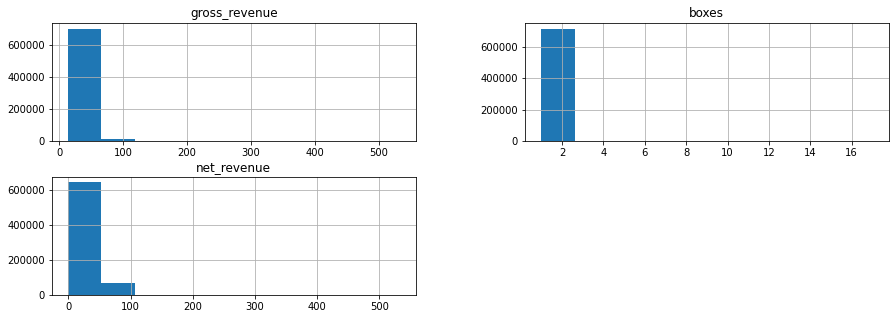

In [80]:
df[['gross_revenue','boxes','net_revenue']].hist(figsize=(15,5));

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="black"><b>Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="gray">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

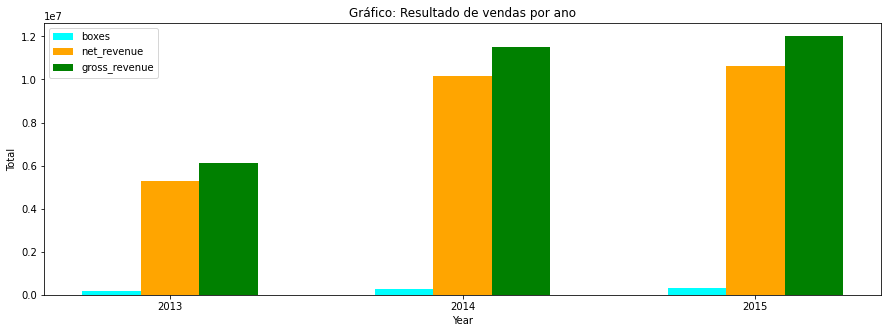

Tabela: Resultado de vendas por ano


,boxes,net_revenue,gross_revenue
year,,,
2013,156289,5295828,6134328
2014,291647,10161460,11505225
2015,292778,10611613,12019567


In [98]:
# data
x = df[['year','boxes','net_revenue','gross_revenue',]].groupby('year').sum().reset_index()['year']
y2 = df[['year','boxes', 'net_revenue','gross_revenue',]].groupby('year').sum().reset_index()['net_revenue']
y3 = df[['year','boxes','net_revenue','gross_revenue',]].groupby('year').sum().reset_index()['gross_revenue']
y1 = df[['year','boxes', 'net_revenue','gross_revenue',]].groupby('year').sum().reset_index()['boxes']





width = 0.2
 
plt.figure(figsize=(15,5))    
    
# plot data in grouped manner of bar type
plt.bar(x-0.2, y1, width, color='cyan')
plt.bar(x, y2, width, color='orange')
plt.bar(x+0.2, y3, width, color='green')


plt.xticks(x, ['2013', '2014', '2015'])
plt.xlabel("Year")
plt.ylabel("Total")
plt.legend(["boxes", "net_revenue", "gross_revenue"])
plt.title('Gráfico: Resultado de vendas por ano')
plt.show()


# Tabela
print('Tabela: Resultado de vendas por ano')
df[['year','boxes','net_revenue','gross_revenue']].groupby('year').sum()

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="black"><b> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?

<b>R: Paid Marketing em 2013 e em 2015. Para isso seperaou-se o faturamento de cada customer_acquisition_channel e calculou-se a média para cada valor categórico dessa classe. Resposta abaixo</b></font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="gray">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

In [99]:
# 2013

df.loc[df['year']==2013, ['customer_acquisition_channel',
                          'gross_revenue']].groupby('customer_acquisition_channel').mean().reset_index()

,customer_acquisition_channel,gross_revenue
0,Paid Marketing,42.076349
1,Referral,39.821818


In [100]:
# 2015

df.loc[df['year']==2015, ['customer_acquisition_channel',
                          'gross_revenue']].groupby('customer_acquisition_channel').mean().reset_index()

,customer_acquisition_channel,gross_revenue
0,Paid Marketing,42.039881
1,Referral,40.728221


https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="grey"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="black"><b>-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)

<b>R: Tabela e gráfico no snipet abaixo</font>

<font color="gray">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

Tabela:


,year,customer_id
0,2013,35851
1,2014,54865
2,2015,51643


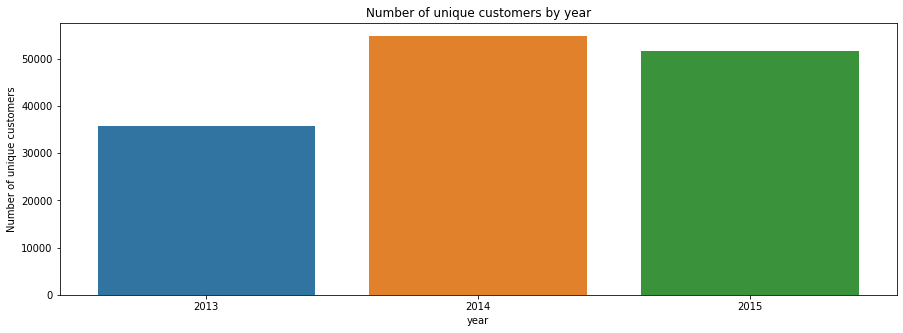

In [101]:
# Gráfico:
plt.figure(figsize=(15,5))
sns.barplot(x='year', y='customer_id', data=df[['customer_id','year']].groupby(['year']).nunique().reset_index())
plt.ylabel('Number of unique customers')
plt.title('Number of unique customers by year')
plt.plot()

# Tabela

# Grouping by year and counting uniques
print('Tabela:')
df[['customer_id','year']].groupby(['year']).nunique().reset_index()

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="black"><b>-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?

<b>R: A partir das semanas do ano é possível obter também os respectivos meses, os bimestres, trimestres, quadrimestres e semestres de cada ano. É possível então olhar o pefil de gross_revenue, boxes e net_revenue (separado por customer_acquisition_channel ou não) ao longo destes períodos do ano para observar a presença de alguma tendência ou sazonalidade em períodos específicos. Essas novas features serão criadas na sessão posterior (2.0 Feature Engineering) também para auxiliar os algorítmos de previsão de net_revenue.
    
    
<b>Com relação a cada cliente a análise pode ser incrementada adicionando a recência de compra de cada cliente (para avaliar o quão recentemente o cliente faz a compra), a recência média, número de compras por cliente, valor total comprado por cliente, ticket médio, quantidade média de prudutos/serviços contratados (para avaliar quais clientes compram mais e quais compram menos para poder fornecer os estimulos adequados a cada perfil), quantidade de devoluções do cliente, quantidade de reclamações (para mensurar a satisfação do cliente com o produto/serviço). Dessa forma seria necessário reduzir a granularidade do conjunto de dados para cliente (cada linha do conjunto de dados seria correspondente a um cliente único). Com o conjunto de dados configurado dessa maneira também seria possível desenvolver um projeto de agrupamento de perfis diferentes de clientes utilizando técnicas de clusterização baseados nessas características.
    
    
<b>Caso houvesse também informações de clientes que deixaram de adquirir algum produto/serviço a algum tempo (tempo definido de acordo com negócio) também seria possível utilizar as features levantadas em um projeto de previsão de churn e calcular a probabilidade de cada cliente deixar de comprar os produtos/serviços para que então a empresa possa fazer as intervenções adequadas em cada um desses clientes.</b></font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="grey">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?

<font color="grey">R: A partir das semanas do ano é possível obter também os respectivos meses, os bimestres, trimestres, quadrimestres e semestres de cada ano. É possível então olhar o pefil de gross_revenue, boxes e net_revenue (separado por customer_acquisition_channel ou não) ao longo destes períodos do ano para observar a presença de alguma tendência ou sazonalidade em períodos específicos. Essas novas features serão criadas na sessão posterior (2.0 Feature Engineering) também para auxiliar os algorítmos de previsão de net_revenue.
    
    
<font color="grey">Com relação a cada cliente a análise pode ser incrementada adicionando a recência de compra de cada cliente (para avaliar o quão recentemente o cliente faz a compra), a recência média, número de compras por cliente, valor total comprado por cliente, ticket médio, quantidade média de prudutos/serviços contratados (para avaliar quais clientes compram mais e quais compram menos para poder fornecer os estimulos adequados a cada perfil), quantidade de devoluções do cliente, quantidade de reclamações (para mensurar a satisfação do cliente com o produto/serviço). Dessa forma seria necessário reduzir a granularidade do conjunto de dados para cliente (cada linha do conjunto de dados seria correspondente a um cliente único). Com o conjunto de dados configurado dessa maneira também seria possível desenvolver um projeto de agrupamento de perfis diferentes de clientes utilizando técnicas de clusterização baseados nessas características.
    
    
<font color="grey">Caso houvesse também informações de clientes que deixaram de adquirir algum produto/serviço a algum tempo (tempo definido de acordo com negócio) também seria possível utilizar as features levantadas em um projeto de previsão de churn e calcular a probabilidade de cada cliente deixar de comprar os produtos/serviços para que então a empresa possa fazer as intervenções adequadas em cada um desses clientes.</font>




- <font color="black"><b>Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.
    
<b>Para resolver essa demanda todo o passo-a-passo para o desenvolvimento é descrito nas etapas 2.0 Feature engineering, 3.0 Data filtering, 4.0 Exploratory Data Analysis (EDA), 5.0 Data preparation e 6.0 Machine learning   
    
    
 </font>

- <font color="gray">Qual modelo teve a melhor performance?</font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

# 2.0 Feature engineering

In [102]:
df_2 = df.copy()

## <font color="gray"> Semanas do ano </font>

https://www.epochconverter.com/pt/semanas/2015

<b>2013</b>




Janeiro -    semana 1 a 5    -> 1


Fevereiro -  semana 6 - 9    -> 2


Março -      semana 10 - 13  -> 3


Abril -      semana 14 - 18  -> 4


Maio -       semana 19 - 22  -> 5


Junho -      semana 23 - 26  -> 6


Julho -      semana 27 - 31  -> 7


Agosto -     semana 32 - 35  -> 8


Setembro -   semana 36 -40   -> 9


Outubro -    semana 41 - 44  -> 10


Novembro -   semana 45 - 48  -> 11


Dezembro -   semana 49 - 52  -> 12





<b>2014</b>



Janeiro -    semana 1 a 5    -> 1



Fevereiro -  semana 6 - 9    -> 2



Março -      semana 10 - 14  -> 3



 
Abril -      semana 15 - 18  -> 4




Maio -       semana 19 - 22  -> 5




Junho -      semana 23 - 27  -> 6




Julho -      semana 28 - 31  -> 7




Agosto -     semana 32 - 35  -> 8




Setembro -   semana 36 -40   -> 9




Outubro -    semana 41 - 44  -> 10




Novembro -   semana 45 - 48  -> 11




Dezembro -   semana 49 - 52  -> 12



<b>2015</b>





Janeiro -    semana 1 a 5    -> 1




Fevereiro -  semana 6 - 9    -> 2




Março -      semana 10 - 14  -> 3 




Abril -      semana 15 - 18  -> 4




Maio -       semana 19 - 22  -> 5




Junho -      semana 23 - 27  -> 6




Julho -      semana 28 - 31  -> 7




Agosto -     semana 32 - 36  -> 8




Setembro -   semana 37 -40   -> 9




Outubro -    semana 41 - 44  -> 10




Novembro -   semana 45 - 49  -> 11




Dezembro -   semana 50 - 53  -> 12

## <font color="gray"> 2.1 Creating new features </font>

In [103]:
# Creating 'semester_of_year' column

df_2['semester_of_year'] =  [1 if i <26 else 2 for i in df['week_of_year']]



# Creating 'month_of_year' column

df_2['month_of_year'] = np.nan


# Filling month of year

# 2013

df_2.loc[df_2['year']==2013, 'month_of_year']  = [1 if i<= 5
                                                  else 2 if 6<=i<=9
                                                  else 3 if 10<=i<=13
                                                  else 4 if 14<=i<=18
                                                  else 5 if 19<=i<=22
                                                  else 6 if 23<=i<=26
                                                  else 7 if 27<=i<=31
                                                  else 8 if 32<=i<=35
                                                  else 9 if 36<=i<=40
                                                  else 10 if 41<=i<=44
                                                  else 11 if 45<=i<=48
                                                  else 12 for i in df_2.loc[df_2['year']==2013, 'week_of_year'] ]


# 2014

df_2.loc[df_2['year']==2014, 'month_of_year']  = [1 if i<= 5
                                                  else 2 if 6<=i<=9
                                                  else 3 if 10<=i<=14
                                                  else 4 if 15<=i<=18
                                                  else 5 if 19<=i<=22
                                                  else 6 if 23<=i<=27
                                                  else 7 if 28<=i<=31
                                                  else 8 if 32<=i<=35
                                                  else 9 if 36<=i<=40
                                                  else 10 if 41<=i<=44
                                                  else 11 if 45<=i<=48
                                                  else 12 for i in df_2.loc[df_2['year']==2014, 'week_of_year'] ]


# 2015

df_2.loc[df_2['year']==2015, 'month_of_year']  = [1 if i<= 5
                                                  else 2 if 6<=i<=9
                                                  else 3 if 10<=i<=14
                                                  else 4 if 15<=i<=18
                                                  else 5 if 19<=i<=22
                                                  else 6 if 23<=i<=27
                                                  else 7 if 28<=i<=31
                                                  else 8 if 32<=i<=36
                                                  else 9 if 37<=i<=40
                                                  else 10 if 41<=i<=44
                                                  else 11 if 45<=i<=49
                                                  else 12 for i in df_2.loc[df_2['year']==2015, 'week_of_year'] ]


# changing 'month_of_year' data type

df_2['month_of_year'] = df_2['month_of_year'].astype('int')



# Creating 'quarter_of_the_year' column (trimestre)

df_2['quarter'] = [1 if i<= 3
                  else 2 if 4<=i<=6
                  else 3 if 7<=i<=9
                  else 4  for i in df_2['month_of_year']]




# Creating 'week_of_month' column

df_2['week_of_month'] = np.nan


# filling the column:


for i in tuple(df_2['year'].unique()):
    
    for it in tuple(df_2['month_of_year'].unique()):
    
        for count, value in tuple(enumerate(np.sort(df_2.loc[(df_2['month_of_year']==it) & (df_2['year']==i), 'week_of_year'].unique()).tolist())):

            df_2.loc[(df_2['month_of_year']==it) & (df_2['year']==i) & (df_2['week_of_year']==value), 'week_of_month'] = count+1
            


# changing 'week_of_month' data type

df_2['week_of_month'] = df_2['week_of_month'].astype('int')


In [104]:
df_2.isna().sum()

customer_id                     0
customer_acquisition_channel    0
year                            0
gross_revenue                   0
boxes                           0
net_revenue                     0
week_of_year                    0
semester_of_year                0
month_of_year                   0
quarter                         0
week_of_month                   0
dtype: int64

# 3.0 Data filtering

In [105]:
df_3 = df_2.copy()

In [106]:
# Remover as linhas onde 'net_revenue'==0

df_3 = df_3[df_3['net_revenue']!=0]


# Organizar o dataset cronologicamente (importante para problemas de previsão)

df_3 = df_3.sort_values(by=['year','week_of_year'])



# Remover colunas que não estarão em produção ['customer_acquisition_channel', 'gross_revenue', 'boxes'] e
## agrupar o df mantendo a granulometria em cada semana do ano, somando o net_revenue para cada semana

df_grouped = df_3[['year',
                   'month_of_year',
                   'week_of_month',
                   'week_of_year',
                   'quarter',
                   'semester_of_year',
                   'net_revenue']].groupby(['year',
                                            'month_of_year',
                                            'week_of_month',
                                            'week_of_year',
                                            'quarter',
                                            'semester_of_year']).sum().reset_index()

É possível observar abaixo que a redução na granulometria diminuiu significativamente o tamanho do dataset. Isso pode trazer consequências nos resultados dos modelos a serem avaliados. Entretanto o pressuposto assumido neste momento é o de que essa ação é a que faria maior sentido já que não se sabe quais clientes farão compras futuras, não se sabe também quais serão 'customer_acquisition_channel' utilizados em compras futuras. Uma vez que o problema demanda previsão de 'net_revenue' então decideiu-se manter as variáveis que estarão presentes no futuro.

In [36]:
df_grouped

,year,month_of_year,week_of_month,week_of_year,quarter,semester_of_year,net_revenue
0,2013,1,1,2,1,1,100
1,2013,1,2,3,1,1,526
2,2013,1,3,4,1,1,929
3,2013,1,4,5,1,1,1177
4,2013,2,1,6,1,1,1361
...,...,...,...,...,...,...,...
151,2015,11,4,48,4,2,6792
152,2015,11,5,49,4,2,7320
153,2015,12,1,50,4,2,6988
154,2015,12,2,51,4,2,5492


# 4.0 Exploratory Data Analysis (EDA)

In [108]:
df_4 = df_3.copy()

## <font color="gray"> 4.1 Univariate analysis </font>

<AxesSubplot:>

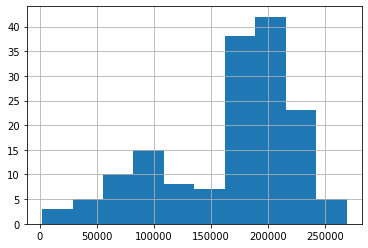

In [109]:
# Response variable

df_grouped['net_revenue'].hist()

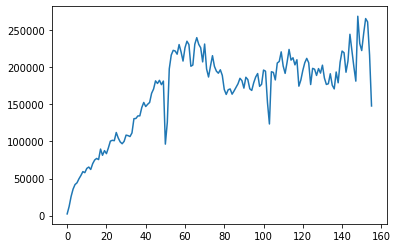

In [110]:
plt.plot(df_grouped['net_revenue'])

In [111]:
df_grouped

,year,month_of_year,week_of_month,week_of_year,quarter,semester_of_year,net_revenue
0,2013,1,1,2,1,1,2310
1,2013,1,2,3,1,1,12342
2,2013,1,3,4,1,1,25807
3,2013,1,4,5,1,1,35713
4,2013,2,1,6,1,1,41898
...,...,...,...,...,...,...,...
151,2015,11,4,48,4,2,245756
152,2015,11,5,49,4,2,265797
153,2015,12,1,50,4,2,261247
154,2015,12,2,51,4,2,216590


### <i>4.1.1 numerical attributes</i>

### <i>4.1.2 categorical attributes</i>

### <i>4.2.1 validating hypothesis raised</i>

## <font color="gray"> 4.2 Multivariate analysis </font>

### <i>4.3.1 numerical attributes</i>

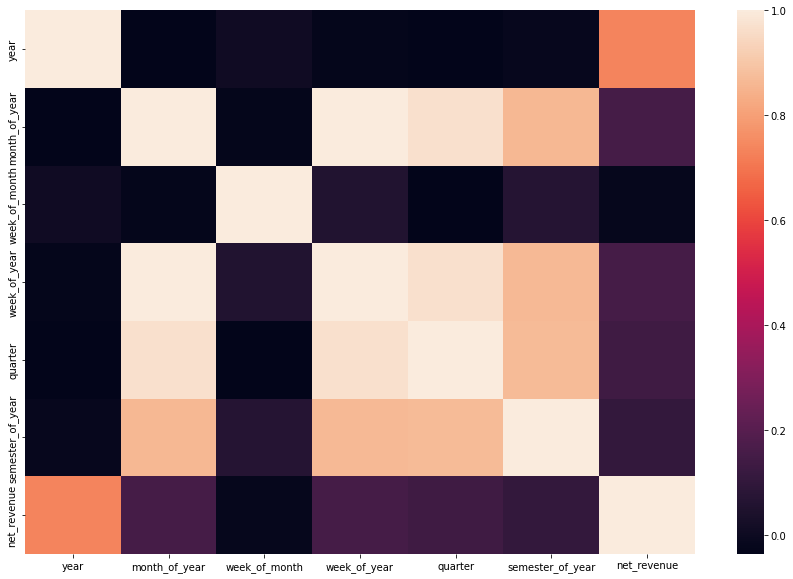

In [112]:
plt.figure(figsize=(15,10))

sns.heatmap(df_grouped.corr());

# 5.0 Data preparation

In [113]:
df_5 = df_grouped.copy()

## <font color="gray"> 5.1 Train/Test split </font>

A separação de treino e teste será feita respeitando a cronologia dos dados. Uma vez que eles já foram organizados na seção anterior então o split treino/teste será feito conforme o enunciado do problema demanda (6 meses futuros). Considerando que a granulometria dos dados ficou em semanas, dessa forma serão separados como conjunto teste as últimas 24 semanas.

In [114]:
df_5

,year,month_of_year,week_of_month,week_of_year,quarter,semester_of_year,net_revenue
0,2013,1,1,2,1,1,2310
1,2013,1,2,3,1,1,12342
2,2013,1,3,4,1,1,25807
3,2013,1,4,5,1,1,35713
4,2013,2,1,6,1,1,41898
...,...,...,...,...,...,...,...
151,2015,11,4,48,4,2,245756
152,2015,11,5,49,4,2,265797
153,2015,12,1,50,4,2,261247
154,2015,12,2,51,4,2,216590


In [115]:
# Redefining os index

df_5.index = [i for i in range(0,len(df_5))]


# Uma vez que as variáveis de data já foi desmembrada em novas features, remover a coluna 'year'

df_5 = df_5.drop(columns=['year'])

In [116]:
# Train 

train, test = df_5.iloc[:-24,:], df_5.iloc[-24:,:]

# X
X_train, X_test = train.drop(columns=['net_revenue']), test.drop(columns=['net_revenue'])

# y 
y_train, y_test = train['net_revenue'].copy(), test['net_revenue'].copy()

In [117]:
# Saving X_test to csv

X_test.to_csv('X_test.csv')

## <font color="gray"> 5.2 Scaling - numerical attributes </font>

As variáveis remanescentes são variáveis de natureza cíclica. Isso deve ser levado em consideração na hora de se fazer o scaling

In [118]:
# month_of_year

X_train['month_of_year_sin'] = X_train['month_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
X_train['month_of_year_cos'] = X_train['month_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/12)))


mms = MinMaxScaler()

X_train['month_of_year_sin'] = mms.fit_transform(X_train[['month_of_year_sin']].values)

mms = MinMaxScaler()

X_train['month_of_year_cos'] = mms.fit_transform(X_train[['month_of_year_cos']].values)




# week_of_month

X_train['week_of_month_sin'] = X_train['week_of_month'].apply(lambda x: np.sin(x*(2.*np.pi/4)))
X_train['week_of_month_cos'] = X_train['week_of_month'].apply(lambda x: np.cos(x*(2.*np.pi/4)))


mms = MinMaxScaler()

X_train['week_of_month_sin'] = mms.fit_transform(X_train[['week_of_month_sin']].values)

mms = MinMaxScaler()

X_train['week_of_month_cos'] = mms.fit_transform(X_train[['week_of_month_cos']].values)




# week_of_year

X_train['week_of_year_sin'] = X_train['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
X_train['week_of_year_cos'] = X_train['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))


mms = MinMaxScaler()

X_train['week_of_year_sin'] = mms.fit_transform(X_train[['week_of_year_sin']].values)

mms = MinMaxScaler()

X_train['week_of_year_cos'] = mms.fit_transform(X_train[['week_of_year_cos']].values)




# quarter

X_train['quarter_sin'] = X_train['quarter'].apply(lambda x: np.sin(x*(2.*np.pi/4)))
X_train['quarter_cos'] = X_train['quarter'].apply(lambda x: np.cos(x*(2.*np.pi/4)))


mms = MinMaxScaler()

X_train['quarter_sin'] = mms.fit_transform(X_train[['quarter_sin']].values)

mms = MinMaxScaler()

X_train['quarter_cos'] = mms.fit_transform(X_train[['quarter_cos']].values)




# Mantendo apenas as colunas codificadas 

X_train = X_train[['month_of_year_sin', 'month_of_year_cos', 'week_of_month_sin', 'week_of_month_cos',
                   'week_of_year_sin', 'week_of_year_cos', 'quarter_sin', 'quarter_cos', 'semester_of_year']]

A variável 'semester_of_year' será codificada usando dummies:

In [119]:
# 'semester_of_year' - dummies

X_train['semester_of_year_1'] = X_train['semester_of_year'].apply(lambda x: 1 if x==1 else 0)

X_train['semester_of_year_2'] = X_train['semester_of_year'].apply(lambda x: 1 if x==2 else 0)


# removing original column
X_train = X_train.drop(columns=['semester_of_year'])

Fazendo o scaling dos dados de teste:

In [120]:
# month_of_year

X_test['month_of_year_sin'] = X_test['month_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
X_test['month_of_year_cos'] = X_test['month_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/12)))


mms = MinMaxScaler()

X_test['month_of_year_sin'] = mms.fit_transform(X_test[['month_of_year_sin']].values)

mms = MinMaxScaler()

X_test['month_of_year_cos'] = mms.fit_transform(X_test[['month_of_year_cos']].values)




# week_of_month

X_test['week_of_month_sin'] = X_test['week_of_month'].apply(lambda x: np.sin(x*(2.*np.pi/4)))
X_test['week_of_month_cos'] = X_test['week_of_month'].apply(lambda x: np.cos(x*(2.*np.pi/4)))


mms = MinMaxScaler()

X_test['week_of_month_sin'] = mms.fit_transform(X_test[['week_of_month_sin']].values)

mms = MinMaxScaler()

X_test['week_of_month_cos'] = mms.fit_transform(X_test[['week_of_month_cos']].values)




# week_of_year

X_test['week_of_year_sin'] = X_test['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
X_test['week_of_year_cos'] = X_test['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))


mms = MinMaxScaler()

X_test['week_of_year_sin'] = mms.fit_transform(X_test[['week_of_year_sin']].values)

mms = MinMaxScaler()

X_test['week_of_year_cos'] = mms.fit_transform(X_test[['week_of_year_cos']].values)




# quarter

X_test['quarter_sin'] = X_test['quarter'].apply(lambda x: np.sin(x*(2.*np.pi/4)))
X_test['quarter_cos'] = X_test['quarter'].apply(lambda x: np.cos(x*(2.*np.pi/4)))


mms = MinMaxScaler()

X_test['quarter_sin'] = mms.fit_transform(X_test[['quarter_sin']].values)

mms = MinMaxScaler()

X_test['quarter_cos'] = mms.fit_transform(X_test[['quarter_cos']].values)




# Mantendo apenas as colunas codificadas 

X_test = X_test[['month_of_year_sin', 'month_of_year_cos', 'week_of_month_sin', 'week_of_month_cos',
                   'week_of_year_sin', 'week_of_year_cos', 'quarter_sin', 'quarter_cos', 'semester_of_year']]



# 'semester_of_year' - dummies

X_test['semester_of_year_1'] = X_test['semester_of_year'].apply(lambda x: 1 if x==1 else 0)

X_test['semester_of_year_2'] = X_test['semester_of_year'].apply(lambda x: 1 if x==2 else 0)


# removing original column
X_test = X_test.drop(columns=['semester_of_year'])

In [121]:

# reorganizando a ordem das colunas
X_test = X_test[['month_of_year_sin', 'month_of_year_cos', 'week_of_month_sin',
                 'week_of_month_cos', 'week_of_year_sin', 'week_of_year_cos',
                 'quarter_sin', 'quarter_cos', 'semester_of_year_1',
                 'semester_of_year_2']]

<AxesSubplot:xlabel='week_of_year_cos', ylabel='week_of_year_sin'>

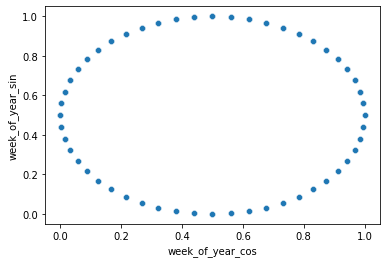

In [122]:
sns.scatterplot(x='week_of_year_cos', y='week_of_year_sin', data=X_train)

# 6.0 Machine learning

In [220]:
list_model_names = []
list_mae = []
list_mape = []
list_rmse = []
list_predictions = []

## <font color="gray"> 6.1 Baseline model </font>

In [221]:

# model definition
dummy_reg = DummyRegressor()

# model fit
dummy_reg.fit(X_train, y_train)

# predictions
y_pred = dummy_reg.predict(X_test)


# Metrics
print('Model metrics: {}\n'.format(dummy_reg))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append(dummy_reg)
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model metrics: DummyRegressor()

MAE: 51003.472222222226
MAPE: 0.22762596648341418
RMSE: 59268.88569588602


## <font color="gray"> 6.2 Linear Regression </font>

In [222]:

# model definition
lr = LinearRegression()

# model fit
lr.fit(X_train, y_train)

# predictions
y_pred = lr.predict(X_test)


# Metrics
print('Model metrics: {}\n'.format(lr))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append(lr)
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model metrics: LinearRegression()

MAE: 46739.533446181245
MAPE: 0.214997540631131
RMSE: 51881.61539738221


## <font color="gray"> 6.4 Random Forest </font>

In [223]:
# model definition
rf = RandomForestRegressor()

# model fit
rf.fit(X_train, y_train)

# predictions
y_pred = rf.predict(X_test)


# Metrics
print('Model metrics: {}\n'.format(rf))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append('Random Forest')
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model metrics: RandomForestRegressor()

MAE: 57477.036156746035
MAPE: 0.26026363059452273
RMSE: 65444.16249127275


## <font color="gray"> 6.6 Neural Network - MLP</font>

In [224]:
# ========================= ANN com LOOCV ===================================================

# ========================= model training =======================================

in_dim = np.array(X_train).shape[1]
out_dim = np.array(y_train.to_frame()).shape[1]



   
# define model
model = Sequential()

# Defining the Input layer and FIRST hidden layer, both are same!
model.add(Dense(100, input_dim=in_dim, activation="relu"))
# Defining the Second layer of the model
# after the first layer we don't have to specify input_dim as keras configure it automatically
model.add(Dense(32, activation="relu"))
# Defining the Ouput layer
model.add(Dense(out_dim))
# Compiling the model
model.compile(loss="mse", optimizer="rmsprop")      

model.summary()

model.fit(X_train, y_train, epochs=100, batch_size=12, verbose=1)

#predictions
y_pred = model.predict(X_test)
    

# ============================================================================================ 


# Metrics
print('Model metrics: {}\n'.format('Neural Network'))

# MAE
print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))

# RMSE
print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))


# storing metrics
list_model_names.append('Neural Network')
list_mae.append(mean_absolute_error(y_test, y_pred))
list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))

list_predictions.append(y_pred)

Model: "sequential_126"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_378 (Dense)           (None, 100)               1100      
                                                                 
 dense_379 (Dense)           (None, 32)                3232      
                                                                 
 dense_380 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11/11 [==============================] - 0s 865us/step - loss: 28657313792.0000
Epoch 2/100
11/11 [==============================] - 0s 818us/step - loss: 28656809984.0000
Epoch 3/100
11/11 [==============================] - 0s 801us/step - loss: 28656214016.0000
Epoch 4/100
11/11 [===================

11/11 [==============================] - 0s 730us/step - loss: 27092746240.0000
Epoch 81/100
11/11 [==============================] - 0s 842us/step - loss: 27040942080.0000
Epoch 82/100
11/11 [==============================] - 0s 804us/step - loss: 26987683840.0000
Epoch 83/100
11/11 [==============================] - 0s 767us/step - loss: 26932539392.0000
Epoch 84/100
11/11 [==============================] - 0s 804us/step - loss: 26876827648.0000
Epoch 85/100
11/11 [==============================] - 0s 778us/step - loss: 26820816896.0000
Epoch 86/100
11/11 [==============================] - 0s 727us/step - loss: 26763307008.0000
Epoch 87/100
11/11 [==============================] - 0s 766us/step - loss: 26703872000.0000
Epoch 88/100
11/11 [==============================] - 0s 802us/step - loss: 26643501056.0000
Epoch 89/100
11/11 [==============================] - 0s 774us/step - loss: 26583402496.0000
Epoch 90/100
11/11 [==============================] - 0s 822us/step - loss: 2652183

## <font color="gray"> 7.7 ARIMA </font>

https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7

In [225]:
# Dataframe para ARIMA

df_arima_train = pd.DataFrame(y_train)

df_arima_test = pd.DataFrame(y_test)

In [226]:
# Implementando ARIMA

decomposition =  seasonal_decompose(df_arima_train, period=62)

model = ARIMA(df_arima_train, order=(2,1,2))

results = model.fit()

In [227]:
## Ajuste arima

# results.fittedvalues


# Inserindo as predições no conjunto teste

df_arima_test['predictions'] = results.predict(start=132, end=155)

In [228]:
# Avaliando MAE, MAPE e RMSE do conjunto de teste para comparar com os algorítimos de machine learning



# MAE
print('MAE: {}'.format(mean_absolute_error(df_arima_test['net_revenue'].values,
                                           df_arima_test['predictions'].values)))

# MAPE
print('MAPE: {}'.format(mean_absolute_percentage_error(df_arima_test['net_revenue'].values,
                                                       df_arima_test['predictions'].values)))


# RMSE
print('RMSE: {}'.format(mean_squared_error(df_arima_test['net_revenue'].values,
                                           df_arima_test['predictions'].values, squared=False)))


# storing metrics
list_model_names.append('ARIMA')
list_mae.append(mean_absolute_error(y_test, df_arima_test['predictions'].values))
list_mape.append(mean_absolute_percentage_error(y_test, df_arima_test['predictions'].values))
list_rmse.append(mean_squared_error(y_test, df_arima_test['predictions'].values, squared=False))

list_predictions.append(df_arima_test['predictions'].values)

MAE: 29550.20103563106
MAPE: 0.1320715768009972
RMSE: 37647.96266719912


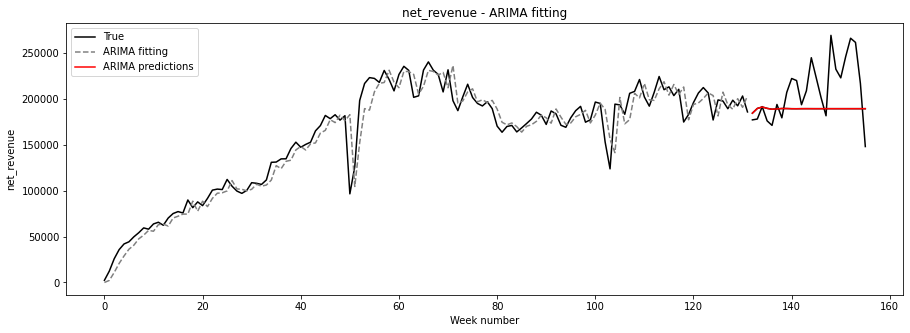

In [229]:
plt.figure(figsize=(15,5))


plt.plot(df_arima_train, color='black', label='True')
plt.plot(df_arima_test, color='black')

plt.legend()

plt.plot(results.fittedvalues, color='gray', label='ARIMA fitting', linestyle="--")
plt.legend()


plt.plot(df_arima_test['predictions'], color='red', label='ARIMA predictions')

plt.legend()

plt.xlabel('Week number')
plt.ylabel('net_revenue')
plt.title('net_revenue - ARIMA fitting');

## <font color="gray"> Overall results </font>

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="grey">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?

<font color="grey">R: A partir das semanas do ano é possível obter também os respectivos meses, os bimestres, trimestres, quadrimestres e semestres de cada ano. É possível então olhar o pefil de gross_revenue, boxes e net_revenue (separado por customer_acquisition_channel ou não) ao longo destes períodos do ano para observar a presença de alguma tendência ou sazonalidade em períodos específicos. Essas novas features serão criadas na sessão posterior (2.0 Feature Engineering) também para auxiliar os algorítmos de previsão de net_revenue.
    
    
<font color="grey">Com relação a cada cliente a análise pode ser incrementada adicionando a recência de compra de cada cliente (para avaliar o quão recentemente o cliente faz a compra), a recência média, número de compras por cliente, valor total comprado por cliente, ticket médio, quantidade média de prudutos/serviços contratados (para avaliar quais clientes compram mais e quais compram menos para poder fornecer os estimulos adequados a cada perfil), quantidade de devoluções do cliente, quantidade de reclamações (para mensurar a satisfação do cliente com o produto/serviço). Dessa forma seria necessário reduzir a granularidade do conjunto de dados para cliente (cada linha do conjunto de dados seria correspondente a um cliente único). Com o conjunto de dados configurado dessa maneira também seria possível desenvolver um projeto de agrupamento de perfis diferentes de clientes utilizando técnicas de clusterização baseados nessas características.
    
    
<font color="grey">Caso houvesse também informações de clientes que deixaram de adquirir algum produto/serviço a algum tempo (tempo definido de acordo com negócio) também seria possível utilizar as features levantadas em um projeto de previsão de churn e calcular a probabilidade de cada cliente deixar de comprar os produtos/serviços para que então a empresa possa fazer as intervenções adequadas em cada um desses clientes.</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="black"><b>Qual modelo teve a melhor performance?
    
<font color="black"><b>R: Considerando a métrica MAE (e também MAPE e RMSE) a abordagem que retornou o menor erro no conjunto de teste foi o ARIMA (tabela abaixo).</b></font>

- <font color="gray">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="gray">Como realizou treino e teste?</font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

In [230]:
print('Resultado modelos:')

pd.DataFrame({'MAPE':list_mape, 'MAE':list_mae, 'RMSE':list_rmse}, index=list_model_names).sort_values(by=['MAE'])

Resultado modelos:


,MAPE,MAE,RMSE
ARIMA,0.132072,29550.201036,37647.962667
LinearRegression(),0.214998,46739.533446,51881.615397
DummyRegressor(),0.227626,51003.472222,59268.885696
Random Forest,0.260264,57477.036157,65444.162491
Neural Network,0.958582,200759.058736,203010.890607


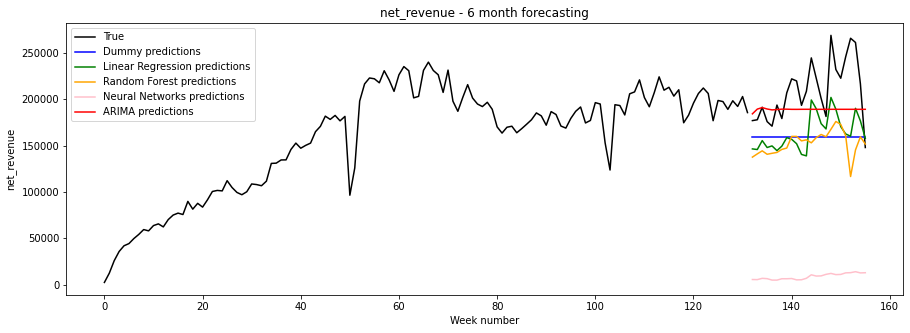

In [231]:
plt.figure(figsize=(15,5))

# True
plt.plot(df_arima_train, color='black', label='True')
plt.plot(df_arima_test['net_revenue'], color='black')

plt.legend()

# Dummy
plt.plot(pd.DataFrame(list_predictions[0], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='blue', label='Dummy predictions')

plt.legend()


# Linear Regression
plt.plot(pd.DataFrame(list_predictions[1], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Green', label='Linear Regression predictions')

plt.legend()



# Random Forest
plt.plot(pd.DataFrame(list_predictions[2], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Orange', label='Random Forest predictions')

plt.legend()



# Neural Networks
plt.plot(pd.DataFrame(list_predictions[3], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Pink', label='Neural Networks predictions')

plt.legend()


# ARIMA
plt.plot(df_arima_test['predictions'], color='red', label='ARIMA predictions')

plt.legend()




plt.xlabel('Week number')
plt.ylabel('net_revenue')
plt.title('net_revenue - 6 month forecasting');

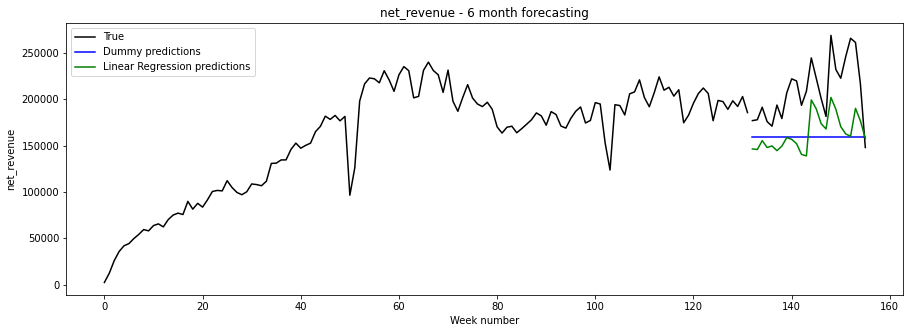

In [233]:
plt.figure(figsize=(15,5))

# True
plt.plot(df_arima_train, color='black', label='True')
plt.plot(df_arima_test['net_revenue'], color='black')

plt.legend()

# Dummy
plt.plot(pd.DataFrame(list_predictions[0], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='blue', label='Dummy predictions')

plt.legend()


# Linear Regression
plt.plot(pd.DataFrame(list_predictions[1], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Green', label='Linear Regression predictions')

plt.legend()




plt.legend()

plt.xlabel('Week number')
plt.ylabel('net_revenue')
plt.title('net_revenue - 6 month forecasting');

In [ ]:
plt.figure(figsize=(15,5))

# True
plt.plot(df_arima_train, color='black', label='True')
plt.plot(df_arima_test['net_revenue'], color='black')

plt.legend()




# Linear Regression
plt.plot(pd.DataFrame(list_predictions[1], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Green', label='Linear Regression predictions')

plt.legend()


# Lasso
plt.plot(pd.DataFrame(list_predictions[2], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Brown', label='Lasso predictions')

plt.legend()


# Random Forest
plt.plot(pd.DataFrame(list_predictions[3], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Orange', label='Random Forest predictions')

plt.legend()


# Exp Smooth
plt.plot(df_hw_test['predictions'], color='blue', label='HW predictions')

plt.legend()

# Neural Networks
plt.plot(pd.DataFrame(list_predictions[5], index=range(y_test.index[0],y_test.index[-1]+1)),
         color='Pink', label='Neural Networks predictions')




plt.legend()

plt.xlabel('Week number')
plt.ylabel('net_revenue')
plt.title('net_revenue - 6 month forecasting');

https://docs.google.com/spreadsheets/d/1BYeWiF__UivBTF1YX-wWeApQ_8DW_mLZov_yzIat_Lc/edit#gid=1718890019


Temos alguns pontos que gostaríamos que fossem tratados na construção do Dashboard sendo:


- <font color="grey">Aponte resultados de vendas por ano: Gross Revenue, Net Revenue, Boxes (em Gráfico e Tabela)</font>

<font color="gray"> -Qual customer_acquision_channel teve maior Ticket Médio em 2013 e em 2015?</font>

<font color="gray">-Número de clientes únicos por Ano e comparativo desse resultado 2013x2015 (em gráfico e tabela)</font>

<font color="grey">-Quais dados complementares você julga que seriam importantes para incrementar suas análises em relação a resultados de vendas e análises sobre os clientes?

<font color="grey">R: A partir das semanas do ano é possível obter também os respectivos meses, os bimestres, trimestres, quadrimestres e semestres de cada ano. É possível então olhar o pefil de gross_revenue, boxes e net_revenue (separado por customer_acquisition_channel ou não) ao longo destes períodos do ano para observar a presença de alguma tendência ou sazonalidade em períodos específicos. Essas novas features serão criadas na sessão posterior (2.0 Feature Engineering) também para auxiliar os algorítmos de previsão de net_revenue.
    
    
<font color="grey">Com relação a cada cliente a análise pode ser incrementada adicionando a recência de compra de cada cliente (para avaliar o quão recentemente o cliente faz a compra), a recência média, número de compras por cliente, valor total comprado por cliente, ticket médio, quantidade média de prudutos/serviços contratados (para avaliar quais clientes compram mais e quais compram menos para poder fornecer os estimulos adequados a cada perfil), quantidade de devoluções do cliente, quantidade de reclamações (para mensurar a satisfação do cliente com o produto/serviço). Dessa forma seria necessário reduzir a granularidade do conjunto de dados para cliente (cada linha do conjunto de dados seria correspondente a um cliente único). Com o conjunto de dados configurado dessa maneira também seria possível desenvolver um projeto de agrupamento de perfis diferentes de clientes utilizando técnicas de clusterização baseados nessas características.
    
    
<font color="grey">Caso houvesse também informações de clientes que deixaram de adquirir algum produto/serviço a algum tempo (tempo definido de acordo com negócio) também seria possível utilizar as features levantadas em um projeto de previsão de churn e calcular a probabilidade de cada cliente deixar de comprar os produtos/serviços para que então a empresa possa fazer as intervenções adequadas em cada um desses clientes.</font>




- <font color="gray">Faça a projeção de net_revenue para 6 meses futuros utilizando regressão linear, ARIMA e machine learning (Redes neurais | Random forest); compare os resultados.</font>

- <font color="grey">Qual modelo teve a melhor performance?

- <font color="grey">Quais métricas utilizou para comparar? E por quê?</font>

- <font color="black"><b>Como realizou treino e teste?</b></font>
    
<font color="black"><b>R: Conforme mencionado anteriormente, por se tratar de um problema de previsão no tempo é importante considerar essa informação na resolução do problema na parte da separação dos respectivos conjuntos de treino e teste. Ambos os conjuntos precisam estar organizados temporalmente onde o conjunto teste deve corresponder ao período futuro em relação ao conjunto de treino. Uma vez que a granulometria usada para resolver o problema estava em semanas e a demanda de previsão era para 6 meses então separou-se as últimas 24 semanas para ser o conjunto teste.</b></font>


<font color="gray">(em texto)</font>


<font color="gray">Plus:</font>




- <font color="gray">Apresentar gráficos (seaborn, ggplot).</font>

- <font color="gray">Processamento em cadeia (loops).</font>

- <font color="gray">Trazer pontos adicionais que tenham relevância considerando o dataset.</font>



Na reunião de apresentação, a ideia é apresentar a tela / report desenvolvido, deixando claro sua linha de raciocínio e conclusões da sua leitura.

## <font color="orange"> Evaluating data slices </font>

Ao observar o plot abaixo de net_revenue em função das semanas é possível observar que o comportamento de net_revenue antes de 60 semanas é diferente do comportamento após 60 semanas. Enquanto que no primeiro caso é possível observar um comportament de crescimento em função do tempo, no segundo caso esse comportamento é diferente. Dessa forma esses diferentes perfis de comportamento podem, de alguma forma, estar comprometendo a eficiência do algoritmo na previsão de vendas para 6 meses.


Uma vez que o enunciado do problema demanda a previsão de vendas para 6 meses (24 semanas) e que não foi mencionado sobre critérios de utilização dos dados no treinamento dos algoritmos, decidiu-se então adotar a seguinte estratégia:

- O conjunto de teste foi mantido para as últimas 24 semanas do dataset conforme as demais avaliações.
- Foram avaliados diferentes conjuntos de treinamento relizando-se diferentes slices no conjunto de treinamento, variando a data mais antiga do dado de treinamento (início do slicing) e mantendo a data mais recente (mais próxima da primeira data do conjunto de teste, término do slicing).
- As métricas do modelo foram coletadas para cada diferente slicing aplicado aos dados para então se obter um ponto de corte ideal que maximiza do desempenho do modelo.
- A estratégia foi repetida para os demais modelos de machine learning avaliados anteriormente

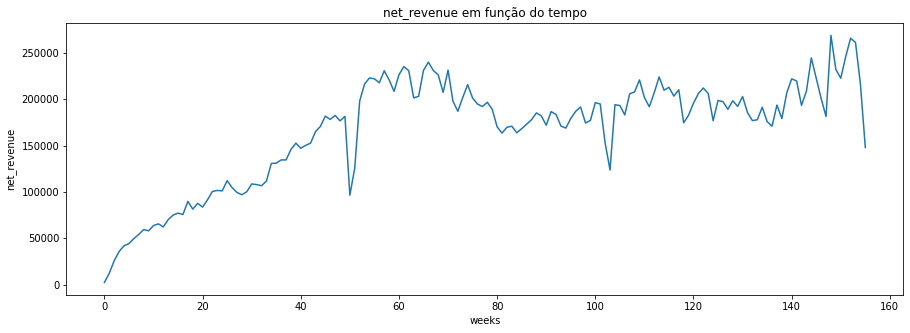

In [169]:
plt.figure(figsize=(15,5))
plt.plot(df_grouped['net_revenue']);
plt.xlabel('weeks')
plt.ylabel('net_revenue')
plt.title('net_revenue em função do tempo');

In [245]:
# Lists to store metrics for optimed slicing

list_best_mae = []
list_best_mape = []
list_best_rmse = []
list_best_slicing_index = []

list_model_names = []

### <font color="orange"> Linear Regression </font>

In [246]:
# Linear Regression - increasing sliced data


# Redefining lists

list_mae = []
list_mape = []
list_rmse = []
list_predictions = []



for i in range(0, len(X_train.index)-10):
    
    
    # model definition
    model = LinearRegression()
    
    # model fit
    model.fit(X_train.loc[i:X_train.index[-1],:], y_train.loc[i:X_train.index[-1]])
    
    # predictions
    y_pred = model.predict(X_test)
    
    
    print('\nInitial slicing index evaluated: {}'.format(i))
    
    # Metrics
    print('\nModel metrics: {}\n'.format(model))
    
    # MAE
    print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
    
    # MAPE
    print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))
    
    # RMSE
    print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))
    
    
    # storing metrics
    list_mae.append(mean_absolute_error(y_test, y_pred))
    list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
    list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
    
    list_predictions.append(y_pred)

    
print('--'*60)    
print('\nEvaluation finished')
print('Results:\n')
print('Model: {}'.format(model))
print('Best slicing starting index: {}'.format(list_mae.index(min(list_mae))))
print('MAE: {}'.format(list_mae[list_mae.index(min(list_mae))]))
print('MAPE: {}'.format(list_mape[list_mae.index(min(list_mae))]))
print('RMSE: {}'.format(list_rmse[list_mae.index(min(list_mae))]))
list_model_names.append(lr)
list_best_mae.append(list_mae[list_mae.index(min(list_mae))])
list_best_mape.append(list_mape[list_mae.index(min(list_mae))])
list_best_rmse.append(list_rmse[list_mae.index(min(list_mae))])
list_best_slicing_index.append(list_mae.index(min(list_mae)))


Initial slicing index evaluated: 0

Model metrics: LinearRegression()

MAE: 46739.533446181245
MAPE: 0.214997540631131
RMSE: 51881.61539738221

Initial slicing index evaluated: 1

Model metrics: LinearRegression()

MAE: 45515.16629663112
MAPE: 0.20950674412584033
RMSE: 50914.417668968104

Initial slicing index evaluated: 2

Model metrics: LinearRegression()

MAE: 42240.74812566641
MAPE: 0.19409839802117923
RMSE: 47950.04556810191

Initial slicing index evaluated: 3

Model metrics: LinearRegression()

MAE: 39050.67262352089
MAPE: 0.17819213747791626
RMSE: 45178.20899005624

Initial slicing index evaluated: 4

Model metrics: LinearRegression()

MAE: 36616.41464574794
MAPE: 0.16652033516542095
RMSE: 42919.31223462432

Initial slicing index evaluated: 5

Model metrics: LinearRegression()

MAE: 36741.05843407579
MAPE: 0.1679344212899798
RMSE: 42772.13073460821

Initial slicing index evaluated: 6

Model metrics: LinearRegression()

MAE: 35395.05364207708
MAPE: 0.16257262764126154
RMSE: 4123


Initial slicing index evaluated: 63

Model metrics: LinearRegression()

MAE: 31594.248540887016
MAPE: 0.140738483991817
RMSE: 38662.69133497866

Initial slicing index evaluated: 64

Model metrics: LinearRegression()

MAE: 31610.75586585481
MAPE: 0.14076246946736026
RMSE: 38698.685062429955

Initial slicing index evaluated: 65

Model metrics: LinearRegression()

MAE: 31621.10452421701
MAPE: 0.140837677323305
RMSE: 38691.132536574325

Initial slicing index evaluated: 66

Model metrics: LinearRegression()

MAE: 31405.70936505542
MAPE: 0.13923826883848148
RMSE: 38949.80276344456

Initial slicing index evaluated: 67

Model metrics: LinearRegression()

MAE: 30894.253047706752
MAPE: 0.13697777711891684
RMSE: 38293.97234802028

Initial slicing index evaluated: 68

Model metrics: LinearRegression()

MAE: 30717.70770345995
MAPE: 0.13614852866277152
RMSE: 38000.36957605142

Initial slicing index evaluated: 69

Model metrics: LinearRegression()

MAE: 30831.620842147648
MAPE: 0.13733483793222906
R

### <font color="orange"> Random Forest </font>

In [247]:
# Random Forest - increasing sliced data


# Redefining lists

list_mae = []
list_mape = []
list_rmse = []
list_predictions = []



for i in range(0, len(X_train.index)-10):
    
    
    # model definition
    model = RandomForestRegressor()
    
    # model fit
    model.fit(X_train.loc[i:X_train.index[-1],:], y_train.loc[i:X_train.index[-1]])
    
    # predictions
    y_pred = model.predict(X_test)
    
    
    print('\nInitial slicing index evaluated: {}'.format(i))
    
    # Metrics
    print('\nModel metrics: {}\n'.format(model))
    
    # MAE
    print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
    
    # MAPE
    print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))
    
    # RMSE
    print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))
    
    
    # storing metrics
    list_mae.append(mean_absolute_error(y_test, y_pred))
    list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
    list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
    
    list_predictions.append(y_pred)

    
print('--'*60)    
print('\nEvaluation finished')
print('Results:\n')
print('Model: {}'.format('Random Forest'))
print('Best slicing starting index: {}'.format(list_mae.index(min(list_mae))))
print('MAE: {}'.format(list_mae[list_mae.index(min(list_mae))]))
print('MAPE: {}'.format(list_mape[list_mae.index(min(list_mae))]))
print('RMSE: {}'.format(list_rmse[list_mae.index(min(list_mae))]))
list_model_names.append('Random Forest')
list_best_mae.append(list_mae[list_mae.index(min(list_mae))])
list_best_mape.append(list_mape[list_mae.index(min(list_mae))])
list_best_rmse.append(list_rmse[list_mae.index(min(list_mae))])
list_best_slicing_index.append(list_mae.index(min(list_mae)))


Initial slicing index evaluated: 0

Model metrics: RandomForestRegressor()

MAE: 56358.64866468254
MAPE: 0.2562796920942369
RMSE: 63792.414452312594

Initial slicing index evaluated: 1

Model metrics: RandomForestRegressor()

MAE: 52739.34707969576
MAPE: 0.24389783530125086
RMSE: 56530.874504572355

Initial slicing index evaluated: 2

Model metrics: RandomForestRegressor()

MAE: 51224.68108488156
MAPE: 0.23813789402861918
RMSE: 54251.62944010969

Initial slicing index evaluated: 3

Model metrics: RandomForestRegressor()

MAE: 51009.26230505952
MAPE: 0.2361421098478976
RMSE: 54619.69011682606

Initial slicing index evaluated: 4

Model metrics: RandomForestRegressor()

MAE: 48383.30116220238
MAPE: 0.22225969111071273
RMSE: 52803.14768821592

Initial slicing index evaluated: 5

Model metrics: RandomForestRegressor()

MAE: 45695.36613095238
MAPE: 0.2104527306299883
RMSE: 49659.084932694735

Initial slicing index evaluated: 6

Model metrics: RandomForestRegressor()

MAE: 48411.129117559525


Initial slicing index evaluated: 57

Model metrics: RandomForestRegressor()

MAE: 32641.309305555547
MAPE: 0.14672230299074743
RMSE: 39242.20095542161

Initial slicing index evaluated: 58

Model metrics: RandomForestRegressor()

MAE: 32502.209180555557
MAPE: 0.14606606119155985
RMSE: 39519.7370506571

Initial slicing index evaluated: 59

Model metrics: RandomForestRegressor()

MAE: 32507.174097222232
MAPE: 0.14600822836213784
RMSE: 39293.59474515665

Initial slicing index evaluated: 60

Model metrics: RandomForestRegressor()

MAE: 32351.85899007937
MAPE: 0.14513923420541386
RMSE: 39145.22062840634

Initial slicing index evaluated: 61

Model metrics: RandomForestRegressor()

MAE: 32605.44103968254
MAPE: 0.14685468179298988
RMSE: 39448.41252553501

Initial slicing index evaluated: 62

Model metrics: RandomForestRegressor()

MAE: 32686.67935416667
MAPE: 0.146151762953154
RMSE: 39652.789596914794

Initial slicing index evaluated: 63

Model metrics: RandomForestRegressor()

MAE: 33031.9184


Initial slicing index evaluated: 114

Model metrics: RandomForestRegressor()

MAE: 25384.057083333333
MAPE: 0.1178217775837394
RMSE: 32133.365365502683

Initial slicing index evaluated: 115

Model metrics: RandomForestRegressor()

MAE: 27408.535416666666
MAPE: 0.12612780881795757
RMSE: 34419.741346830975

Initial slicing index evaluated: 116

Model metrics: RandomForestRegressor()

MAE: 27632.995000000006
MAPE: 0.12653814096945806
RMSE: 33900.06983888123

Initial slicing index evaluated: 117

Model metrics: RandomForestRegressor()

MAE: 28607.619166666667
MAPE: 0.12998717059344153
RMSE: 35269.670901716905

Initial slicing index evaluated: 118

Model metrics: RandomForestRegressor()

MAE: 30405.040833333333
MAPE: 0.1365197285450467
RMSE: 37669.795330083536

Initial slicing index evaluated: 119

Model metrics: RandomForestRegressor()

MAE: 28208.065416666665
MAPE: 0.1278888073175015
RMSE: 34964.572891728145

Initial slicing index evaluated: 120

Model metrics: RandomForestRegressor()

M

### <font color="orange"> Neural Networks MLP </font>

In [248]:
# MLP Neural Networks - increasing sliced data


# Redefining lists

list_mae = []
list_mape = []
list_rmse = []
list_predictions = []



for i in range(0, len(X_train.index)-10):
    
    
    in_dim = np.array(X_train).shape[1]
    out_dim = np.array(y_train.to_frame()).shape[1]
    
    
    
       
    # define model
    model = Sequential()
    
    # Defining the Input layer and FIRST hidden layer, both are same!
    model.add(Dense(100, input_dim=in_dim, activation="relu"))
    # Defining the Second layer of the model
    # after the first layer we don't have to specify input_dim as keras configure it automatically
    model.add(Dense(32, activation="relu"))
    # Defining the Ouput layer
    model.add(Dense(out_dim))
    # Compiling the model
    model.compile(loss="mse", optimizer="rmsprop")      
    
    model.summary()
    
    model.fit(X_train.loc[i:X_train.index[-1],:], y_train.loc[i:X_train.index[-1]], epochs=100, batch_size=12, verbose=1)
    
    # predictions
    y_pred = model.predict(X_test)
    
    
    print('\nInitial slicing index evaluated: {}'.format(i))
    
    # Metrics
    print('\nModel metrics: {}\n'.format(model))
    
    # MAE
    print('MAE: {}'.format(mean_absolute_error(y_test, y_pred)))
    
    # MAPE
    print('MAPE: {}'.format(mean_absolute_percentage_error(y_test, y_pred)))
    
    # RMSE
    print('RMSE: {}'.format(mean_squared_error(y_test, y_pred, squared=False)))
    
    
    # storing metrics
    list_mae.append(mean_absolute_error(y_test, y_pred))
    list_mape.append(mean_absolute_percentage_error(y_test, y_pred))
    list_rmse.append(mean_squared_error(y_test, y_pred, squared=False))
    
    list_predictions.append(y_pred)

    
print('--'*60)    
print('\nEvaluation finished')
print('Results:\n')
print('Model: {}'.format('MLP'))
print('Best slicing starting index: {}'.format(list_mae.index(min(list_mae))))
print('MAE: {}'.format(list_mae[list_mae.index(min(list_mae))]))
print('MAPE: {}'.format(list_mape[list_mae.index(min(list_mae))]))
print('RMSE: {}'.format(list_rmse[list_mae.index(min(list_mae))]))
list_model_names.append('MLP')
list_best_mae.append(list_mae[list_mae.index(min(list_mae))])
list_best_mape.append(list_mape[list_mae.index(min(list_mae))])
list_best_rmse.append(list_rmse[list_mae.index(min(list_mae))])
list_best_slicing_index.append(list_mae.index(min(list_mae)))

Model: "sequential_306"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_918 (Dense)           (None, 100)               1100      
                                                                 
 dense_919 (Dense)           (None, 32)                3232      
                                                                 
 dense_920 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
11/11 [==============================] - 0s 915us/step - loss: 28657594368.0000
Epoch 2/100
11/11 [==============================] - 0s 924us/step - loss: 28657332224.0000
Epoch 3/100
11/11 [==============================] - 0s 939us/step - loss: 28657051648.0000
Epoch 4/100
11/11 [===================

11/11 [==============================] - 0s 776us/step - loss: 27203067904.0000
Epoch 81/100
11/11 [==============================] - 0s 812us/step - loss: 27152685056.0000
Epoch 82/100
11/11 [==============================] - 0s 797us/step - loss: 27100803072.0000
Epoch 83/100
11/11 [==============================] - 0s 793us/step - loss: 27048114176.0000
Epoch 84/100
11/11 [==============================] - 0s 783us/step - loss: 26995036160.0000
Epoch 85/100
11/11 [==============================] - 0s 794us/step - loss: 26939897856.0000
Epoch 86/100
11/11 [==============================] - 0s 819us/step - loss: 26883481600.0000
Epoch 87/100
11/11 [==============================] - 0s 813us/step - loss: 26825852928.0000
Epoch 88/100
11/11 [==============================] - 0s 805us/step - loss: 26767136768.0000
Epoch 89/100
11/11 [==============================] - 0s 785us/step - loss: 26708158464.0000
Epoch 90/100
11/11 [==============================] - 0s 810us/step - loss: 2664805

11/11 [==============================] - 0s 726us/step - loss: 28133861376.0000
Epoch 58/100
11/11 [==============================] - 0s 766us/step - loss: 28098918400.0000
Epoch 59/100
11/11 [==============================] - 0s 809us/step - loss: 28062588928.0000
Epoch 60/100
11/11 [==============================] - 0s 746us/step - loss: 28025604096.0000
Epoch 61/100
11/11 [==============================] - 0s 767us/step - loss: 27987281920.0000
Epoch 62/100
11/11 [==============================] - 0s 734us/step - loss: 27947851776.0000
Epoch 63/100
11/11 [==============================] - 0s 775us/step - loss: 27907575808.0000
Epoch 64/100
11/11 [==============================] - 0s 810us/step - loss: 27866650624.0000
Epoch 65/100
11/11 [==============================] - 0s 752us/step - loss: 27824357376.0000
Epoch 66/100
11/11 [==============================] - 0s 790us/step - loss: 27780675584.0000
Epoch 67/100
11/11 [==============================] - 0s 794us/step - loss: 2773566

11/11 [==============================] - 0s 769us/step - loss: 28853114880.0000
Epoch 35/100
11/11 [==============================] - 0s 757us/step - loss: 28835215360.0000
Epoch 36/100
11/11 [==============================] - 0s 770us/step - loss: 28816523264.0000
Epoch 37/100
11/11 [==============================] - 0s 795us/step - loss: 28796815360.0000
Epoch 38/100
11/11 [==============================] - 0s 801us/step - loss: 28776333312.0000
Epoch 39/100
11/11 [==============================] - 0s 798us/step - loss: 28754917376.0000
Epoch 40/100
11/11 [==============================] - 0s 791us/step - loss: 28732510208.0000
Epoch 41/100
11/11 [==============================] - 0s 787us/step - loss: 28709251072.0000
Epoch 42/100
11/11 [==============================] - 0s 772us/step - loss: 28685316096.0000
Epoch 43/100
11/11 [==============================] - 0s 783us/step - loss: 28660377600.0000
Epoch 44/100
11/11 [==============================] - 0s 812us/step - loss: 2863487

11/11 [==============================] - 0s 791us/step - loss: 29297475584.0000
Epoch 12/100
11/11 [==============================] - 0s 812us/step - loss: 29293328384.0000
Epoch 13/100
11/11 [==============================] - 0s 811us/step - loss: 29288685568.0000
Epoch 14/100
11/11 [==============================] - 0s 848us/step - loss: 29283651584.0000
Epoch 15/100
11/11 [==============================] - 0s 829us/step - loss: 29278019584.0000
Epoch 16/100
11/11 [==============================] - 0s 862us/step - loss: 29271865344.0000
Epoch 17/100
11/11 [==============================] - 0s 818us/step - loss: 29265047552.0000
Epoch 18/100
11/11 [==============================] - 0s 828us/step - loss: 29257777152.0000
Epoch 19/100
11/11 [==============================] - 0s 827us/step - loss: 29249912832.0000
Epoch 20/100
11/11 [==============================] - 0s 822us/step - loss: 29241411584.0000
Epoch 21/100
11/11 [==============================] - 0s 815us/step - loss: 2923240

11/11 [==============================] - 0s 820us/step - loss: 25050378240.0000
Epoch 100/100
11/11 [==============================] - 0s 819us/step - loss: 24938246144.0000

Initial slicing index evaluated: 3

Model metrics: <keras.engine.sequential.Sequential object at 0x7f6869a9dd60>

MAE: 196073.3349609375
MAPE: 0.936256464057915
RMSE: 198263.97788804513
Model: "sequential_310"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_930 (Dense)           (None, 100)               1100      
                                                                 
 dense_931 (Dense)           (None, 32)                3232      
                                                                 
 dense_932 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
___________________

11/11 [==============================] - 0s 903us/step - loss: 28247134208.0000
Epoch 77/100
11/11 [==============================] - 0s 863us/step - loss: 28201906176.0000
Epoch 78/100
11/11 [==============================] - 0s 826us/step - loss: 28155934720.0000
Epoch 79/100
11/11 [==============================] - 0s 916us/step - loss: 28109119488.0000
Epoch 80/100
11/11 [==============================] - 0s 771us/step - loss: 28060987392.0000
Epoch 81/100
11/11 [==============================] - 0s 848us/step - loss: 28011337728.0000
Epoch 82/100
11/11 [==============================] - 0s 1ms/step - loss: 27961978880.0000
Epoch 83/100
11/11 [==============================] - 0s 796us/step - loss: 27910635520.0000
Epoch 84/100
11/11 [==============================] - 0s 761us/step - loss: 27857944576.0000
Epoch 85/100
11/11 [==============================] - 0s 771us/step - loss: 27803824128.0000
Epoch 86/100
11/11 [==============================] - 0s 754us/step - loss: 277492428

11/11 [==============================] - 0s 748us/step - loss: 29024147456.0000
Epoch 54/100
11/11 [==============================] - 0s 908us/step - loss: 28987664384.0000
Epoch 55/100
11/11 [==============================] - 0s 761us/step - loss: 28949463040.0000
Epoch 56/100
11/11 [==============================] - 0s 860us/step - loss: 28910266368.0000
Epoch 57/100
11/11 [==============================] - 0s 835us/step - loss: 28869961728.0000
Epoch 58/100
11/11 [==============================] - 0s 774us/step - loss: 28828706816.0000
Epoch 59/100
11/11 [==============================] - 0s 784us/step - loss: 28786231296.0000
Epoch 60/100
11/11 [==============================] - 0s 946us/step - loss: 28742502400.0000
Epoch 61/100
11/11 [==============================] - 0s 992us/step - loss: 28697225216.0000
Epoch 62/100
11/11 [==============================] - 0s 772us/step - loss: 28650565632.0000
Epoch 63/100
11/11 [==============================] - 0s 827us/step - loss: 2860235

11/11 [==============================] - 0s 781us/step - loss: 29864503296.0000
Epoch 31/100
11/11 [==============================] - 0s 780us/step - loss: 29854998528.0000
Epoch 32/100
11/11 [==============================] - 0s 799us/step - loss: 29845061632.0000
Epoch 33/100
11/11 [==============================] - 0s 853us/step - loss: 29834346496.0000
Epoch 34/100
11/11 [==============================] - 0s 806us/step - loss: 29823356928.0000
Epoch 35/100
11/11 [==============================] - 0s 800us/step - loss: 29811748864.0000
Epoch 36/100
11/11 [==============================] - 0s 809us/step - loss: 29799514112.0000
Epoch 37/100
11/11 [==============================] - 0s 797us/step - loss: 29786769408.0000
Epoch 38/100
11/11 [==============================] - 0s 823us/step - loss: 29773357056.0000
Epoch 39/100
11/11 [==============================] - 0s 884us/step - loss: 29759410176.0000
Epoch 40/100
11/11 [==============================] - 0s 792us/step - loss: 2974487

11/11 [==============================] - 0s 832us/step - loss: 30191024128.0000
Epoch 8/100
11/11 [==============================] - 0s 863us/step - loss: 30189414400.0000
Epoch 9/100
11/11 [==============================] - 0s 774us/step - loss: 30187526144.0000
Epoch 10/100
11/11 [==============================] - 0s 964us/step - loss: 30185320448.0000
Epoch 11/100
11/11 [==============================] - 0s 776us/step - loss: 30182803456.0000
Epoch 12/100
11/11 [==============================] - 0s 805us/step - loss: 30179954688.0000
Epoch 13/100
11/11 [==============================] - 0s 763us/step - loss: 30176778240.0000
Epoch 14/100
11/11 [==============================] - 0s 721us/step - loss: 30173300736.0000
Epoch 15/100
11/11 [==============================] - 0s 960us/step - loss: 30169399296.0000
Epoch 16/100
11/11 [==============================] - 0s 925us/step - loss: 30165073920.0000
Epoch 17/100
11/11 [==============================] - 0s 755us/step - loss: 301604433

11/11 [==============================] - 0s 855us/step - loss: 27488436224.0000
Epoch 96/100
11/11 [==============================] - 0s 805us/step - loss: 27411054592.0000
Epoch 97/100
11/11 [==============================] - 0s 819us/step - loss: 27333171200.0000
Epoch 98/100
11/11 [==============================] - 0s 823us/step - loss: 27255060480.0000
Epoch 99/100
11/11 [==============================] - 0s 782us/step - loss: 27174160384.0000
Epoch 100/100
11/11 [==============================] - 0s 802us/step - loss: 27091900416.0000

Initial slicing index evaluated: 7

Model metrics: <keras.engine.sequential.Sequential object at 0x7f6876c5f6d0>

MAE: 200303.72764078775
MAPE: 0.9564115391059911
RMSE: 202549.16084109017
Model: "sequential_314"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_942 (Dense)           (None, 100)               1100      
                                           

11/11 [==============================] - 0s 798us/step - loss: 28456017920.0000
Epoch 73/100
11/11 [==============================] - 0s 818us/step - loss: 28383559680.0000
Epoch 74/100
11/11 [==============================] - 0s 785us/step - loss: 28307750912.0000
Epoch 75/100
11/11 [==============================] - 0s 814us/step - loss: 28231438336.0000
Epoch 76/100
11/11 [==============================] - 0s 765us/step - loss: 28154368000.0000
Epoch 77/100
11/11 [==============================] - 0s 839us/step - loss: 28075491328.0000
Epoch 78/100
11/11 [==============================] - 0s 791us/step - loss: 27991840768.0000
Epoch 79/100
11/11 [==============================] - 0s 785us/step - loss: 27909513216.0000
Epoch 80/100
11/11 [==============================] - 0s 794us/step - loss: 27824631808.0000
Epoch 81/100
11/11 [==============================] - 0s 796us/step - loss: 27738439680.0000
Epoch 82/100
11/11 [==============================] - 0s 785us/step - loss: 2765038

11/11 [==============================] - 0s 801us/step - loss: 29863583744.0000
Epoch 50/100
11/11 [==============================] - 0s 771us/step - loss: 29820659712.0000
Epoch 51/100
11/11 [==============================] - 0s 785us/step - loss: 29777463296.0000
Epoch 52/100
11/11 [==============================] - 0s 751us/step - loss: 29731747840.0000
Epoch 53/100
11/11 [==============================] - 0s 816us/step - loss: 29686325248.0000
Epoch 54/100
11/11 [==============================] - 0s 798us/step - loss: 29637941248.0000
Epoch 55/100
11/11 [==============================] - 0s 794us/step - loss: 29588187136.0000
Epoch 56/100
11/11 [==============================] - 0s 805us/step - loss: 29537077248.0000
Epoch 57/100
11/11 [==============================] - 0s 804us/step - loss: 29483614208.0000
Epoch 58/100
11/11 [==============================] - 0s 810us/step - loss: 29429553152.0000
Epoch 59/100
11/11 [==============================] - 0s 764us/step - loss: 2937509

11/11 [==============================] - 0s 776us/step - loss: 30760452096.0000
Epoch 27/100
11/11 [==============================] - 0s 782us/step - loss: 30750726144.0000
Epoch 28/100
11/11 [==============================] - 0s 757us/step - loss: 30740348928.0000
Epoch 29/100
11/11 [==============================] - 0s 772us/step - loss: 30729936896.0000
Epoch 30/100
11/11 [==============================] - 0s 762us/step - loss: 30718259200.0000
Epoch 31/100
11/11 [==============================] - 0s 783us/step - loss: 30706339840.0000
Epoch 32/100
11/11 [==============================] - 0s 781us/step - loss: 30693656576.0000
Epoch 33/100
11/11 [==============================] - 0s 743us/step - loss: 30680408064.0000
Epoch 34/100
11/11 [==============================] - 0s 754us/step - loss: 30666334208.0000
Epoch 35/100
11/11 [==============================] - 0s 746us/step - loss: 30651494400.0000
Epoch 36/100
11/11 [==============================] - 0s 768us/step - loss: 3063689

11/11 [==============================] - 0s 946us/step - loss: 31078830080.0000
Epoch 4/100
11/11 [==============================] - 0s 949us/step - loss: 31078205440.0000
Epoch 5/100
11/11 [==============================] - 0s 957us/step - loss: 31077408768.0000
Epoch 6/100
11/11 [==============================] - 0s 916us/step - loss: 31076356096.0000
Epoch 7/100
11/11 [==============================] - 0s 922us/step - loss: 31075127296.0000
Epoch 8/100
11/11 [==============================] - 0s 940us/step - loss: 31073628160.0000
Epoch 9/100
11/11 [==============================] - 0s 852us/step - loss: 31071922176.0000
Epoch 10/100
11/11 [==============================] - 0s 796us/step - loss: 31069931520.0000
Epoch 11/100
11/11 [==============================] - 0s 807us/step - loss: 31067559936.0000
Epoch 12/100
11/11 [==============================] - 0s 789us/step - loss: 31064991744.0000
Epoch 13/100
11/11 [==============================] - 0s 764us/step - loss: 31062116352.0

11/11 [==============================] - 0s 807us/step - loss: 28632768512.0000
Epoch 92/100
11/11 [==============================] - 0s 817us/step - loss: 28557051904.0000
Epoch 93/100
11/11 [==============================] - 0s 784us/step - loss: 28483065856.0000
Epoch 94/100
11/11 [==============================] - 0s 785us/step - loss: 28404129792.0000
Epoch 95/100
11/11 [==============================] - 0s 754us/step - loss: 28330694656.0000
Epoch 96/100
11/11 [==============================] - 0s 784us/step - loss: 28249049088.0000
Epoch 97/100
11/11 [==============================] - 0s 753us/step - loss: 28168642560.0000
Epoch 98/100
11/11 [==============================] - 0s 792us/step - loss: 28084400128.0000
Epoch 99/100
11/11 [==============================] - 0s 786us/step - loss: 27999490048.0000
Epoch 100/100
11/11 [==============================] - 0s 783us/step - loss: 27917510656.0000

Initial slicing index evaluated: 11

Model metrics: <keras.engine.sequential.Sequ

10/10 [==============================] - 0s 742us/step - loss: 30135592960.0000
Epoch 69/100
10/10 [==============================] - 0s 733us/step - loss: 30090835968.0000
Epoch 70/100
10/10 [==============================] - 0s 753us/step - loss: 30044704768.0000
Epoch 71/100
10/10 [==============================] - 0s 783us/step - loss: 29997574144.0000
Epoch 72/100
10/10 [==============================] - 0s 796us/step - loss: 29949194240.0000
Epoch 73/100
10/10 [==============================] - 0s 771us/step - loss: 29899249664.0000
Epoch 74/100
10/10 [==============================] - 0s 775us/step - loss: 29848195072.0000
Epoch 75/100
10/10 [==============================] - 0s 768us/step - loss: 29796034560.0000
Epoch 76/100
10/10 [==============================] - 0s 803us/step - loss: 29743685632.0000
Epoch 77/100
10/10 [==============================] - 0s 755us/step - loss: 29690392576.0000
Epoch 78/100
10/10 [==============================] - 0s 793us/step - loss: 2963507

10/10 [==============================] - 0s 781us/step - loss: 31160743936.0000
Epoch 46/100
10/10 [==============================] - 0s 721us/step - loss: 31140005888.0000
Epoch 47/100
10/10 [==============================] - 0s 809us/step - loss: 31118559232.0000
Epoch 48/100
10/10 [==============================] - 0s 777us/step - loss: 31096485888.0000
Epoch 49/100
10/10 [==============================] - 0s 787us/step - loss: 31073599488.0000
Epoch 50/100
10/10 [==============================] - 0s 781us/step - loss: 31049662464.0000
Epoch 51/100
10/10 [==============================] - 0s 758us/step - loss: 31025203200.0000
Epoch 52/100
10/10 [==============================] - 0s 795us/step - loss: 30999814144.0000
Epoch 53/100
10/10 [==============================] - 0s 731us/step - loss: 30973925376.0000
Epoch 54/100
10/10 [==============================] - 0s 778us/step - loss: 30946879488.0000
Epoch 55/100
10/10 [==============================] - 0s 763us/step - loss: 3091935

10/10 [==============================] - 0s 800us/step - loss: 31679733760.0000
Epoch 23/100
10/10 [==============================] - 0s 772us/step - loss: 31670822912.0000
Epoch 24/100
10/10 [==============================] - 0s 1ms/step - loss: 31661375488.0000
Epoch 25/100
10/10 [==============================] - 0s 1ms/step - loss: 31651133440.0000
Epoch 26/100
10/10 [==============================] - 0s 940us/step - loss: 31640299520.0000
Epoch 27/100
10/10 [==============================] - 0s 847us/step - loss: 31628793856.0000
Epoch 28/100
10/10 [==============================] - 0s 852us/step - loss: 31616663552.0000
Epoch 29/100
10/10 [==============================] - 0s 836us/step - loss: 31603963904.0000
Epoch 30/100
10/10 [==============================] - 0s 1ms/step - loss: 31590492160.0000
Epoch 31/100
10/10 [==============================] - 0s 916us/step - loss: 31576250368.0000
Epoch 32/100
10/10 [==============================] - 0s 832us/step - loss: 31561140224.0

Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10/10 [==============================] - 0s 986us/step - loss: 31982307328.0000
Epoch 2/100
10/10 [==============================] - 0s 872us/step - loss: 31981942784.0000
Epoch 3/100
10/10 [==============================] - 0s 835us/step - loss: 31981475840.0000
Epoch 4/100
10/10 [==============================] - 0s 899us/step - loss: 31980861440.0000
Epoch 5/100
10/10 [==============================] - 0s 910us/step - loss: 31980081152.0000
Epoch 6/100
10/10 [==============================] - 0s 901us/step - loss: 31979108352.0000
Epoch 7/100
10/10 [==============================] - 0s 951us/step - loss: 31977930752.0000
Epoch 8/100
10/10 [==============================] - 0s 874us/step - loss: 31976513536.0000
Epoch 9/100
10/10 [==============================] - 0s 1ms/step - loss: 31974860800.0000
Epoch 10/100
10/10 [==============================] - 0s 936

10/10 [==============================] - 0s 799us/step - loss: 29847738368.0000
Epoch 89/100
10/10 [==============================] - 0s 810us/step - loss: 29781458944.0000
Epoch 90/100
10/10 [==============================] - 0s 844us/step - loss: 29714323456.0000
Epoch 91/100
10/10 [==============================] - 0s 838us/step - loss: 29645748224.0000
Epoch 92/100
10/10 [==============================] - 0s 792us/step - loss: 29576192000.0000
Epoch 93/100
10/10 [==============================] - 0s 798us/step - loss: 29505716224.0000
Epoch 94/100
10/10 [==============================] - 0s 838us/step - loss: 29433090048.0000
Epoch 95/100
10/10 [==============================] - 0s 820us/step - loss: 29359618048.0000
Epoch 96/100
10/10 [==============================] - 0s 832us/step - loss: 29284925440.0000
Epoch 97/100
10/10 [==============================] - 0s 775us/step - loss: 29208451072.0000
Epoch 98/100
10/10 [==============================] - 0s 806us/step - loss: 2912987

10/10 [==============================] - 0s 779us/step - loss: 30961747968.0000
Epoch 66/100
10/10 [==============================] - 0s 839us/step - loss: 30911383552.0000
Epoch 67/100
10/10 [==============================] - 0s 829us/step - loss: 30859722752.0000
Epoch 68/100
10/10 [==============================] - 0s 859us/step - loss: 30806468608.0000
Epoch 69/100
10/10 [==============================] - 0s 827us/step - loss: 30751875072.0000
Epoch 70/100
10/10 [==============================] - 0s 786us/step - loss: 30696990720.0000
Epoch 71/100
10/10 [==============================] - 0s 829us/step - loss: 30639831040.0000
Epoch 72/100
10/10 [==============================] - 0s 813us/step - loss: 30581282816.0000
Epoch 73/100
10/10 [==============================] - 0s 851us/step - loss: 30521681920.0000
Epoch 74/100
10/10 [==============================] - 0s 807us/step - loss: 30460614656.0000
Epoch 75/100
10/10 [==============================] - 0s 788us/step - loss: 3039832

10/10 [==============================] - 0s 873us/step - loss: 32074668032.0000
Epoch 43/100
10/10 [==============================] - 0s 878us/step - loss: 32052467712.0000
Epoch 44/100
10/10 [==============================] - 0s 830us/step - loss: 32029224960.0000
Epoch 45/100
10/10 [==============================] - 0s 783us/step - loss: 32005486592.0000
Epoch 46/100
10/10 [==============================] - 0s 771us/step - loss: 31980976128.0000
Epoch 47/100
10/10 [==============================] - 0s 1ms/step - loss: 31955294208.0000
Epoch 48/100
10/10 [==============================] - 0s 861us/step - loss: 31928578048.0000
Epoch 49/100
10/10 [==============================] - 0s 940us/step - loss: 31900805120.0000
Epoch 50/100
10/10 [==============================] - 0s 862us/step - loss: 31872483328.0000
Epoch 51/100
10/10 [==============================] - 0s 974us/step - loss: 31843110912.0000
Epoch 52/100
10/10 [==============================] - 0s 787us/step - loss: 318125056

10/10 [==============================] - 0s 878us/step - loss: 32578271232.0000
Epoch 20/100
10/10 [==============================] - 0s 837us/step - loss: 32568907776.0000
Epoch 21/100
10/10 [==============================] - 0s 817us/step - loss: 32558888960.0000
Epoch 22/100
10/10 [==============================] - 0s 978us/step - loss: 32547989504.0000
Epoch 23/100
10/10 [==============================] - 0s 995us/step - loss: 32536375296.0000
Epoch 24/100
10/10 [==============================] - 0s 799us/step - loss: 32523921408.0000
Epoch 25/100
10/10 [==============================] - 0s 835us/step - loss: 32510754816.0000
Epoch 26/100
10/10 [==============================] - 0s 1ms/step - loss: 32496580608.0000
Epoch 27/100
10/10 [==============================] - 0s 846us/step - loss: 32481527808.0000
Epoch 28/100
10/10 [==============================] - 0s 928us/step - loss: 32465819648.0000
Epoch 29/100
10/10 [==============================] - 0s 971us/step - loss: 324490629

                                                                 
 dense_977 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10/10 [==============================] - 0s 1ms/step - loss: 32881422336.0000
Epoch 2/100
10/10 [==============================] - 0s 910us/step - loss: 32881088512.0000
Epoch 3/100
10/10 [==============================] - 0s 911us/step - loss: 32880656384.0000
Epoch 4/100
10/10 [==============================] - 0s 839us/step - loss: 32880080896.0000
Epoch 5/100
10/10 [==============================] - 0s 951us/step - loss: 32879364096.0000
Epoch 6/100
10/10 [==============================] - 0s 830us/step - loss: 32878450688.0000
Epoch 7/100
10/10 [==============================] - 0s 865us/step - loss: 32877387776.0000
Epoch 8/100
10/10 [=======

Epoch 85/100
10/10 [==============================] - 0s 791us/step - loss: 31036784640.0000
Epoch 86/100
10/10 [==============================] - 0s 815us/step - loss: 30977159168.0000
Epoch 87/100
10/10 [==============================] - 0s 807us/step - loss: 30916546560.0000
Epoch 88/100
10/10 [==============================] - 0s 847us/step - loss: 30855282688.0000
Epoch 89/100
10/10 [==============================] - 0s 796us/step - loss: 30793967616.0000
Epoch 90/100
10/10 [==============================] - 0s 798us/step - loss: 30730344448.0000
Epoch 91/100
10/10 [==============================] - 0s 747us/step - loss: 30666754048.0000
Epoch 92/100
10/10 [==============================] - 0s 806us/step - loss: 30599548928.0000
Epoch 93/100
10/10 [==============================] - 0s 809us/step - loss: 30532288512.0000
Epoch 94/100
10/10 [==============================] - 0s 776us/step - loss: 30463537152.0000
Epoch 95/100
10/10 [==============================] - 0s 787us/step - 

10/10 [==============================] - 0s 809us/step - loss: 32085045248.0000
Epoch 63/100
10/10 [==============================] - 0s 783us/step - loss: 32042465280.0000
Epoch 64/100
10/10 [==============================] - 0s 817us/step - loss: 31997478912.0000
Epoch 65/100
10/10 [==============================] - 0s 784us/step - loss: 31951421440.0000
Epoch 66/100
10/10 [==============================] - 0s 769us/step - loss: 31904313344.0000
Epoch 67/100
10/10 [==============================] - 0s 788us/step - loss: 31855589376.0000
Epoch 68/100
10/10 [==============================] - 0s 751us/step - loss: 31807326208.0000
Epoch 69/100
10/10 [==============================] - 0s 773us/step - loss: 31757058048.0000
Epoch 70/100
10/10 [==============================] - 0s 821us/step - loss: 31704854528.0000
Epoch 71/100
10/10 [==============================] - 0s 797us/step - loss: 31651631104.0000
Epoch 72/100
10/10 [==============================] - 0s 820us/step - loss: 3159807

10/10 [==============================] - 0s 820us/step - loss: 33030664192.0000
Epoch 40/100
10/10 [==============================] - 0s 778us/step - loss: 33010108416.0000
Epoch 41/100
10/10 [==============================] - 0s 774us/step - loss: 32989423616.0000
Epoch 42/100
10/10 [==============================] - 0s 779us/step - loss: 32966934528.0000
Epoch 43/100
10/10 [==============================] - 0s 762us/step - loss: 32944074752.0000
Epoch 44/100
10/10 [==============================] - 0s 769us/step - loss: 32920377344.0000
Epoch 45/100
10/10 [==============================] - 0s 808us/step - loss: 32895619072.0000
Epoch 46/100
10/10 [==============================] - 0s 767us/step - loss: 32870273024.0000
Epoch 47/100
10/10 [==============================] - 0s 838us/step - loss: 32843563008.0000
Epoch 48/100
10/10 [==============================] - 0s 771us/step - loss: 32815587328.0000
Epoch 49/100
10/10 [==============================] - 0s 767us/step - loss: 3278719

10/10 [==============================] - 0s 777us/step - loss: 33531314176.0000
Epoch 17/100
10/10 [==============================] - 0s 796us/step - loss: 33525678080.0000
Epoch 18/100
10/10 [==============================] - 0s 804us/step - loss: 33519587328.0000
Epoch 19/100
10/10 [==============================] - 0s 760us/step - loss: 33513033728.0000
Epoch 20/100
10/10 [==============================] - 0s 754us/step - loss: 33505886208.0000
Epoch 21/100
10/10 [==============================] - 0s 744us/step - loss: 33497978880.0000
Epoch 22/100
10/10 [==============================] - 0s 796us/step - loss: 33489612800.0000
Epoch 23/100
10/10 [==============================] - 0s 791us/step - loss: 33480585216.0000
Epoch 24/100
10/10 [==============================] - 0s 879us/step - loss: 33471227904.0000
Epoch 25/100
10/10 [==============================] - 0s 805us/step - loss: 33461444608.0000
Epoch 26/100
10/10 [==============================] - 0s 796us/step - loss: 3345077

 dense_987 (Dense)           (None, 100)               1100      
                                                                 
 dense_988 (Dense)           (None, 32)                3232      
                                                                 
 dense_989 (Dense)           (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
10/10 [==============================] - 0s 985us/step - loss: 33784078336.0000
Epoch 2/100
10/10 [==============================] - 0s 956us/step - loss: 33783709696.0000
Epoch 3/100
10/10 [==============================] - 0s 952us/step - loss: 33783226368.0000
Epoch 4/100
10/10 [==============================] - 0s 879us/step - loss: 33782581248.0000
Epoch 5/100
10/10 [==============================] - 0s 855us/step - loss: 33781721088.0000
Epoch 6/10

10/10 [==============================] - 0s 784us/step - loss: 31412774912.0000
Epoch 83/100
10/10 [==============================] - 0s 840us/step - loss: 31334227968.0000
Epoch 84/100
10/10 [==============================] - 0s 800us/step - loss: 31252228096.0000
Epoch 85/100
10/10 [==============================] - 0s 816us/step - loss: 31170926592.0000
Epoch 86/100
10/10 [==============================] - 0s 795us/step - loss: 31084423168.0000
Epoch 87/100
10/10 [==============================] - 0s 788us/step - loss: 30997399552.0000
Epoch 88/100
10/10 [==============================] - 0s 813us/step - loss: 30912542720.0000
Epoch 89/100
10/10 [==============================] - 0s 774us/step - loss: 30821554176.0000
Epoch 90/100
10/10 [==============================] - 0s 802us/step - loss: 30733398016.0000
Epoch 91/100
10/10 [==============================] - 0s 805us/step - loss: 30637391872.0000
Epoch 92/100
10/10 [==============================] - 0s 798us/step - loss: 3054189

9/9 [==============================] - 0s 798us/step - loss: 33269522432.0000
Epoch 61/100
9/9 [==============================] - 0s 822us/step - loss: 33237239808.0000
Epoch 62/100
9/9 [==============================] - 0s 775us/step - loss: 33204219904.0000
Epoch 63/100
9/9 [==============================] - 0s 793us/step - loss: 33170323456.0000
Epoch 64/100
9/9 [==============================] - 0s 798us/step - loss: 33135534080.0000
Epoch 65/100
9/9 [==============================] - 0s 782us/step - loss: 33099431936.0000
Epoch 66/100
9/9 [==============================] - 0s 810us/step - loss: 33062785024.0000
Epoch 67/100
9/9 [==============================] - 0s 786us/step - loss: 33025411072.0000
Epoch 68/100
9/9 [==============================] - 0s 762us/step - loss: 32986730496.0000
Epoch 69/100
9/9 [==============================] - 0s 746us/step - loss: 32947044352.0000
Epoch 70/100
9/9 [==============================] - 0s 785us/step - loss: 32906356736.0000
Epoch 71/100

9/9 [==============================] - 0s 801us/step - loss: 34125479936.0000
Epoch 40/100
9/9 [==============================] - 0s 815us/step - loss: 34119141376.0000
Epoch 41/100
9/9 [==============================] - 0s 796us/step - loss: 34112421888.0000
Epoch 42/100
9/9 [==============================] - 0s 774us/step - loss: 34105481216.0000
Epoch 43/100
9/9 [==============================] - 0s 807us/step - loss: 34098276352.0000
Epoch 44/100
9/9 [==============================] - 0s 797us/step - loss: 34090776576.0000
Epoch 45/100
9/9 [==============================] - 0s 828us/step - loss: 34083028992.0000
Epoch 46/100
9/9 [==============================] - 0s 760us/step - loss: 34074947584.0000
Epoch 47/100
9/9 [==============================] - 0s 806us/step - loss: 34066595840.0000
Epoch 48/100
9/9 [==============================] - 0s 805us/step - loss: 34057961472.0000
Epoch 49/100
9/9 [==============================] - 0s 797us/step - loss: 34048968704.0000
Epoch 50/100

9/9 [==============================] - 0s 810us/step - loss: 34398162944.0000
Epoch 19/100
9/9 [==============================] - 0s 838us/step - loss: 34394345472.0000
Epoch 20/100
9/9 [==============================] - 0s 797us/step - loss: 34390245376.0000
Epoch 21/100
9/9 [==============================] - 0s 787us/step - loss: 34385825792.0000
Epoch 22/100
9/9 [==============================] - 0s 796us/step - loss: 34381160448.0000
Epoch 23/100
9/9 [==============================] - 0s 796us/step - loss: 34376183808.0000
Epoch 24/100
9/9 [==============================] - 0s 820us/step - loss: 34370871296.0000
Epoch 25/100
9/9 [==============================] - 0s 761us/step - loss: 34365194240.0000
Epoch 26/100
9/9 [==============================] - 0s 799us/step - loss: 34359138304.0000
Epoch 27/100
9/9 [==============================] - 0s 802us/step - loss: 34352717824.0000
Epoch 28/100
9/9 [==============================] - 0s 814us/step - loss: 34346022912.0000
Epoch 29/100

 dense_1001 (Dense)          (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
9/9 [==============================] - 0s 971us/step - loss: 34651242496.0000
Epoch 2/100
9/9 [==============================] - 0s 946us/step - loss: 34651017216.0000
Epoch 3/100
9/9 [==============================] - 0s 954us/step - loss: 34650763264.0000
Epoch 4/100
9/9 [==============================] - 0s 960us/step - loss: 34650435584.0000
Epoch 5/100
9/9 [==============================] - 0s 977us/step - loss: 34650009600.0000
Epoch 6/100
9/9 [==============================] - 0s 950us/step - loss: 34649481216.0000
Epoch 7/100
9/9 [==============================] - 0s 961us/step - loss: 34648834048.0000
Epoch 8/100
9/9 [==============================] - 0s 999us/step - loss: 34648068096.0000
Epoch 9/100
9/

9/9 [==============================] - 0s 773us/step - loss: 33483919360.0000
Epoch 88/100
9/9 [==============================] - 0s 854us/step - loss: 33447133184.0000
Epoch 89/100
9/9 [==============================] - 0s 785us/step - loss: 33409591296.0000
Epoch 90/100
9/9 [==============================] - 0s 831us/step - loss: 33371623424.0000
Epoch 91/100
9/9 [==============================] - 0s 817us/step - loss: 33333469184.0000
Epoch 92/100
9/9 [==============================] - 0s 811us/step - loss: 33293852672.0000
Epoch 93/100
9/9 [==============================] - 0s 825us/step - loss: 33253537792.0000
Epoch 94/100
9/9 [==============================] - 0s 819us/step - loss: 33212139520.0000
Epoch 95/100
9/9 [==============================] - 0s 799us/step - loss: 33170350080.0000
Epoch 96/100
9/9 [==============================] - 0s 769us/step - loss: 33127696384.0000
Epoch 97/100
9/9 [==============================] - 0s 792us/step - loss: 33083994112.0000
Epoch 98/100

9/9 [==============================] - 0s 789us/step - loss: 34114537472.0000
Epoch 67/100
9/9 [==============================] - 0s 789us/step - loss: 34083219456.0000
Epoch 68/100
9/9 [==============================] - 0s 809us/step - loss: 34051395584.0000
Epoch 69/100
9/9 [==============================] - 0s 742us/step - loss: 34018121728.0000
Epoch 70/100
9/9 [==============================] - 0s 782us/step - loss: 33984022528.0000
Epoch 71/100
9/9 [==============================] - 0s 719us/step - loss: 33949650944.0000
Epoch 72/100
9/9 [==============================] - 0s 809us/step - loss: 33913991168.0000
Epoch 73/100
9/9 [==============================] - 0s 760us/step - loss: 33876752384.0000
Epoch 74/100
9/9 [==============================] - 0s 780us/step - loss: 33839347712.0000
Epoch 75/100
9/9 [==============================] - 0s 763us/step - loss: 33801189376.0000
Epoch 76/100
9/9 [==============================] - 0s 750us/step - loss: 33762340864.0000
Epoch 77/100

9/9 [==============================] - 0s 761us/step - loss: 34792624128.0000
Epoch 46/100
9/9 [==============================] - 0s 824us/step - loss: 34773229568.0000
Epoch 47/100
9/9 [==============================] - 0s 796us/step - loss: 34753015808.0000
Epoch 48/100
9/9 [==============================] - 0s 794us/step - loss: 34731905024.0000
Epoch 49/100
9/9 [==============================] - 0s 805us/step - loss: 34710233088.0000
Epoch 50/100
9/9 [==============================] - 0s 766us/step - loss: 34687971328.0000
Epoch 51/100
9/9 [==============================] - 0s 801us/step - loss: 34664898560.0000
Epoch 52/100
9/9 [==============================] - 0s 824us/step - loss: 34640547840.0000
Epoch 53/100
9/9 [==============================] - 0s 821us/step - loss: 34615635968.0000
Epoch 54/100
9/9 [==============================] - 0s 762us/step - loss: 34590142464.0000
Epoch 55/100
9/9 [==============================] - 0s 799us/step - loss: 34563981312.0000
Epoch 56/100

9/9 [==============================] - 0s 824us/step - loss: 35330228224.0000
Epoch 25/100
9/9 [==============================] - 0s 831us/step - loss: 35324735488.0000
Epoch 26/100
9/9 [==============================] - 0s 780us/step - loss: 35318996992.0000
Epoch 27/100
9/9 [==============================] - 0s 846us/step - loss: 35312873472.0000
Epoch 28/100
9/9 [==============================] - 0s 800us/step - loss: 35306356736.0000
Epoch 29/100
9/9 [==============================] - 0s 801us/step - loss: 35299446784.0000
Epoch 30/100
9/9 [==============================] - 0s 794us/step - loss: 35292155904.0000
Epoch 31/100
9/9 [==============================] - 0s 804us/step - loss: 35284504576.0000
Epoch 32/100
9/9 [==============================] - 0s 761us/step - loss: 35276451840.0000
Epoch 33/100
9/9 [==============================] - 0s 788us/step - loss: 35267948544.0000
Epoch 34/100
9/9 [==============================] - 0s 795us/step - loss: 35259248640.0000
Epoch 35/100

9/9 [==============================] - 0s 1ms/step - loss: 35614990336.0000
Epoch 4/100
9/9 [==============================] - 0s 964us/step - loss: 35613974528.0000
Epoch 5/100
9/9 [==============================] - 0s 997us/step - loss: 35612667904.0000
Epoch 6/100
9/9 [==============================] - 0s 955us/step - loss: 35611041792.0000
Epoch 7/100
9/9 [==============================] - 0s 983us/step - loss: 35609051136.0000
Epoch 8/100
9/9 [==============================] - 0s 950us/step - loss: 35606704128.0000
Epoch 9/100
9/9 [==============================] - 0s 863us/step - loss: 35603914752.0000
Epoch 10/100
9/9 [==============================] - 0s 854us/step - loss: 35600732160.0000
Epoch 11/100
9/9 [==============================] - 0s 852us/step - loss: 35597017088.0000
Epoch 12/100
9/9 [==============================] - 0s 819us/step - loss: 35592863744.0000
Epoch 13/100
9/9 [==============================] - 0s 830us/step - loss: 35588243456.0000
Epoch 14/100
9/9 [==

9/9 [==============================] - 0s 838us/step - loss: 32028135424.0000
Epoch 94/100
9/9 [==============================] - 0s 809us/step - loss: 31926177792.0000
Epoch 95/100
9/9 [==============================] - 0s 782us/step - loss: 31824064512.0000
Epoch 96/100
9/9 [==============================] - 0s 792us/step - loss: 31716792320.0000
Epoch 97/100
9/9 [==============================] - 0s 797us/step - loss: 31608330240.0000
Epoch 98/100
9/9 [==============================] - 0s 754us/step - loss: 31498270720.0000
Epoch 99/100
9/9 [==============================] - 0s 779us/step - loss: 31387310080.0000
Epoch 100/100
9/9 [==============================] - 0s 753us/step - loss: 31274770432.0000

Initial slicing index evaluated: 31

Model metrics: <keras.engine.sequential.Sequential object at 0x7f6869cf3850>

MAE: 198075.27559407553
MAPE: 0.9457911207485372
RMSE: 200291.434371277
Model: "sequential_338"
_________________________________________________________________
 Layer

9/9 [==============================] - 0s 800us/step - loss: 34602676224.0000
Epoch 73/100
9/9 [==============================] - 0s 790us/step - loss: 34556264448.0000
Epoch 74/100
9/9 [==============================] - 0s 779us/step - loss: 34509463552.0000
Epoch 75/100
9/9 [==============================] - 0s 816us/step - loss: 34461016064.0000
Epoch 76/100
9/9 [==============================] - 0s 788us/step - loss: 34411020288.0000
Epoch 77/100
9/9 [==============================] - 0s 826us/step - loss: 34361331712.0000
Epoch 78/100
9/9 [==============================] - 0s 819us/step - loss: 34310250496.0000
Epoch 79/100
9/9 [==============================] - 0s 771us/step - loss: 34257842176.0000
Epoch 80/100
9/9 [==============================] - 0s 818us/step - loss: 34204137472.0000
Epoch 81/100
9/9 [==============================] - 0s 846us/step - loss: 34150803456.0000
Epoch 82/100
9/9 [==============================] - 0s 819us/step - loss: 34094596096.0000
Epoch 83/100

9/9 [==============================] - 0s 817us/step - loss: 35706773504.0000
Epoch 52/100
9/9 [==============================] - 0s 790us/step - loss: 35686617088.0000
Epoch 53/100
9/9 [==============================] - 0s 819us/step - loss: 35665604608.0000
Epoch 54/100
9/9 [==============================] - 0s 807us/step - loss: 35643514880.0000
Epoch 55/100
9/9 [==============================] - 0s 807us/step - loss: 35621343232.0000
Epoch 56/100
9/9 [==============================] - 0s 784us/step - loss: 35598274560.0000
Epoch 57/100
9/9 [==============================] - 0s 801us/step - loss: 35574571008.0000
Epoch 58/100
9/9 [==============================] - 0s 807us/step - loss: 35550769152.0000
Epoch 59/100
9/9 [==============================] - 0s 785us/step - loss: 35525578752.0000
Epoch 60/100
9/9 [==============================] - 0s 797us/step - loss: 35499220992.0000
Epoch 61/100
9/9 [==============================] - 0s 779us/step - loss: 35472814080.0000
Epoch 62/100

9/9 [==============================] - 0s 849us/step - loss: 36193583104.0000
Epoch 31/100
9/9 [==============================] - 0s 791us/step - loss: 36180819968.0000
Epoch 32/100
9/9 [==============================] - 0s 809us/step - loss: 36167610368.0000
Epoch 33/100
9/9 [==============================] - 0s 849us/step - loss: 36153778176.0000
Epoch 34/100
9/9 [==============================] - 0s 776us/step - loss: 36138979328.0000
Epoch 35/100
9/9 [==============================] - 0s 809us/step - loss: 36123561984.0000
Epoch 36/100
9/9 [==============================] - 0s 792us/step - loss: 36107882496.0000
Epoch 37/100
9/9 [==============================] - 0s 826us/step - loss: 36091273216.0000
Epoch 38/100
9/9 [==============================] - 0s 809us/step - loss: 36073345024.0000
Epoch 39/100
9/9 [==============================] - 0s 873us/step - loss: 36055363584.0000
Epoch 40/100
9/9 [==============================] - 0s 819us/step - loss: 36035829760.0000
Epoch 41/100

9/9 [==============================] - 0s 973us/step - loss: 36532121600.0000
Epoch 10/100
9/9 [==============================] - 0s 886us/step - loss: 36529356800.0000
Epoch 11/100
9/9 [==============================] - 0s 877us/step - loss: 36526141440.0000
Epoch 12/100
9/9 [==============================] - 0s 811us/step - loss: 36522573824.0000
Epoch 13/100
9/9 [==============================] - 0s 852us/step - loss: 36518576128.0000
Epoch 14/100
9/9 [==============================] - 0s 829us/step - loss: 36514164736.0000
Epoch 15/100
9/9 [==============================] - 0s 846us/step - loss: 36509306880.0000
Epoch 16/100
9/9 [==============================] - 0s 808us/step - loss: 36503621632.0000
Epoch 17/100
9/9 [==============================] - 0s 794us/step - loss: 36497780736.0000
Epoch 18/100
9/9 [==============================] - 0s 804us/step - loss: 36491530240.0000
Epoch 19/100
9/9 [==============================] - 0s 824us/step - loss: 36484767744.0000
Epoch 20/100

9/9 [==============================] - 0s 838us/step - loss: 32803661824.0000
Epoch 100/100
9/9 [==============================] - 0s 846us/step - loss: 32701591552.0000

Initial slicing index evaluated: 35

Model metrics: <keras.engine.sequential.Sequential object at 0x7f67980225e0>

MAE: 199709.5866495768
MAPE: 0.9535890171879483
RMSE: 201945.20801914643
Model: "sequential_342"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1026 (Dense)          (None, 100)               1100      
                                                                 
 dense_1027 (Dense)          (None, 32)                3232      
                                                                 
 dense_1028 (Dense)          (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_____________________

8/8 [==============================] - 0s 1ms/step - loss: 35741040640.0000
Epoch 79/100
8/8 [==============================] - 0s 858us/step - loss: 35707174912.0000
Epoch 80/100
8/8 [==============================] - 0s 776us/step - loss: 35672776704.0000
Epoch 81/100
8/8 [==============================] - 0s 851us/step - loss: 35637547008.0000
Epoch 82/100
8/8 [==============================] - 0s 1ms/step - loss: 35601321984.0000
Epoch 83/100
8/8 [==============================] - 0s 951us/step - loss: 35564445696.0000
Epoch 84/100
8/8 [==============================] - 0s 844us/step - loss: 35526856704.0000
Epoch 85/100
8/8 [==============================] - 0s 874us/step - loss: 35488509952.0000
Epoch 86/100
8/8 [==============================] - 0s 805us/step - loss: 35449360384.0000
Epoch 87/100
8/8 [==============================] - 0s 914us/step - loss: 35409526784.0000
Epoch 88/100
8/8 [==============================] - 0s 849us/step - loss: 35369119744.0000
Epoch 89/100
8/8

8/8 [==============================] - 0s 829us/step - loss: 36534362112.0000
Epoch 58/100
8/8 [==============================] - 0s 926us/step - loss: 36515799040.0000
Epoch 59/100
8/8 [==============================] - 0s 834us/step - loss: 36496687104.0000
Epoch 60/100
8/8 [==============================] - 0s 840us/step - loss: 36476809216.0000
Epoch 61/100
8/8 [==============================] - 0s 783us/step - loss: 36456292352.0000
Epoch 62/100
8/8 [==============================] - 0s 836us/step - loss: 36435415040.0000
Epoch 63/100
8/8 [==============================] - 0s 815us/step - loss: 36414074880.0000
Epoch 64/100
8/8 [==============================] - 0s 882us/step - loss: 36392013824.0000
Epoch 65/100
8/8 [==============================] - 0s 802us/step - loss: 36369313792.0000
Epoch 66/100
8/8 [==============================] - 0s 884us/step - loss: 36346322944.0000
Epoch 67/100
8/8 [==============================] - 0s 836us/step - loss: 36322648064.0000
Epoch 68/100

8/8 [==============================] - 0s 832us/step - loss: 36945899520.0000
Epoch 37/100
8/8 [==============================] - 0s 871us/step - loss: 36932444160.0000
Epoch 38/100
8/8 [==============================] - 0s 773us/step - loss: 36918513664.0000
Epoch 39/100
8/8 [==============================] - 0s 803us/step - loss: 36904095744.0000
Epoch 40/100
8/8 [==============================] - 0s 809us/step - loss: 36888981504.0000
Epoch 41/100
8/8 [==============================] - 0s 844us/step - loss: 36873113600.0000
Epoch 42/100
8/8 [==============================] - 0s 798us/step - loss: 36856762368.0000
Epoch 43/100
8/8 [==============================] - 0s 814us/step - loss: 36839833600.0000
Epoch 44/100
8/8 [==============================] - 0s 807us/step - loss: 36822118400.0000
Epoch 45/100
8/8 [==============================] - 0s 900us/step - loss: 36803895296.0000
Epoch 46/100
8/8 [==============================] - 0s 862us/step - loss: 36785065984.0000
Epoch 47/100

8/8 [==============================] - 0s 829us/step - loss: 37289771008.0000
Epoch 16/100
8/8 [==============================] - 0s 810us/step - loss: 37286293504.0000
Epoch 17/100
8/8 [==============================] - 0s 841us/step - loss: 37282471936.0000
Epoch 18/100
8/8 [==============================] - 0s 821us/step - loss: 37278343168.0000
Epoch 19/100
8/8 [==============================] - 0s 836us/step - loss: 37273915392.0000
Epoch 20/100
8/8 [==============================] - 0s 847us/step - loss: 37269127168.0000
Epoch 21/100
8/8 [==============================] - 0s 850us/step - loss: 37263990784.0000
Epoch 22/100
8/8 [==============================] - 0s 808us/step - loss: 37258457088.0000
Epoch 23/100
8/8 [==============================] - 0s 835us/step - loss: 37252583424.0000
Epoch 24/100
8/8 [==============================] - 0s 825us/step - loss: 37246357504.0000
Epoch 25/100
8/8 [==============================] - 0s 846us/step - loss: 37239721984.0000
Epoch 26/100

 dense_1038 (Dense)          (None, 100)               1100      
                                                                 
 dense_1039 (Dense)          (None, 32)                3232      
                                                                 
 dense_1040 (Dense)          (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8/8 [==============================] - 0s 896us/step - loss: 37464813568.0000
Epoch 2/100
8/8 [==============================] - 0s 881us/step - loss: 37464190976.0000
Epoch 3/100
8/8 [==============================] - 0s 856us/step - loss: 37463511040.0000
Epoch 4/100
8/8 [==============================] - 0s 866us/step - loss: 37462691840.0000
Epoch 5/100
8/8 [==============================] - 0s 842us/step - loss: 37461712896.0000
Epoch 6/100
8/8 [===

8/8 [==============================] - 0s 779us/step - loss: 35968098304.0000
Epoch 85/100
8/8 [==============================] - 0s 991us/step - loss: 35921530880.0000
Epoch 86/100
8/8 [==============================] - 0s 824us/step - loss: 35874353152.0000
Epoch 87/100
8/8 [==============================] - 0s 763us/step - loss: 35826049024.0000
Epoch 88/100
8/8 [==============================] - 0s 784us/step - loss: 35776638976.0000
Epoch 89/100
8/8 [==============================] - 0s 1ms/step - loss: 35726450688.0000
Epoch 90/100
8/8 [==============================] - 0s 833us/step - loss: 35675070464.0000
Epoch 91/100
8/8 [==============================] - 0s 807us/step - loss: 35622801408.0000
Epoch 92/100
8/8 [==============================] - 0s 971us/step - loss: 35569491968.0000
Epoch 93/100
8/8 [==============================] - 0s 877us/step - loss: 35515109376.0000
Epoch 94/100
8/8 [==============================] - 0s 745us/step - loss: 35459756032.0000
Epoch 95/100
8

8/8 [==============================] - 0s 841us/step - loss: 36879618048.0000
Epoch 64/100
8/8 [==============================] - 0s 776us/step - loss: 36848005120.0000
Epoch 65/100
8/8 [==============================] - 0s 1ms/step - loss: 36815474688.0000
Epoch 66/100
8/8 [==============================] - 0s 952us/step - loss: 36782436352.0000
Epoch 67/100
8/8 [==============================] - 0s 826us/step - loss: 36748533760.0000
Epoch 68/100
8/8 [==============================] - 0s 799us/step - loss: 36713914368.0000
Epoch 69/100
8/8 [==============================] - 0s 806us/step - loss: 36678291456.0000
Epoch 70/100
8/8 [==============================] - 0s 781us/step - loss: 36641603584.0000
Epoch 71/100
8/8 [==============================] - 0s 906us/step - loss: 36603899904.0000
Epoch 72/100
8/8 [==============================] - 0s 1ms/step - loss: 36565753856.0000
Epoch 73/100
8/8 [==============================] - 0s 817us/step - loss: 36526743552.0000
Epoch 74/100
8/8

8/8 [==============================] - 0s 954us/step - loss: 37644075008.0000
Epoch 43/100
8/8 [==============================] - 0s 836us/step - loss: 37634490368.0000
Epoch 44/100
8/8 [==============================] - 0s 948us/step - loss: 37624463360.0000
Epoch 45/100
8/8 [==============================] - 0s 775us/step - loss: 37614104576.0000
Epoch 46/100
8/8 [==============================] - 0s 847us/step - loss: 37603475456.0000
Epoch 47/100
8/8 [==============================] - 0s 807us/step - loss: 37592371200.0000
Epoch 48/100
8/8 [==============================] - 0s 850us/step - loss: 37580881920.0000
Epoch 49/100
8/8 [==============================] - 0s 828us/step - loss: 37568897024.0000
Epoch 50/100
8/8 [==============================] - 0s 868us/step - loss: 37556498432.0000
Epoch 51/100
8/8 [==============================] - 0s 763us/step - loss: 37543866368.0000
Epoch 52/100
8/8 [==============================] - 0s 794us/step - loss: 37530828800.0000
Epoch 53/100

8/8 [==============================] - 0s 792us/step - loss: 37899116544.0000
Epoch 22/100
8/8 [==============================] - 0s 998us/step - loss: 37891317760.0000
Epoch 23/100
8/8 [==============================] - 0s 858us/step - loss: 37882990592.0000
Epoch 24/100
8/8 [==============================] - 0s 862us/step - loss: 37874159616.0000
Epoch 25/100
8/8 [==============================] - 0s 876us/step - loss: 37864796160.0000
Epoch 26/100
8/8 [==============================] - 0s 857us/step - loss: 37854994432.0000
Epoch 27/100
8/8 [==============================] - 0s 875us/step - loss: 37844590592.0000
Epoch 28/100
8/8 [==============================] - 0s 852us/step - loss: 37833412608.0000
Epoch 29/100
8/8 [==============================] - 0s 966us/step - loss: 37821734912.0000
Epoch 30/100
8/8 [==============================] - 0s 864us/step - loss: 37809819648.0000
Epoch 31/100
8/8 [==============================] - 0s 909us/step - loss: 37797040128.0000
Epoch 32/100

Epoch 1/100
8/8 [==============================] - 0s 1ms/step - loss: 38091452416.0000
Epoch 2/100
8/8 [==============================] - 0s 923us/step - loss: 38091091968.0000
Epoch 3/100
8/8 [==============================] - 0s 913us/step - loss: 38090764288.0000
Epoch 4/100
8/8 [==============================] - 0s 1ms/step - loss: 38090321920.0000
Epoch 5/100
8/8 [==============================] - 0s 910us/step - loss: 38089760768.0000
Epoch 6/100
8/8 [==============================] - 0s 879us/step - loss: 38089068544.0000
Epoch 7/100
8/8 [==============================] - 0s 946us/step - loss: 38088204288.0000
Epoch 8/100
8/8 [==============================] - 0s 2ms/step - loss: 38087184384.0000
Epoch 9/100
8/8 [==============================] - 0s 943us/step - loss: 38085988352.0000
Epoch 10/100
8/8 [==============================] - 0s 1ms/step - loss: 38084616192.0000
Epoch 11/100
8/8 [==============================] - 0s 899us/step - loss: 38083051520.0000
Epoch 12/100
8/8

8/8 [==============================] - 0s 828us/step - loss: 36708311040.0000
Epoch 92/100
8/8 [==============================] - 0s 860us/step - loss: 36668379136.0000
Epoch 93/100
8/8 [==============================] - 0s 815us/step - loss: 36627816448.0000
Epoch 94/100
8/8 [==============================] - 0s 865us/step - loss: 36586336256.0000
Epoch 95/100
8/8 [==============================] - 0s 784us/step - loss: 36543074304.0000
Epoch 96/100
8/8 [==============================] - 0s 826us/step - loss: 36498829312.0000
Epoch 97/100
8/8 [==============================] - 0s 762us/step - loss: 36453957632.0000
Epoch 98/100
8/8 [==============================] - 0s 786us/step - loss: 36408471552.0000
Epoch 99/100
8/8 [==============================] - 0s 774us/step - loss: 36362186752.0000
Epoch 100/100
8/8 [==============================] - 0s 770us/step - loss: 36316360704.0000

Initial slicing index evaluated: 44

Model metrics: <keras.engine.sequential.Sequential object at 0x7

8/8 [==============================] - 0s 859us/step - loss: 37304225792.0000
Epoch 71/100
8/8 [==============================] - 0s 874us/step - loss: 37271445504.0000
Epoch 72/100
8/8 [==============================] - 0s 851us/step - loss: 37236830208.0000
Epoch 73/100
8/8 [==============================] - 0s 835us/step - loss: 37201657856.0000
Epoch 74/100
8/8 [==============================] - 0s 993us/step - loss: 37165690880.0000
Epoch 75/100
8/8 [==============================] - 0s 817us/step - loss: 37129281536.0000
Epoch 76/100
8/8 [==============================] - 0s 791us/step - loss: 37091098624.0000
Epoch 77/100
8/8 [==============================] - 0s 800us/step - loss: 37053255680.0000
Epoch 78/100
8/8 [==============================] - 0s 1ms/step - loss: 37013893120.0000
Epoch 79/100
8/8 [==============================] - 0s 1ms/step - loss: 36974018560.0000
Epoch 80/100
8/8 [==============================] - 0s 788us/step - loss: 36933963776.0000
Epoch 81/100
8/8

8/8 [==============================] - 0s 851us/step - loss: 37912928256.0000
Epoch 50/100
8/8 [==============================] - 0s 793us/step - loss: 37895323648.0000
Epoch 51/100
8/8 [==============================] - 0s 831us/step - loss: 37876477952.0000
Epoch 52/100
8/8 [==============================] - 0s 792us/step - loss: 37857546240.0000
Epoch 53/100
8/8 [==============================] - 0s 857us/step - loss: 37838274560.0000
Epoch 54/100
8/8 [==============================] - 0s 804us/step - loss: 37817376768.0000
Epoch 55/100
8/8 [==============================] - 0s 817us/step - loss: 37796634624.0000
Epoch 56/100
8/8 [==============================] - 0s 782us/step - loss: 37775044608.0000
Epoch 57/100
8/8 [==============================] - 0s 808us/step - loss: 37753180160.0000
Epoch 58/100
8/8 [==============================] - 0s 822us/step - loss: 37730082816.0000
Epoch 59/100
8/8 [==============================] - 0s 817us/step - loss: 37706960896.0000
Epoch 60/100

8/8 [==============================] - 0s 842us/step - loss: 38245195776.0000
Epoch 29/100
8/8 [==============================] - 0s 1ms/step - loss: 38237749248.0000
Epoch 30/100
8/8 [==============================] - 0s 836us/step - loss: 38230065152.0000
Epoch 31/100
8/8 [==============================] - 0s 776us/step - loss: 38222262272.0000
Epoch 32/100
8/8 [==============================] - 0s 830us/step - loss: 38214041600.0000
Epoch 33/100
8/8 [==============================] - 0s 974us/step - loss: 38205177856.0000
Epoch 34/100
8/8 [==============================] - 0s 947us/step - loss: 38196482048.0000
Epoch 35/100
8/8 [==============================] - 0s 838us/step - loss: 38186868736.0000
Epoch 36/100
8/8 [==============================] - 0s 1ms/step - loss: 38176997376.0000
Epoch 37/100
8/8 [==============================] - 0s 886us/step - loss: 38166351872.0000
Epoch 38/100
8/8 [==============================] - 0s 981us/step - loss: 38155689984.0000
Epoch 39/100
8/8

7/7 [==============================] - 0s 992us/step - loss: 38387056640.0000
Epoch 8/100
7/7 [==============================] - 0s 905us/step - loss: 38386089984.0000
Epoch 9/100
7/7 [==============================] - 0s 871us/step - loss: 38384951296.0000
Epoch 10/100
7/7 [==============================] - 0s 868us/step - loss: 38383669248.0000
Epoch 11/100
7/7 [==============================] - 0s 866us/step - loss: 38382227456.0000
Epoch 12/100
7/7 [==============================] - 0s 809us/step - loss: 38380584960.0000
Epoch 13/100
7/7 [==============================] - 0s 859us/step - loss: 38378774528.0000
Epoch 14/100
7/7 [==============================] - 0s 1ms/step - loss: 38376775680.0000
Epoch 15/100
7/7 [==============================] - 0s 882us/step - loss: 38374600704.0000
Epoch 16/100
7/7 [==============================] - 0s 808us/step - loss: 38372237312.0000
Epoch 17/100
7/7 [==============================] - 0s 848us/step - loss: 38369677312.0000
Epoch 18/100
7/7

7/7 [==============================] - 0s 793us/step - loss: 36960337920.0000
Epoch 98/100
7/7 [==============================] - 0s 782us/step - loss: 36921536512.0000
Epoch 99/100
7/7 [==============================] - 0s 812us/step - loss: 36881747968.0000
Epoch 100/100
7/7 [==============================] - 0s 772us/step - loss: 36841414656.0000

Initial slicing index evaluated: 48

Model metrics: <keras.engine.sequential.Sequential object at 0x7f67d806ed30>

MAE: 205722.89424641928
MAPE: 0.9822251850550162
RMSE: 208052.26422142363
Model: "sequential_355"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1065 (Dense)          (None, 100)               1100      
                                                                 
 dense_1066 (Dense)          (None, 32)                3232      
                                                                 
 dense_1067 (Dense)          (None, 1)

7/7 [==============================] - 0s 809us/step - loss: 37842014208.0000
Epoch 77/100
7/7 [==============================] - 0s 802us/step - loss: 37820260352.0000
Epoch 78/100
7/7 [==============================] - 0s 800us/step - loss: 37798084608.0000
Epoch 79/100
7/7 [==============================] - 0s 792us/step - loss: 37775720448.0000
Epoch 80/100
7/7 [==============================] - 0s 820us/step - loss: 37752827904.0000
Epoch 81/100
7/7 [==============================] - 0s 828us/step - loss: 37729267712.0000
Epoch 82/100
7/7 [==============================] - 0s 828us/step - loss: 37705048064.0000
Epoch 83/100
7/7 [==============================] - 0s 783us/step - loss: 37680349184.0000
Epoch 84/100
7/7 [==============================] - 0s 831us/step - loss: 37655027712.0000
Epoch 85/100
7/7 [==============================] - 0s 762us/step - loss: 37629317120.0000
Epoch 86/100
7/7 [==============================] - 0s 770us/step - loss: 37603540992.0000
Epoch 87/100

7/7 [==============================] - 0s 805us/step - loss: 38322122752.0000
Epoch 56/100
7/7 [==============================] - 0s 770us/step - loss: 38311387136.0000
Epoch 57/100
7/7 [==============================] - 0s 744us/step - loss: 38300229632.0000
Epoch 58/100
7/7 [==============================] - 0s 764us/step - loss: 38288785408.0000
Epoch 59/100
7/7 [==============================] - 0s 787us/step - loss: 38277021696.0000
Epoch 60/100
7/7 [==============================] - 0s 800us/step - loss: 38264963072.0000
Epoch 61/100
7/7 [==============================] - 0s 796us/step - loss: 38252531712.0000
Epoch 62/100
7/7 [==============================] - 0s 800us/step - loss: 38239719424.0000
Epoch 63/100
7/7 [==============================] - 0s 781us/step - loss: 38226563072.0000
Epoch 64/100
7/7 [==============================] - 0s 742us/step - loss: 38213009408.0000
Epoch 65/100
7/7 [==============================] - 0s 801us/step - loss: 38199058432.0000
Epoch 66/100

7/7 [==============================] - 0s 850us/step - loss: 38821130240.0000
Epoch 35/100
7/7 [==============================] - 0s 805us/step - loss: 38815006720.0000
Epoch 36/100
7/7 [==============================] - 0s 817us/step - loss: 38808641536.0000
Epoch 37/100
7/7 [==============================] - 0s 810us/step - loss: 38802083840.0000
Epoch 38/100
7/7 [==============================] - 0s 797us/step - loss: 38795206656.0000
Epoch 39/100
7/7 [==============================] - 0s 822us/step - loss: 38787973120.0000
Epoch 40/100
7/7 [==============================] - 0s 851us/step - loss: 38780461056.0000
Epoch 41/100
7/7 [==============================] - 0s 798us/step - loss: 38772649984.0000
Epoch 42/100
7/7 [==============================] - 0s 841us/step - loss: 38764650496.0000
Epoch 43/100
7/7 [==============================] - 0s 825us/step - loss: 38756290560.0000
Epoch 44/100
7/7 [==============================] - 0s 851us/step - loss: 38747611136.0000
Epoch 45/100

7/7 [==============================] - 0s 816us/step - loss: 39181017088.0000
Epoch 14/100
7/7 [==============================] - 0s 880us/step - loss: 39178948608.0000
Epoch 15/100
7/7 [==============================] - 0s 820us/step - loss: 39176716288.0000
Epoch 16/100
7/7 [==============================] - 0s 870us/step - loss: 39174311936.0000
Epoch 17/100
7/7 [==============================] - 0s 879us/step - loss: 39171678208.0000
Epoch 18/100
7/7 [==============================] - 0s 848us/step - loss: 39168880640.0000
Epoch 19/100
7/7 [==============================] - 0s 784us/step - loss: 39165841408.0000
Epoch 20/100
7/7 [==============================] - 0s 831us/step - loss: 39162560512.0000
Epoch 21/100
7/7 [==============================] - 0s 809us/step - loss: 39159062528.0000
Epoch 22/100
7/7 [==============================] - 0s 816us/step - loss: 39155376128.0000
Epoch 23/100
7/7 [==============================] - 0s 805us/step - loss: 39151476736.0000
Epoch 24/100

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1077 (Dense)          (None, 100)               1100      
                                                                 
 dense_1078 (Dense)          (None, 32)                3232      
                                                                 
 dense_1079 (Dense)          (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 0s 1ms/step - loss: 39193350144.0000
Epoch 2/100
7/7 [==============================] - 0s 987us/step - loss: 39192924160.0000
Epoch 3/100
7/7 [==============================] - 0s 1ms/step - loss: 39192449024.0000
Epoch 4/100
7/7 [==============================] - 0s 1ms/step - loss: 3

7/7 [==============================] - 0s 777us/step - loss: 38068076544.0000
Epoch 83/100
7/7 [==============================] - 0s 881us/step - loss: 38031978496.0000
Epoch 84/100
7/7 [==============================] - 0s 794us/step - loss: 37995098112.0000
Epoch 85/100
7/7 [==============================] - 0s 763us/step - loss: 37957902336.0000
Epoch 86/100
7/7 [==============================] - 0s 846us/step - loss: 37919567872.0000
Epoch 87/100
7/7 [==============================] - 0s 833us/step - loss: 37880504320.0000
Epoch 88/100
7/7 [==============================] - 0s 818us/step - loss: 37840732160.0000
Epoch 89/100
7/7 [==============================] - 0s 744us/step - loss: 37800067072.0000
Epoch 90/100
7/7 [==============================] - 0s 829us/step - loss: 37758844928.0000
Epoch 91/100
7/7 [==============================] - 0s 807us/step - loss: 37716242432.0000
Epoch 92/100
7/7 [==============================] - 0s 897us/step - loss: 37673934848.0000
Epoch 93/100

7/7 [==============================] - 0s 760us/step - loss: 38824890368.0000
Epoch 62/100
7/7 [==============================] - 0s 827us/step - loss: 38813523968.0000
Epoch 63/100
7/7 [==============================] - 0s 839us/step - loss: 38801809408.0000
Epoch 64/100
7/7 [==============================] - 0s 804us/step - loss: 38789758976.0000
Epoch 65/100
7/7 [==============================] - 0s 831us/step - loss: 38777573376.0000
Epoch 66/100
7/7 [==============================] - 0s 802us/step - loss: 38764789760.0000
Epoch 67/100
7/7 [==============================] - 0s 809us/step - loss: 38751580160.0000
Epoch 68/100
7/7 [==============================] - 0s 826us/step - loss: 38738329600.0000
Epoch 69/100
7/7 [==============================] - 0s 810us/step - loss: 38724538368.0000
Epoch 70/100
7/7 [==============================] - 0s 818us/step - loss: 38710616064.0000
Epoch 71/100
7/7 [==============================] - 0s 809us/step - loss: 38696132608.0000
Epoch 72/100

7/7 [==============================] - 0s 851us/step - loss: 38828777472.0000
Epoch 41/100
7/7 [==============================] - 0s 829us/step - loss: 38820839424.0000
Epoch 42/100
7/7 [==============================] - 0s 836us/step - loss: 38812626944.0000
Epoch 43/100
7/7 [==============================] - 0s 786us/step - loss: 38804111360.0000
Epoch 44/100
7/7 [==============================] - 0s 833us/step - loss: 38795415552.0000
Epoch 45/100
7/7 [==============================] - 0s 846us/step - loss: 38786457600.0000
Epoch 46/100
7/7 [==============================] - 0s 856us/step - loss: 38777094144.0000
Epoch 47/100
7/7 [==============================] - 0s 842us/step - loss: 38767337472.0000
Epoch 48/100
7/7 [==============================] - 0s 825us/step - loss: 38756990976.0000
Epoch 49/100
7/7 [==============================] - 0s 877us/step - loss: 38746714112.0000
Epoch 50/100
7/7 [==============================] - 0s 778us/step - loss: 38735867904.0000
Epoch 51/100

7/7 [==============================] - 0s 823us/step - loss: 38806130688.0000
Epoch 20/100
7/7 [==============================] - 0s 809us/step - loss: 38804271104.0000
Epoch 21/100
7/7 [==============================] - 0s 855us/step - loss: 38802272256.0000
Epoch 22/100
7/7 [==============================] - 0s 862us/step - loss: 38800138240.0000
Epoch 23/100
7/7 [==============================] - 0s 812us/step - loss: 38797828096.0000
Epoch 24/100
7/7 [==============================] - 0s 857us/step - loss: 38795407360.0000
Epoch 25/100
7/7 [==============================] - 0s 841us/step - loss: 38792777728.0000
Epoch 26/100
7/7 [==============================] - 0s 839us/step - loss: 38790094848.0000
Epoch 27/100
7/7 [==============================] - 0s 834us/step - loss: 38787219456.0000
Epoch 28/100
7/7 [==============================] - 0s 803us/step - loss: 38784114688.0000
Epoch 29/100
7/7 [==============================] - 0s 820us/step - loss: 38780837888.0000
Epoch 30/100

Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
7/7 [==============================] - 0s 1ms/step - loss: 38706577408.0000
Epoch 2/100
7/7 [==============================] - 0s 1ms/step - loss: 38706331648.0000
Epoch 3/100
7/7 [==============================] - 0s 1ms/step - loss: 38706036736.0000
Epoch 4/100
7/7 [==============================] - 0s 1ms/step - loss: 38705692672.0000
Epoch 5/100
7/7 [==============================] - 0s 1ms/step - loss: 38705283072.0000
Epoch 6/100
7/7 [==============================] - 0s 966us/step - loss: 38704787456.0000
Epoch 7/100
7/7 [==============================] - 0s 895us/step - loss: 38704205824.0000
Epoch 8/100
7/7 [==============================] - 0s 918us/step - loss: 38703513600.0000
Epoch 9/100
7/7 [==============================] - 0s 919us/step - loss: 38702714880.0000
Epoch 10/100
7/7 [==============================] - 0s 943us/step 

7/7 [==============================] - 0s 901us/step - loss: 37800583168.0000
Epoch 90/100
7/7 [==============================] - 0s 848us/step - loss: 37773103104.0000
Epoch 91/100
7/7 [==============================] - 0s 848us/step - loss: 37745561600.0000
Epoch 92/100
7/7 [==============================] - 0s 857us/step - loss: 37716750336.0000
Epoch 93/100
7/7 [==============================] - 0s 838us/step - loss: 37687996416.0000
Epoch 94/100
7/7 [==============================] - 0s 907us/step - loss: 37658828800.0000
Epoch 95/100
7/7 [==============================] - 0s 812us/step - loss: 37628121088.0000
Epoch 96/100
7/7 [==============================] - 0s 843us/step - loss: 37597257728.0000
Epoch 97/100
7/7 [==============================] - 0s 844us/step - loss: 37566324736.0000
Epoch 98/100
7/7 [==============================] - 0s 867us/step - loss: 37535510528.0000
Epoch 99/100
7/7 [==============================] - 0s 808us/step - loss: 37503246336.0000
Epoch 100/10

7/7 [==============================] - 0s 812us/step - loss: 37725749248.0000
Epoch 69/100
7/7 [==============================] - 0s 807us/step - loss: 37696098304.0000
Epoch 70/100
7/7 [==============================] - 0s 833us/step - loss: 37666619392.0000
Epoch 71/100
7/7 [==============================] - 0s 787us/step - loss: 37634760704.0000
Epoch 72/100
7/7 [==============================] - 0s 844us/step - loss: 37602734080.0000
Epoch 73/100
7/7 [==============================] - 0s 792us/step - loss: 37570412544.0000
Epoch 74/100
7/7 [==============================] - 0s 827us/step - loss: 37537624064.0000
Epoch 75/100
7/7 [==============================] - 0s 825us/step - loss: 37503574016.0000
Epoch 76/100
7/7 [==============================] - 0s 803us/step - loss: 37469696000.0000
Epoch 77/100
7/7 [==============================] - 0s 804us/step - loss: 37433966592.0000
Epoch 78/100
7/7 [==============================] - 0s 817us/step - loss: 37397684224.0000
Epoch 79/100

7/7 [==============================] - 0s 780us/step - loss: 38156132352.0000
Epoch 48/100
7/7 [==============================] - 0s 864us/step - loss: 38144458752.0000
Epoch 49/100
7/7 [==============================] - 0s 808us/step - loss: 38132457472.0000
Epoch 50/100
7/7 [==============================] - 0s 806us/step - loss: 38120517632.0000
Epoch 51/100
7/7 [==============================] - 0s 841us/step - loss: 38108352512.0000
Epoch 52/100
7/7 [==============================] - 0s 773us/step - loss: 38095024128.0000
Epoch 53/100
7/7 [==============================] - 0s 873us/step - loss: 38081978368.0000
Epoch 54/100
7/7 [==============================] - 0s 786us/step - loss: 38068195328.0000
Epoch 55/100
7/7 [==============================] - 0s 791us/step - loss: 38053916672.0000
Epoch 56/100
7/7 [==============================] - 0s 821us/step - loss: 38038843392.0000
Epoch 57/100
7/7 [==============================] - 0s 865us/step - loss: 38024368128.0000
Epoch 58/100

6/6 [==============================] - 0s 801us/step - loss: 38265692160.0000
Epoch 27/100
6/6 [==============================] - 0s 854us/step - loss: 38262587392.0000
Epoch 28/100
6/6 [==============================] - 0s 809us/step - loss: 38259310592.0000
Epoch 29/100
6/6 [==============================] - 0s 841us/step - loss: 38255857664.0000
Epoch 30/100
6/6 [==============================] - 0s 842us/step - loss: 38252244992.0000
Epoch 31/100
6/6 [==============================] - 0s 805us/step - loss: 38248443904.0000
Epoch 32/100
6/6 [==============================] - 0s 840us/step - loss: 38244438016.0000
Epoch 33/100
6/6 [==============================] - 0s 857us/step - loss: 38240251904.0000
Epoch 34/100
6/6 [==============================] - 0s 809us/step - loss: 38235881472.0000
Epoch 35/100
6/6 [==============================] - 0s 885us/step - loss: 38231318528.0000
Epoch 36/100
6/6 [==============================] - 0s 874us/step - loss: 38226550784.0000
Epoch 37/100

6/6 [==============================] - 0s 982us/step - loss: 38115647488.0000
Epoch 6/100
6/6 [==============================] - 0s 1ms/step - loss: 38115332096.0000
Epoch 7/100
6/6 [==============================] - 0s 976us/step - loss: 38114955264.0000
Epoch 8/100
6/6 [==============================] - 0s 1ms/step - loss: 38114516992.0000
Epoch 9/100
6/6 [==============================] - 0s 942us/step - loss: 38114013184.0000
Epoch 10/100
6/6 [==============================] - 0s 1ms/step - loss: 38113435648.0000
Epoch 11/100
6/6 [==============================] - 0s 1ms/step - loss: 38112776192.0000
Epoch 12/100
6/6 [==============================] - 0s 878us/step - loss: 38112038912.0000
Epoch 13/100
6/6 [==============================] - 0s 931us/step - loss: 38111219712.0000
Epoch 14/100
6/6 [==============================] - 0s 920us/step - loss: 38110318592.0000
Epoch 15/100
6/6 [==============================] - 0s 930us/step - loss: 38109315072.0000
Epoch 16/100
6/6 [======

6/6 [==============================] - 0s 810us/step - loss: 37482487808.0000
Epoch 96/100
6/6 [==============================] - 0s 919us/step - loss: 37464850432.0000
Epoch 97/100
6/6 [==============================] - 0s 796us/step - loss: 37446823936.0000
Epoch 98/100
6/6 [==============================] - 0s 858us/step - loss: 37428486144.0000
Epoch 99/100
6/6 [==============================] - 0s 858us/step - loss: 37409775616.0000
Epoch 100/100
6/6 [==============================] - 0s 809us/step - loss: 37390643200.0000

Initial slicing index evaluated: 61

Model metrics: <keras.engine.sequential.Sequential object at 0x7f68699d8a90>

MAE: 207623.05068969727
MAPE: 0.9912764825632937
RMSE: 209984.98236297513
Model: "sequential_368"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1104 (Dense)          (None, 100)               1100      
                                                      

6/6 [==============================] - 0s 857us/step - loss: 37425438720.0000
Epoch 75/100
6/6 [==============================] - 0s 819us/step - loss: 37410426880.0000
Epoch 76/100
6/6 [==============================] - 0s 860us/step - loss: 37395099648.0000
Epoch 77/100
6/6 [==============================] - 0s 835us/step - loss: 37379354624.0000
Epoch 78/100
6/6 [==============================] - 0s 908us/step - loss: 37363187712.0000
Epoch 79/100
6/6 [==============================] - 0s 786us/step - loss: 37346607104.0000
Epoch 80/100
6/6 [==============================] - 0s 867us/step - loss: 37329879040.0000
Epoch 81/100
6/6 [==============================] - 0s 838us/step - loss: 37312929792.0000
Epoch 82/100
6/6 [==============================] - 0s 819us/step - loss: 37295480832.0000
Epoch 83/100
6/6 [==============================] - 0s 815us/step - loss: 37277638656.0000
Epoch 84/100
6/6 [==============================] - 0s 824us/step - loss: 37259427840.0000
Epoch 85/100

6/6 [==============================] - 0s 848us/step - loss: 37481426944.0000
Epoch 54/100
6/6 [==============================] - 0s 824us/step - loss: 37473697792.0000
Epoch 55/100
6/6 [==============================] - 0s 877us/step - loss: 37465772032.0000
Epoch 56/100
6/6 [==============================] - 0s 841us/step - loss: 37457690624.0000
Epoch 57/100
6/6 [==============================] - 0s 858us/step - loss: 37449383936.0000
Epoch 58/100
6/6 [==============================] - 0s 862us/step - loss: 37440839680.0000
Epoch 59/100
6/6 [==============================] - 0s 925us/step - loss: 37432135680.0000
Epoch 60/100
6/6 [==============================] - 0s 892us/step - loss: 37423128576.0000
Epoch 61/100
6/6 [==============================] - 0s 837us/step - loss: 37413761024.0000
Epoch 62/100
6/6 [==============================] - 0s 874us/step - loss: 37404225536.0000
Epoch 63/100
6/6 [==============================] - 0s 883us/step - loss: 37394374656.0000
Epoch 64/100

6/6 [==============================] - 0s 828us/step - loss: 37536591872.0000
Epoch 33/100
6/6 [==============================] - 0s 920us/step - loss: 37531566080.0000
Epoch 34/100
6/6 [==============================] - 0s 840us/step - loss: 37526343680.0000
Epoch 35/100
6/6 [==============================] - 0s 893us/step - loss: 37520908288.0000
Epoch 36/100
6/6 [==============================] - 0s 823us/step - loss: 37515132928.0000
Epoch 37/100
6/6 [==============================] - 0s 867us/step - loss: 37509120000.0000
Epoch 38/100
6/6 [==============================] - 0s 857us/step - loss: 37502955520.0000
Epoch 39/100
6/6 [==============================] - 0s 802us/step - loss: 37496520704.0000
Epoch 40/100
6/6 [==============================] - 0s 822us/step - loss: 37489799168.0000
Epoch 41/100
6/6 [==============================] - 0s 867us/step - loss: 37482868736.0000
Epoch 42/100
6/6 [==============================] - 0s 826us/step - loss: 37475618816.0000
Epoch 43/100

6/6 [==============================] - 0s 971us/step - loss: 37543833600.0000
Epoch 12/100
6/6 [==============================] - 0s 884us/step - loss: 37542682624.0000
Epoch 13/100
6/6 [==============================] - 0s 915us/step - loss: 37541416960.0000
Epoch 14/100
6/6 [==============================] - 0s 888us/step - loss: 37540020224.0000
Epoch 15/100
6/6 [==============================] - 0s 876us/step - loss: 37538500608.0000
Epoch 16/100
6/6 [==============================] - 0s 953us/step - loss: 37536870400.0000
Epoch 17/100
6/6 [==============================] - 0s 878us/step - loss: 37535109120.0000
Epoch 18/100
6/6 [==============================] - 0s 851us/step - loss: 37533212672.0000
Epoch 19/100
6/6 [==============================] - 0s 838us/step - loss: 37531172864.0000
Epoch 20/100
6/6 [==============================] - 0s 817us/step - loss: 37529014272.0000
Epoch 21/100
6/6 [==============================] - 0s 869us/step - loss: 37526704128.0000
Epoch 22/100

Model: "sequential_372"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1116 (Dense)          (None, 100)               1100      
                                                                 
 dense_1117 (Dense)          (None, 32)                3232      
                                                                 
 dense_1118 (Dense)          (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 0s 1ms/step - loss: 37309583360.0000
Epoch 2/100
6/6 [==============================] - 0s 1ms/step - loss: 37309222912.0000
Epoch 3/100
6/6 [==============================] - 0s 1ms/step - loss: 37308846080.0000
Epoch 4/100
6/6 [==============================] -

6/6 [==============================] - 0s 840us/step - loss: 36612026368.0000
Epoch 83/100
6/6 [==============================] - 0s 810us/step - loss: 36590034944.0000
Epoch 84/100
6/6 [==============================] - 0s 907us/step - loss: 36567764992.0000
Epoch 85/100
6/6 [==============================] - 0s 837us/step - loss: 36544679936.0000
Epoch 86/100
6/6 [==============================] - 0s 868us/step - loss: 36521181184.0000
Epoch 87/100
6/6 [==============================] - 0s 849us/step - loss: 36497121280.0000
Epoch 88/100
6/6 [==============================] - 0s 841us/step - loss: 36472524800.0000
Epoch 89/100
6/6 [==============================] - 0s 833us/step - loss: 36447551488.0000
Epoch 90/100
6/6 [==============================] - 0s 856us/step - loss: 36422721536.0000
Epoch 91/100
6/6 [==============================] - 0s 853us/step - loss: 36397035520.0000
Epoch 92/100
6/6 [==============================] - 0s 887us/step - loss: 36370563072.0000
Epoch 93/100

6/6 [==============================] - 0s 874us/step - loss: 36752007168.0000
Epoch 62/100
6/6 [==============================] - 0s 895us/step - loss: 36742078464.0000
Epoch 63/100
6/6 [==============================] - 0s 895us/step - loss: 36731797504.0000
Epoch 64/100
6/6 [==============================] - 0s 801us/step - loss: 36721258496.0000
Epoch 65/100
6/6 [==============================] - 0s 809us/step - loss: 36710596608.0000
Epoch 66/100
6/6 [==============================] - 0s 855us/step - loss: 36699435008.0000
Epoch 67/100
6/6 [==============================] - 0s 801us/step - loss: 36688224256.0000
Epoch 68/100
6/6 [==============================] - 0s 832us/step - loss: 36676964352.0000
Epoch 69/100
6/6 [==============================] - 0s 797us/step - loss: 36665090048.0000
Epoch 70/100
6/6 [==============================] - 0s 789us/step - loss: 36652875776.0000
Epoch 71/100
6/6 [==============================] - 0s 874us/step - loss: 36640538624.0000
Epoch 72/100

6/6 [==============================] - 0s 879us/step - loss: 36645806080.0000
Epoch 41/100
6/6 [==============================] - 0s 839us/step - loss: 36639981568.0000
Epoch 42/100
6/6 [==============================] - 0s 830us/step - loss: 36634046464.0000
Epoch 43/100
6/6 [==============================] - 0s 819us/step - loss: 36627791872.0000
Epoch 44/100
6/6 [==============================] - 0s 811us/step - loss: 36621295616.0000
Epoch 45/100
6/6 [==============================] - 0s 854us/step - loss: 36614660096.0000
Epoch 46/100
6/6 [==============================] - 0s 874us/step - loss: 36607733760.0000
Epoch 47/100
6/6 [==============================] - 0s 838us/step - loss: 36600532992.0000
Epoch 48/100
6/6 [==============================] - 0s 889us/step - loss: 36593041408.0000
Epoch 49/100
6/6 [==============================] - 0s 816us/step - loss: 36585418752.0000
Epoch 50/100
6/6 [==============================] - 0s 871us/step - loss: 36577603584.0000
Epoch 51/100

6/6 [==============================] - 0s 877us/step - loss: 36489211904.0000
Epoch 20/100
6/6 [==============================] - 0s 846us/step - loss: 36486696960.0000
Epoch 21/100
6/6 [==============================] - 0s 883us/step - loss: 36483989504.0000
Epoch 22/100
6/6 [==============================] - 0s 911us/step - loss: 36481060864.0000
Epoch 23/100
6/6 [==============================] - 0s 806us/step - loss: 36478087168.0000
Epoch 24/100
6/6 [==============================] - 0s 809us/step - loss: 36474712064.0000
Epoch 25/100
6/6 [==============================] - 0s 849us/step - loss: 36471320576.0000
Epoch 26/100
6/6 [==============================] - 0s 886us/step - loss: 36467683328.0000
Epoch 27/100
6/6 [==============================] - 0s 796us/step - loss: 36463734784.0000
Epoch 28/100
6/6 [==============================] - 0s 850us/step - loss: 36459798528.0000
Epoch 29/100
6/6 [==============================] - 0s 821us/step - loss: 36455575552.0000
Epoch 30/100

Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 0s 1ms/step - loss: 36406497280.0000
Epoch 2/100
6/6 [==============================] - 0s 940us/step - loss: 36406132736.0000
Epoch 3/100
6/6 [==============================] - 0s 898us/step - loss: 36405731328.0000
Epoch 4/100
6/6 [==============================] - 0s 853us/step - loss: 36405268480.0000
Epoch 5/100
6/6 [==============================] - 0s 945us/step - loss: 36404731904.0000
Epoch 6/100
6/6 [==============================] - 0s 914us/step - loss: 36404113408.0000
Epoch 7/100
6/6 [==============================] - 0s 911us/step - loss: 36403388416.0000
Epoch 8/100
6/6 [==============================] - 0s 902us/step - loss: 36402601984.0000
Epoch 9/100
6/6 [==============================] - 0s 884us/step - loss: 36401725440.0000
Epoch 10/100
6/6 [==============================] - 0s 890

Epoch 89/100
6/6 [==============================] - 0s 841us/step - loss: 35606122496.0000
Epoch 90/100
6/6 [==============================] - 0s 799us/step - loss: 35582672896.0000
Epoch 91/100
6/6 [==============================] - 0s 865us/step - loss: 35558944768.0000
Epoch 92/100
6/6 [==============================] - 0s 836us/step - loss: 35535130624.0000
Epoch 93/100
6/6 [==============================] - 0s 835us/step - loss: 35511349248.0000
Epoch 94/100
6/6 [==============================] - 0s 858us/step - loss: 35486777344.0000
Epoch 95/100
6/6 [==============================] - 0s 827us/step - loss: 35459780608.0000
Epoch 96/100
6/6 [==============================] - 0s 829us/step - loss: 35433644032.0000
Epoch 97/100
6/6 [==============================] - 0s 817us/step - loss: 35407220736.0000
Epoch 98/100
6/6 [==============================] - 0s 813us/step - loss: 35381547008.0000
Epoch 99/100
6/6 [==============================] - 0s 836us/step - loss: 35354832896.0000

6/6 [==============================] - 0s 908us/step - loss: 35820875776.0000
Epoch 69/100
6/6 [==============================] - 0s 831us/step - loss: 35809673216.0000
Epoch 70/100
6/6 [==============================] - 0s 817us/step - loss: 35797938176.0000
Epoch 71/100
6/6 [==============================] - 0s 857us/step - loss: 35786182656.0000
Epoch 72/100
6/6 [==============================] - 0s 843us/step - loss: 35773620224.0000
Epoch 73/100
6/6 [==============================] - 0s 838us/step - loss: 35760652288.0000
Epoch 74/100
6/6 [==============================] - 0s 876us/step - loss: 35747082240.0000
Epoch 75/100
6/6 [==============================] - 0s 843us/step - loss: 35732987904.0000
Epoch 76/100
6/6 [==============================] - 0s 833us/step - loss: 35718656000.0000
Epoch 77/100
6/6 [==============================] - 0s 821us/step - loss: 35704410112.0000
Epoch 78/100
6/6 [==============================] - 0s 834us/step - loss: 35690799104.0000
Epoch 79/100

5/5 [==============================] - 0s 781us/step - loss: 35990626304.0000
Epoch 48/100
5/5 [==============================] - 0s 952us/step - loss: 35986337792.0000
Epoch 49/100
5/5 [==============================] - 0s 852us/step - loss: 35981910016.0000
Epoch 50/100
5/5 [==============================] - 0s 843us/step - loss: 35977334784.0000
Epoch 51/100
5/5 [==============================] - 0s 828us/step - loss: 35972595712.0000
Epoch 52/100
5/5 [==============================] - 0s 841us/step - loss: 35967709184.0000
Epoch 53/100
5/5 [==============================] - 0s 877us/step - loss: 35962712064.0000
Epoch 54/100
5/5 [==============================] - 0s 873us/step - loss: 35957571584.0000
Epoch 55/100
5/5 [==============================] - 0s 866us/step - loss: 35952238592.0000
Epoch 56/100
5/5 [==============================] - 0s 839us/step - loss: 35946795008.0000
Epoch 57/100
5/5 [==============================] - 0s 941us/step - loss: 35941195776.0000
Epoch 58/100

5/5 [==============================] - 0s 834us/step - loss: 36061265920.0000
Epoch 27/100
5/5 [==============================] - 0s 842us/step - loss: 36058464256.0000
Epoch 28/100
5/5 [==============================] - 0s 847us/step - loss: 36055511040.0000
Epoch 29/100
5/5 [==============================] - 0s 844us/step - loss: 36052443136.0000
Epoch 30/100
5/5 [==============================] - 0s 862us/step - loss: 36049219584.0000
Epoch 31/100
5/5 [==============================] - 0s 928us/step - loss: 36045815808.0000
Epoch 32/100
5/5 [==============================] - 0s 853us/step - loss: 36042235904.0000
Epoch 33/100
5/5 [==============================] - 0s 890us/step - loss: 36038512640.0000
Epoch 34/100
5/5 [==============================] - 0s 931us/step - loss: 36034670592.0000
Epoch 35/100
5/5 [==============================] - 0s 876us/step - loss: 36030664704.0000
Epoch 36/100
5/5 [==============================] - 0s 886us/step - loss: 36026490880.0000
Epoch 37/100

5/5 [==============================] - 0s 993us/step - loss: 36012113920.0000
Epoch 6/100
5/5 [==============================] - 0s 1ms/step - loss: 36011712512.0000
Epoch 7/100
5/5 [==============================] - 0s 963us/step - loss: 36011253760.0000
Epoch 8/100
5/5 [==============================] - 0s 966us/step - loss: 36010749952.0000
Epoch 9/100
5/5 [==============================] - 0s 1ms/step - loss: 36010180608.0000
Epoch 10/100
5/5 [==============================] - 0s 900us/step - loss: 36009537536.0000
Epoch 11/100
5/5 [==============================] - 0s 962us/step - loss: 36008837120.0000
Epoch 12/100
5/5 [==============================] - 0s 1ms/step - loss: 36008071168.0000
Epoch 13/100
5/5 [==============================] - 0s 993us/step - loss: 36007235584.0000
Epoch 14/100
5/5 [==============================] - 0s 987us/step - loss: 36006334464.0000
Epoch 15/100
5/5 [==============================] - 0s 911us/step - loss: 36005363712.0000
Epoch 16/100
5/5 [====

5/5 [==============================] - 0s 973us/step - loss: 35536490496.0000
Epoch 96/100
5/5 [==============================] - 0s 814us/step - loss: 35523796992.0000
Epoch 97/100
5/5 [==============================] - 0s 892us/step - loss: 35510902784.0000
Epoch 98/100
5/5 [==============================] - 0s 989us/step - loss: 35497799680.0000
Epoch 99/100
5/5 [==============================] - 0s 880us/step - loss: 35484360704.0000
Epoch 100/100
5/5 [==============================] - 0s 842us/step - loss: 35470848000.0000

Initial slicing index evaluated: 74

Model metrics: <keras.engine.sequential.Sequential object at 0x7f6798084d00>

MAE: 208031.34966532388
MAPE: 0.9932267448318902
RMSE: 210399.23839392746
Model: "sequential_381"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1143 (Dense)          (None, 100)               1100      
                                                      

5/5 [==============================] - 0s 883us/step - loss: 35564081152.0000
Epoch 75/100
5/5 [==============================] - 0s 909us/step - loss: 35554959360.0000
Epoch 76/100
5/5 [==============================] - 0s 833us/step - loss: 35545550848.0000
Epoch 77/100
5/5 [==============================] - 0s 987us/step - loss: 35535982592.0000
Epoch 78/100
5/5 [==============================] - 0s 875us/step - loss: 35526201344.0000
Epoch 79/100
5/5 [==============================] - 0s 910us/step - loss: 35516157952.0000
Epoch 80/100
5/5 [==============================] - 0s 933us/step - loss: 35505864704.0000
Epoch 81/100
5/5 [==============================] - 0s 870us/step - loss: 35495354368.0000
Epoch 82/100
5/5 [==============================] - 0s 966us/step - loss: 35484717056.0000
Epoch 83/100
5/5 [==============================] - 0s 959us/step - loss: 35473833984.0000
Epoch 84/100
5/5 [==============================] - 0s 888us/step - loss: 35462811648.0000
Epoch 85/100

5/5 [==============================] - 0s 880us/step - loss: 35623841792.0000
Epoch 54/100
5/5 [==============================] - 0s 910us/step - loss: 35618123776.0000
Epoch 55/100
5/5 [==============================] - 0s 888us/step - loss: 35612270592.0000
Epoch 56/100
5/5 [==============================] - 0s 865us/step - loss: 35606208512.0000
Epoch 57/100
5/5 [==============================] - 0s 871us/step - loss: 35599982592.0000
Epoch 58/100
5/5 [==============================] - 0s 860us/step - loss: 35593584640.0000
Epoch 59/100
5/5 [==============================] - 0s 866us/step - loss: 35587043328.0000
Epoch 60/100
5/5 [==============================] - 0s 921us/step - loss: 35580256256.0000
Epoch 61/100
5/5 [==============================] - 0s 903us/step - loss: 35573301248.0000
Epoch 62/100
5/5 [==============================] - 0s 865us/step - loss: 35566133248.0000
Epoch 63/100
5/5 [==============================] - 0s 966us/step - loss: 35558813696.0000
Epoch 64/100

5/5 [==============================] - 0s 907us/step - loss: 35669929984.0000
Epoch 33/100
5/5 [==============================] - 0s 895us/step - loss: 35667542016.0000
Epoch 34/100
5/5 [==============================] - 0s 851us/step - loss: 35665035264.0000
Epoch 35/100
5/5 [==============================] - 0s 870us/step - loss: 35662409728.0000
Epoch 36/100
5/5 [==============================] - 0s 845us/step - loss: 35659669504.0000
Epoch 37/100
5/5 [==============================] - 0s 899us/step - loss: 35656851456.0000
Epoch 38/100
5/5 [==============================] - 0s 840us/step - loss: 35653943296.0000
Epoch 39/100
5/5 [==============================] - 0s 835us/step - loss: 35650904064.0000
Epoch 40/100
5/5 [==============================] - 0s 859us/step - loss: 35647778816.0000
Epoch 41/100
5/5 [==============================] - 0s 864us/step - loss: 35644604416.0000
Epoch 42/100
5/5 [==============================] - 0s 803us/step - loss: 35641229312.0000
Epoch 43/100

5/5 [==============================] - 0s 1ms/step - loss: 35678720000.0000
Epoch 12/100
5/5 [==============================] - 0s 1ms/step - loss: 35678003200.0000
Epoch 13/100
5/5 [==============================] - 0s 1ms/step - loss: 35677196288.0000
Epoch 14/100
5/5 [==============================] - 0s 1ms/step - loss: 35676323840.0000
Epoch 15/100
5/5 [==============================] - 0s 955us/step - loss: 35675381760.0000
Epoch 16/100
5/5 [==============================] - 0s 963us/step - loss: 35674345472.0000
Epoch 17/100
5/5 [==============================] - 0s 908us/step - loss: 35673231360.0000
Epoch 18/100
5/5 [==============================] - 0s 995us/step - loss: 35672043520.0000
Epoch 19/100
5/5 [==============================] - 0s 915us/step - loss: 35670736896.0000
Epoch 20/100
5/5 [==============================] - 0s 933us/step - loss: 35669377024.0000
Epoch 21/100
5/5 [==============================] - 0s 924us/step - loss: 35667922944.0000
Epoch 22/100
5/5 [==

Model: "sequential_385"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1155 (Dense)          (None, 100)               1100      
                                                                 
 dense_1156 (Dense)          (None, 32)                3232      
                                                                 
 dense_1157 (Dense)          (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 1ms/step - loss: 35625881600.0000
Epoch 2/100
5/5 [==============================] - 0s 1ms/step - loss: 35625615360.0000
Epoch 3/100
5/5 [==============================] - 0s 1ms/step - loss: 35625353216.0000
Epoch 4/100
5/5 [==============================] -

5/5 [==============================] - 0s 1ms/step - loss: 35215990784.0000
Epoch 83/100
5/5 [==============================] - 0s 942us/step - loss: 35203297280.0000
Epoch 84/100
5/5 [==============================] - 0s 836us/step - loss: 35190333440.0000
Epoch 85/100
5/5 [==============================] - 0s 854us/step - loss: 35176976384.0000
Epoch 86/100
5/5 [==============================] - 0s 892us/step - loss: 35163340800.0000
Epoch 87/100
5/5 [==============================] - 0s 856us/step - loss: 35149393920.0000
Epoch 88/100
5/5 [==============================] - 0s 850us/step - loss: 35135561728.0000
Epoch 89/100
5/5 [==============================] - 0s 854us/step - loss: 35121410048.0000
Epoch 90/100
5/5 [==============================] - 0s 861us/step - loss: 35106922496.0000
Epoch 91/100
5/5 [==============================] - 0s 864us/step - loss: 35091972096.0000
Epoch 92/100
5/5 [==============================] - 0s 986us/step - loss: 35077107712.0000
Epoch 93/100
5

5/5 [==============================] - 0s 873us/step - loss: 35493060608.0000
Epoch 62/100
5/5 [==============================] - 0s 878us/step - loss: 35487555584.0000
Epoch 63/100
5/5 [==============================] - 0s 863us/step - loss: 35482005504.0000
Epoch 64/100
5/5 [==============================] - 0s 883us/step - loss: 35476418560.0000
Epoch 65/100
5/5 [==============================] - 0s 869us/step - loss: 35470807040.0000
Epoch 66/100
5/5 [==============================] - 0s 893us/step - loss: 35464945664.0000
Epoch 67/100
5/5 [==============================] - 0s 953us/step - loss: 35459010560.0000
Epoch 68/100
5/5 [==============================] - 0s 848us/step - loss: 35452833792.0000
Epoch 69/100
5/5 [==============================] - 0s 901us/step - loss: 35446300672.0000
Epoch 70/100
5/5 [==============================] - 0s 957us/step - loss: 35439788032.0000
Epoch 71/100
5/5 [==============================] - 0s 870us/step - loss: 35433037824.0000
Epoch 72/100

5/5 [==============================] - 0s 924us/step - loss: 35690237952.0000
Epoch 41/100
5/5 [==============================] - 0s 935us/step - loss: 35686432768.0000
Epoch 42/100
5/5 [==============================] - 0s 1ms/step - loss: 35682422784.0000
Epoch 43/100
5/5 [==============================] - 0s 930us/step - loss: 35678289920.0000
Epoch 44/100
5/5 [==============================] - 0s 1ms/step - loss: 35674017792.0000
Epoch 45/100
5/5 [==============================] - 0s 950us/step - loss: 35669585920.0000
Epoch 46/100
5/5 [==============================] - 0s 945us/step - loss: 35665010688.0000
Epoch 47/100
5/5 [==============================] - 0s 935us/step - loss: 35660365824.0000
Epoch 48/100
5/5 [==============================] - 0s 806us/step - loss: 35655360512.0000
Epoch 49/100
5/5 [==============================] - 0s 870us/step - loss: 35650240512.0000
Epoch 50/100
5/5 [==============================] - 0s 884us/step - loss: 35645128704.0000
Epoch 51/100
5/5

5/5 [==============================] - 0s 903us/step - loss: 35922235392.0000
Epoch 20/100
5/5 [==============================] - 0s 927us/step - loss: 35920793600.0000
Epoch 21/100
5/5 [==============================] - 0s 880us/step - loss: 35919310848.0000
Epoch 22/100
5/5 [==============================] - 0s 869us/step - loss: 35917737984.0000
Epoch 23/100
5/5 [==============================] - 0s 940us/step - loss: 35916034048.0000
Epoch 24/100
5/5 [==============================] - 0s 924us/step - loss: 35914190848.0000
Epoch 25/100
5/5 [==============================] - 0s 884us/step - loss: 35912302592.0000
Epoch 26/100
5/5 [==============================] - 0s 889us/step - loss: 35910324224.0000
Epoch 27/100
5/5 [==============================] - 0s 916us/step - loss: 35908198400.0000
Epoch 28/100
5/5 [==============================] - 0s 888us/step - loss: 35905957888.0000
Epoch 29/100
5/5 [==============================] - 0s 912us/step - loss: 35903565824.0000
Epoch 30/100

Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
5/5 [==============================] - 0s 1ms/step - loss: 36079697920.0000
Epoch 2/100
5/5 [==============================] - 0s 1ms/step - loss: 36079476736.0000
Epoch 3/100
5/5 [==============================] - 0s 1ms/step - loss: 36079284224.0000
Epoch 4/100
5/5 [==============================] - 0s 1ms/step - loss: 36079091712.0000
Epoch 5/100
5/5 [==============================] - 0s 1ms/step - loss: 36078858240.0000
Epoch 6/100
5/5 [==============================] - 0s 1ms/step - loss: 36078571520.0000
Epoch 7/100
5/5 [==============================] - 0s 1ms/step - loss: 36078256128.0000
Epoch 8/100
5/5 [==============================] - 0s 1ms/step - loss: 36077916160.0000
Epoch 9/100
5/5 [==============================] - 0s 1ms/step - loss: 36077514752.0000
Epoch 10/100
5/5 [==============================] - 0s 899us/step - loss: 

5/5 [==============================] - 0s 844us/step - loss: 35706150912.0000
Epoch 90/100
5/5 [==============================] - 0s 914us/step - loss: 35694968832.0000
Epoch 91/100
5/5 [==============================] - 0s 906us/step - loss: 35683106816.0000
Epoch 92/100
5/5 [==============================] - 0s 962us/step - loss: 35671650304.0000
Epoch 93/100
5/5 [==============================] - 0s 1ms/step - loss: 35660517376.0000
Epoch 94/100
5/5 [==============================] - 0s 930us/step - loss: 35649384448.0000
Epoch 95/100
5/5 [==============================] - 0s 968us/step - loss: 35638325248.0000
Epoch 96/100
5/5 [==============================] - 0s 851us/step - loss: 35626668032.0000
Epoch 97/100
5/5 [==============================] - 0s 946us/step - loss: 35614576640.0000
Epoch 98/100
5/5 [==============================] - 0s 923us/step - loss: 35601534976.0000
Epoch 99/100
5/5 [==============================] - 0s 902us/step - loss: 35588767744.0000
Epoch 100/100


4/4 [==============================] - 0s 933us/step - loss: 36114153472.0000
Epoch 69/100
4/4 [==============================] - 0s 891us/step - loss: 36110315520.0000
Epoch 70/100
4/4 [==============================] - 0s 850us/step - loss: 36106346496.0000
Epoch 71/100
4/4 [==============================] - 0s 912us/step - loss: 36102307840.0000
Epoch 72/100
4/4 [==============================] - 0s 873us/step - loss: 36098187264.0000
Epoch 73/100
4/4 [==============================] - 0s 930us/step - loss: 36093997056.0000
Epoch 74/100
4/4 [==============================] - 0s 865us/step - loss: 36089712640.0000
Epoch 75/100
4/4 [==============================] - 0s 906us/step - loss: 36085313536.0000
Epoch 76/100
4/4 [==============================] - 0s 933us/step - loss: 36080832512.0000
Epoch 77/100
4/4 [==============================] - 0s 815us/step - loss: 36076269568.0000
Epoch 78/100
4/4 [==============================] - 0s 962us/step - loss: 36071616512.0000
Epoch 79/100

4/4 [==============================] - 0s 983us/step - loss: 36375019520.0000
Epoch 48/100
4/4 [==============================] - 0s 937us/step - loss: 36372652032.0000
Epoch 49/100
4/4 [==============================] - 0s 939us/step - loss: 36370202624.0000
Epoch 50/100
4/4 [==============================] - 0s 904us/step - loss: 36367695872.0000
Epoch 51/100
4/4 [==============================] - 0s 875us/step - loss: 36365107200.0000
Epoch 52/100
4/4 [==============================] - 0s 987us/step - loss: 36362452992.0000
Epoch 53/100
4/4 [==============================] - 0s 877us/step - loss: 36359712768.0000
Epoch 54/100
4/4 [==============================] - 0s 888us/step - loss: 36356911104.0000
Epoch 55/100
4/4 [==============================] - 0s 976us/step - loss: 36354027520.0000
Epoch 56/100
4/4 [==============================] - 0s 964us/step - loss: 36351041536.0000
Epoch 57/100
4/4 [==============================] - 0s 913us/step - loss: 36347977728.0000
Epoch 58/100

4/4 [==============================] - 0s 886us/step - loss: 36584726528.0000
Epoch 27/100
4/4 [==============================] - 0s 1ms/step - loss: 36583518208.0000
Epoch 28/100
4/4 [==============================] - 0s 882us/step - loss: 36582244352.0000
Epoch 29/100
4/4 [==============================] - 0s 897us/step - loss: 36580909056.0000
Epoch 30/100
4/4 [==============================] - 0s 1ms/step - loss: 36579512320.0000
Epoch 31/100
4/4 [==============================] - 0s 942us/step - loss: 36578062336.0000
Epoch 32/100
4/4 [==============================] - 0s 928us/step - loss: 36576542720.0000
Epoch 33/100
4/4 [==============================] - 0s 1ms/step - loss: 36574957568.0000
Epoch 34/100
4/4 [==============================] - 0s 942us/step - loss: 36573323264.0000
Epoch 35/100
4/4 [==============================] - 0s 976us/step - loss: 36571602944.0000
Epoch 36/100
4/4 [==============================] - 0s 1ms/step - loss: 36569808896.0000
Epoch 37/100
4/4 [==

4/4 [==============================] - 0s 1ms/step - loss: 36747329536.0000
Epoch 6/100
4/4 [==============================] - 0s 943us/step - loss: 36747141120.0000
Epoch 7/100
4/4 [==============================] - 0s 960us/step - loss: 36746936320.0000
Epoch 8/100
4/4 [==============================] - 0s 1ms/step - loss: 36746715136.0000
Epoch 9/100
4/4 [==============================] - 0s 1ms/step - loss: 36746465280.0000
Epoch 10/100
4/4 [==============================] - 0s 937us/step - loss: 36746199040.0000
Epoch 11/100
4/4 [==============================] - 0s 1ms/step - loss: 36745912320.0000
Epoch 12/100
4/4 [==============================] - 0s 947us/step - loss: 36745592832.0000
Epoch 13/100
4/4 [==============================] - 0s 964us/step - loss: 36745244672.0000
Epoch 14/100
4/4 [==============================] - 0s 948us/step - loss: 36744867840.0000
Epoch 15/100
4/4 [==============================] - 0s 1ms/step - loss: 36744454144.0000
Epoch 16/100
4/4 [========

4/4 [==============================] - 0s 856us/step - loss: 36546363392.0000
Epoch 96/100
4/4 [==============================] - 0s 946us/step - loss: 36541009920.0000
Epoch 97/100
4/4 [==============================] - 0s 852us/step - loss: 36535631872.0000
Epoch 98/100
4/4 [==============================] - 0s 822us/step - loss: 36530130944.0000
Epoch 99/100
4/4 [==============================] - 0s 872us/step - loss: 36524531712.0000
Epoch 100/100
4/4 [==============================] - 0s 998us/step - loss: 36518858752.0000

Initial slicing index evaluated: 87

Model metrics: <keras.engine.sequential.Sequential object at 0x7f67d809e910>

MAE: 208902.92308807373
MAPE: 0.9973780737221567
RMSE: 211286.51558977205
Model: "sequential_394"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1182 (Dense)          (None, 100)               1100      
                                                      

4/4 [==============================] - 0s 887us/step - loss: 36706316288.0000
Epoch 75/100
4/4 [==============================] - 0s 963us/step - loss: 36701036544.0000
Epoch 76/100
4/4 [==============================] - 0s 949us/step - loss: 36695687168.0000
Epoch 77/100
4/4 [==============================] - 0s 983us/step - loss: 36690206720.0000
Epoch 78/100
4/4 [==============================] - 0s 872us/step - loss: 36684603392.0000
Epoch 79/100
4/4 [==============================] - 0s 909us/step - loss: 36678807552.0000
Epoch 80/100
4/4 [==============================] - 0s 1ms/step - loss: 36673019904.0000
Epoch 81/100
4/4 [==============================] - 0s 895us/step - loss: 36667088896.0000
Epoch 82/100
4/4 [==============================] - 0s 941us/step - loss: 36660998144.0000
Epoch 83/100
4/4 [==============================] - 0s 1ms/step - loss: 36654858240.0000
Epoch 84/100
4/4 [==============================] - 0s 900us/step - loss: 36648579072.0000
Epoch 85/100
4/4

4/4 [==============================] - 0s 927us/step - loss: 36830179328.0000
Epoch 54/100
4/4 [==============================] - 0s 1ms/step - loss: 36826083328.0000
Epoch 55/100
4/4 [==============================] - 0s 966us/step - loss: 36821889024.0000
Epoch 56/100
4/4 [==============================] - 0s 918us/step - loss: 36817498112.0000
Epoch 57/100
4/4 [==============================] - 0s 1ms/step - loss: 36812943360.0000
Epoch 58/100
4/4 [==============================] - 0s 849us/step - loss: 36808290304.0000
Epoch 59/100
4/4 [==============================] - 0s 954us/step - loss: 36803547136.0000
Epoch 60/100
4/4 [==============================] - 0s 994us/step - loss: 36798742528.0000
Epoch 61/100
4/4 [==============================] - 0s 956us/step - loss: 36793757696.0000
Epoch 62/100
4/4 [==============================] - 0s 969us/step - loss: 36788699136.0000
Epoch 63/100
4/4 [==============================] - 0s 924us/step - loss: 36783443968.0000
Epoch 64/100
4/4

4/4 [==============================] - 0s 943us/step - loss: 36997337088.0000
Epoch 33/100
4/4 [==============================] - 0s 1000us/step - loss: 36996145152.0000
Epoch 34/100
4/4 [==============================] - 0s 892us/step - loss: 36994916352.0000
Epoch 35/100
4/4 [==============================] - 0s 897us/step - loss: 36993634304.0000
Epoch 36/100
4/4 [==============================] - 0s 926us/step - loss: 36992262144.0000
Epoch 37/100
4/4 [==============================] - 0s 997us/step - loss: 36990857216.0000
Epoch 38/100
4/4 [==============================] - 0s 892us/step - loss: 36989411328.0000
Epoch 39/100
4/4 [==============================] - 0s 813us/step - loss: 36987924480.0000
Epoch 40/100
4/4 [==============================] - 0s 1ms/step - loss: 36986380288.0000
Epoch 41/100
4/4 [==============================] - 0s 913us/step - loss: 36984766464.0000
Epoch 42/100
4/4 [==============================] - 0s 925us/step - loss: 36983119872.0000
Epoch 43/100


4/4 [==============================] - 0s 1ms/step - loss: 37190496256.0000
Epoch 12/100
4/4 [==============================] - 0s 1ms/step - loss: 37189795840.0000
Epoch 13/100
4/4 [==============================] - 0s 1ms/step - loss: 37189025792.0000
Epoch 14/100
4/4 [==============================] - 0s 1ms/step - loss: 37188206592.0000
Epoch 15/100
4/4 [==============================] - 0s 1ms/step - loss: 37187305472.0000
Epoch 16/100
4/4 [==============================] - 0s 1ms/step - loss: 37186326528.0000
Epoch 17/100
4/4 [==============================] - 0s 1ms/step - loss: 37185298432.0000
Epoch 18/100
4/4 [==============================] - 0s 1ms/step - loss: 37184208896.0000
Epoch 19/100
4/4 [==============================] - 0s 1ms/step - loss: 37183078400.0000
Epoch 20/100
4/4 [==============================] - 0s 1ms/step - loss: 37181857792.0000
Epoch 21/100
4/4 [==============================] - 0s 1ms/step - loss: 37180542976.0000
Epoch 22/100
4/4 [================

Model: "sequential_398"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1194 (Dense)          (None, 100)               1100      
                                                                 
 dense_1195 (Dense)          (None, 32)                3232      
                                                                 
 dense_1196 (Dense)          (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
4/4 [==============================] - 0s 1ms/step - loss: 37254356992.0000
Epoch 2/100
4/4 [==============================] - 0s 1ms/step - loss: 37254176768.0000
Epoch 3/100
4/4 [==============================] - 0s 1ms/step - loss: 37254021120.0000
Epoch 4/100
4/4 [==============================] -

4/4 [==============================] - 0s 944us/step - loss: 37069881344.0000
Epoch 83/100
4/4 [==============================] - 0s 894us/step - loss: 37064220672.0000
Epoch 84/100
4/4 [==============================] - 0s 902us/step - loss: 37058420736.0000
Epoch 85/100
4/4 [==============================] - 0s 1ms/step - loss: 37052526592.0000
Epoch 86/100
4/4 [==============================] - 0s 1ms/step - loss: 37046427648.0000
Epoch 87/100
4/4 [==============================] - 0s 981us/step - loss: 37040365568.0000
Epoch 88/100
4/4 [==============================] - 0s 950us/step - loss: 37034033152.0000
Epoch 89/100
4/4 [==============================] - 0s 861us/step - loss: 37027565568.0000
Epoch 90/100
4/4 [==============================] - 0s 846us/step - loss: 37021073408.0000
Epoch 91/100
4/4 [==============================] - 0s 908us/step - loss: 37014241280.0000
Epoch 92/100
4/4 [==============================] - 0s 989us/step - loss: 37007454208.0000
Epoch 93/100
4/4

4/4 [==============================] - 0s 945us/step - loss: 37237170176.0000
Epoch 62/100
4/4 [==============================] - 0s 983us/step - loss: 37232848896.0000
Epoch 63/100
4/4 [==============================] - 0s 927us/step - loss: 37228412928.0000
Epoch 64/100
4/4 [==============================] - 0s 953us/step - loss: 37224120320.0000
Epoch 65/100
4/4 [==============================] - 0s 839us/step - loss: 37219438592.0000
Epoch 66/100
4/4 [==============================] - 0s 985us/step - loss: 37214756864.0000
Epoch 67/100
4/4 [==============================] - 0s 861us/step - loss: 37209870336.0000
Epoch 68/100
4/4 [==============================] - 0s 897us/step - loss: 37205082112.0000
Epoch 69/100
4/4 [==============================] - 0s 1ms/step - loss: 37200318464.0000
Epoch 70/100
4/4 [==============================] - 0s 928us/step - loss: 37195403264.0000
Epoch 71/100
4/4 [==============================] - 0s 904us/step - loss: 37190172672.0000
Epoch 72/100
4

4/4 [==============================] - 0s 1ms/step - loss: 37524725760.0000
Epoch 41/100
4/4 [==============================] - 0s 994us/step - loss: 37522767872.0000
Epoch 42/100
4/4 [==============================] - 0s 987us/step - loss: 37520748544.0000
Epoch 43/100
4/4 [==============================] - 0s 849us/step - loss: 37518680064.0000
Epoch 44/100
4/4 [==============================] - 0s 956us/step - loss: 37516541952.0000
Epoch 45/100
4/4 [==============================] - 0s 1ms/step - loss: 37514326016.0000
Epoch 46/100
4/4 [==============================] - 0s 911us/step - loss: 37512204288.0000
Epoch 47/100
4/4 [==============================] - 0s 950us/step - loss: 37509910528.0000
Epoch 48/100
4/4 [==============================] - 0s 1ms/step - loss: 37507473408.0000
Epoch 49/100
4/4 [==============================] - 0s 976us/step - loss: 37504909312.0000
Epoch 50/100
4/4 [==============================] - 0s 912us/step - loss: 37502345216.0000
Epoch 51/100
4/4 [

4/4 [==============================] - 0s 993us/step - loss: 37793288192.0000
Epoch 21/100
4/4 [==============================] - 0s 1ms/step - loss: 37792210944.0000
Epoch 22/100
4/4 [==============================] - 0s 1ms/step - loss: 37791174656.0000
Epoch 23/100
4/4 [==============================] - 0s 1ms/step - loss: 37790056448.0000
Epoch 24/100
4/4 [==============================] - 0s 1ms/step - loss: 37788729344.0000
Epoch 25/100
4/4 [==============================] - 0s 1ms/step - loss: 37787525120.0000
Epoch 26/100
4/4 [==============================] - 0s 995us/step - loss: 37786095616.0000
Epoch 27/100
4/4 [==============================] - 0s 1ms/step - loss: 37784682496.0000
Epoch 28/100
4/4 [==============================] - 0s 1ms/step - loss: 37783105536.0000
Epoch 29/100
4/4 [==============================] - 0s 1ms/step - loss: 37781573632.0000
Epoch 30/100
4/4 [==============================] - 0s 966us/step - loss: 37779775488.0000
Epoch 31/100
4/4 [==========

Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3/3 [==============================] - 0s 1ms/step - loss: 37961129984.0000
Epoch 2/100
3/3 [==============================] - 0s 1ms/step - loss: 37960945664.0000
Epoch 3/100
3/3 [==============================] - 0s 1ms/step - loss: 37960798208.0000
Epoch 4/100
3/3 [==============================] - 0s 970us/step - loss: 37960654848.0000
Epoch 5/100
3/3 [==============================] - 0s 1ms/step - loss: 37960503296.0000
Epoch 6/100
3/3 [==============================] - 0s 1ms/step - loss: 37960351744.0000
Epoch 7/100
3/3 [==============================] - 0s 1ms/step - loss: 37960183808.0000
Epoch 8/100
3/3 [==============================] - 0s 1ms/step - loss: 37960007680.0000
Epoch 9/100
3/3 [==============================] - 0s 1ms/step - loss: 37959811072.0000
Epoch 10/100
3/3 [==============================] - 0s 1ms/step - loss: 37959602176.0000
Epoch 11/100
3/3 [=========

3/3 [==============================] - 0s 932us/step - loss: 37825036288.0000
Epoch 92/100
3/3 [==============================] - 0s 1ms/step - loss: 37821317120.0000
Epoch 93/100
3/3 [==============================] - 0s 1ms/step - loss: 37817516032.0000
Epoch 94/100
3/3 [==============================] - 0s 1ms/step - loss: 37813682176.0000
Epoch 95/100
3/3 [==============================] - 0s 1ms/step - loss: 37809778688.0000
Epoch 96/100
3/3 [==============================] - 0s 974us/step - loss: 37805793280.0000
Epoch 97/100
3/3 [==============================] - 0s 1ms/step - loss: 37801742336.0000
Epoch 98/100
3/3 [==============================] - 0s 1ms/step - loss: 37797617664.0000
Epoch 99/100
3/3 [==============================] - 0s 999us/step - loss: 37793423360.0000
Epoch 100/100
3/3 [==============================] - 0s 1ms/step - loss: 37789155328.0000

Initial slicing index evaluated: 96

Model metrics: <keras.engine.sequential.Sequential object at 0x7f685e516a00>



3/3 [==============================] - 0s 1ms/step - loss: 37978144768.0000
Epoch 72/100
3/3 [==============================] - 0s 1ms/step - loss: 37975941120.0000
Epoch 73/100
3/3 [==============================] - 0s 998us/step - loss: 37973671936.0000
Epoch 74/100
3/3 [==============================] - 0s 962us/step - loss: 37971361792.0000
Epoch 75/100
3/3 [==============================] - 0s 1ms/step - loss: 37969002496.0000
Epoch 76/100
3/3 [==============================] - 0s 1ms/step - loss: 37966594048.0000
Epoch 77/100
3/3 [==============================] - 0s 967us/step - loss: 37964136448.0000
Epoch 78/100
3/3 [==============================] - 0s 981us/step - loss: 37961637888.0000
Epoch 79/100
3/3 [==============================] - 0s 1ms/step - loss: 37959102464.0000
Epoch 80/100
3/3 [==============================] - 0s 1ms/step - loss: 37956526080.0000
Epoch 81/100
3/3 [==============================] - 0s 1ms/step - loss: 37953904640.0000
Epoch 82/100
3/3 [========

3/3 [==============================] - 0s 1ms/step - loss: 38039547904.0000
Epoch 52/100
3/3 [==============================] - 0s 1ms/step - loss: 38037495808.0000
Epoch 53/100
3/3 [==============================] - 0s 1ms/step - loss: 38035390464.0000
Epoch 54/100
3/3 [==============================] - 0s 1ms/step - loss: 38033256448.0000
Epoch 55/100
3/3 [==============================] - 0s 1ms/step - loss: 38031065088.0000
Epoch 56/100
3/3 [==============================] - 0s 1ms/step - loss: 38028812288.0000
Epoch 57/100
3/3 [==============================] - 0s 1ms/step - loss: 38026510336.0000
Epoch 58/100
3/3 [==============================] - 0s 1ms/step - loss: 38024146944.0000
Epoch 59/100
3/3 [==============================] - 0s 1ms/step - loss: 38021726208.0000
Epoch 60/100
3/3 [==============================] - 0s 1ms/step - loss: 38019260416.0000
Epoch 61/100
3/3 [==============================] - 0s 1ms/step - loss: 38016712704.0000
Epoch 62/100
3/3 [================

3/3 [==============================] - 0s 1ms/step - loss: 38309380096.0000
Epoch 32/100
3/3 [==============================] - 0s 1ms/step - loss: 38308732928.0000
Epoch 33/100
3/3 [==============================] - 0s 1ms/step - loss: 38308061184.0000
Epoch 34/100
3/3 [==============================] - 0s 1ms/step - loss: 38307364864.0000
Epoch 35/100
3/3 [==============================] - 0s 1ms/step - loss: 38306643968.0000
Epoch 36/100
3/3 [==============================] - 0s 1ms/step - loss: 38305886208.0000
Epoch 37/100
3/3 [==============================] - 0s 1ms/step - loss: 38305107968.0000
Epoch 38/100
3/3 [==============================] - 0s 972us/step - loss: 38304301056.0000
Epoch 39/100
3/3 [==============================] - 0s 1ms/step - loss: 38303461376.0000
Epoch 40/100
3/3 [==============================] - 0s 1ms/step - loss: 38302588928.0000
Epoch 41/100
3/3 [==============================] - 0s 1ms/step - loss: 38301687808.0000
Epoch 42/100
3/3 [==============

3/3 [==============================] - 0s 1ms/step - loss: 38533787648.0000
Epoch 12/100
3/3 [==============================] - 0s 1ms/step - loss: 38533513216.0000
Epoch 13/100
3/3 [==============================] - 0s 1ms/step - loss: 38533218304.0000
Epoch 14/100
3/3 [==============================] - 0s 1ms/step - loss: 38532907008.0000
Epoch 15/100
3/3 [==============================] - 0s 1ms/step - loss: 38532571136.0000
Epoch 16/100
3/3 [==============================] - 0s 1ms/step - loss: 38532210688.0000
Epoch 17/100
3/3 [==============================] - 0s 1ms/step - loss: 38531821568.0000
Epoch 18/100
3/3 [==============================] - 0s 1ms/step - loss: 38531411968.0000
Epoch 19/100
3/3 [==============================] - 0s 1ms/step - loss: 38530969600.0000
Epoch 20/100
3/3 [==============================] - 0s 1ms/step - loss: 38530502656.0000
Epoch 21/100
3/3 [==============================] - 0s 1ms/step - loss: 38530007040.0000
Epoch 22/100
3/3 [================

Model: "sequential_407"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1221 (Dense)          (None, 100)               1100      
                                                                 
 dense_1222 (Dense)          (None, 32)                3232      
                                                                 
 dense_1223 (Dense)          (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
3/3 [==============================] - 0s 1ms/step - loss: 38535675904.0000
Epoch 2/100
3/3 [==============================] - 0s 2ms/step - loss: 38535454720.0000
Epoch 3/100
3/3 [==============================] - 0s 1ms/step - loss: 38535307264.0000
Epoch 4/100
3/3 [==============================] -

3/3 [==============================] - 0s 1ms/step - loss: 38425833472.0000
Epoch 84/100
3/3 [==============================] - 0s 1ms/step - loss: 38422675456.0000
Epoch 85/100
3/3 [==============================] - 0s 1ms/step - loss: 38419451904.0000
Epoch 86/100
3/3 [==============================] - 0s 1ms/step - loss: 38416101376.0000
Epoch 87/100
3/3 [==============================] - 0s 1ms/step - loss: 38412652544.0000
Epoch 88/100
3/3 [==============================] - 0s 1ms/step - loss: 38409162752.0000
Epoch 89/100
3/3 [==============================] - 0s 970us/step - loss: 38405615616.0000
Epoch 90/100
3/3 [==============================] - 0s 1ms/step - loss: 38401978368.0000
Epoch 91/100
3/3 [==============================] - 0s 1ms/step - loss: 38398312448.0000
Epoch 92/100
3/3 [==============================] - 0s 966us/step - loss: 38394626048.0000
Epoch 93/100
3/3 [==============================] - 0s 1ms/step - loss: 38390861824.0000
Epoch 94/100
3/3 [============

3/3 [==============================] - 0s 1ms/step - loss: 38492258304.0000
Epoch 64/100
3/3 [==============================] - 0s 1ms/step - loss: 38490021888.0000
Epoch 65/100
3/3 [==============================] - 0s 1ms/step - loss: 38487764992.0000
Epoch 66/100
3/3 [==============================] - 0s 1ms/step - loss: 38485434368.0000
Epoch 67/100
3/3 [==============================] - 0s 1ms/step - loss: 38483087360.0000
Epoch 68/100
3/3 [==============================] - 0s 1ms/step - loss: 38480683008.0000
Epoch 69/100
3/3 [==============================] - 0s 985us/step - loss: 38478270464.0000
Epoch 70/100
3/3 [==============================] - 0s 1ms/step - loss: 38475751424.0000
Epoch 71/100
3/3 [==============================] - 0s 1ms/step - loss: 38473162752.0000
Epoch 72/100
3/3 [==============================] - 0s 1ms/step - loss: 38470594560.0000
Epoch 73/100
3/3 [==============================] - 0s 1ms/step - loss: 38467928064.0000
Epoch 74/100
3/3 [==============

3/3 [==============================] - 0s 1ms/step - loss: 39059968000.0000
Epoch 44/100
3/3 [==============================] - 0s 971us/step - loss: 39059075072.0000
Epoch 45/100
3/3 [==============================] - 0s 1ms/step - loss: 39058132992.0000
Epoch 46/100
3/3 [==============================] - 0s 1ms/step - loss: 39057195008.0000
Epoch 47/100
3/3 [==============================] - 0s 1ms/step - loss: 39056195584.0000
Epoch 48/100
3/3 [==============================] - 0s 995us/step - loss: 39055126528.0000
Epoch 49/100
3/3 [==============================] - 0s 1ms/step - loss: 39054053376.0000
Epoch 50/100
3/3 [==============================] - 0s 1ms/step - loss: 39052976128.0000
Epoch 51/100
3/3 [==============================] - 0s 1ms/step - loss: 39051853824.0000
Epoch 52/100
3/3 [==============================] - 0s 1ms/step - loss: 39050715136.0000
Epoch 53/100
3/3 [==============================] - 0s 1ms/step - loss: 39049555968.0000
Epoch 54/100
3/3 [============

3/3 [==============================] - 0s 1ms/step - loss: 39922978816.0000
Epoch 24/100
3/3 [==============================] - 0s 1ms/step - loss: 39922491392.0000
Epoch 25/100
3/3 [==============================] - 0s 1ms/step - loss: 39921983488.0000
Epoch 26/100
3/3 [==============================] - 0s 1ms/step - loss: 39921471488.0000
Epoch 27/100
3/3 [==============================] - 0s 1ms/step - loss: 39920902144.0000
Epoch 28/100
3/3 [==============================] - 0s 1ms/step - loss: 39920304128.0000
Epoch 29/100
3/3 [==============================] - 0s 1ms/step - loss: 39919681536.0000
Epoch 30/100
3/3 [==============================] - 0s 1ms/step - loss: 39919034368.0000
Epoch 31/100
3/3 [==============================] - 0s 1ms/step - loss: 39918346240.0000
Epoch 32/100
3/3 [==============================] - 0s 1ms/step - loss: 39917649920.0000
Epoch 33/100
3/3 [==============================] - 0s 1ms/step - loss: 39916924928.0000
Epoch 34/100
3/3 [================

3/3 [==============================] - 0s 2ms/step - loss: 40011976704.0000
Epoch 4/100
3/3 [==============================] - 0s 1ms/step - loss: 40011837440.0000
Epoch 5/100
3/3 [==============================] - 0s 1ms/step - loss: 40011702272.0000
Epoch 6/100
3/3 [==============================] - 0s 1ms/step - loss: 40011563008.0000
Epoch 7/100
3/3 [==============================] - 0s 1ms/step - loss: 40011411456.0000
Epoch 8/100
3/3 [==============================] - 0s 1ms/step - loss: 40011251712.0000
Epoch 9/100
3/3 [==============================] - 0s 1ms/step - loss: 40011087872.0000
Epoch 10/100
3/3 [==============================] - 0s 1ms/step - loss: 40010915840.0000
Epoch 11/100
3/3 [==============================] - 0s 1ms/step - loss: 40010719232.0000
Epoch 12/100
3/3 [==============================] - 0s 1ms/step - loss: 40010518528.0000
Epoch 13/100
3/3 [==============================] - 0s 1ms/step - loss: 40010285056.0000
Epoch 14/100
3/3 [======================

3/3 [==============================] - 0s 976us/step - loss: 39906013184.0000
Epoch 96/100
3/3 [==============================] - 0s 1ms/step - loss: 39903236096.0000
Epoch 97/100
3/3 [==============================] - 0s 1ms/step - loss: 39900545024.0000
Epoch 98/100
3/3 [==============================] - 0s 941us/step - loss: 39897792512.0000
Epoch 99/100
3/3 [==============================] - 0s 1ms/step - loss: 39895207936.0000
Epoch 100/100
3/3 [==============================] - 0s 1ms/step - loss: 39892410368.0000

Initial slicing index evaluated: 105

Model metrics: <keras.engine.sequential.Sequential object at 0x7f6869f61580>

MAE: 209200.08232943216
MAPE: 0.9987948236013153
RMSE: 211588.7283247223
Model: "sequential_412"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1236 (Dense)          (None, 100)               1100      
                                                              

3/3 [==============================] - 0s 1ms/step - loss: 40032219136.0000
Epoch 76/100
3/3 [==============================] - 0s 1ms/step - loss: 40029704192.0000
Epoch 77/100
3/3 [==============================] - 0s 1ms/step - loss: 40027131904.0000
Epoch 78/100
3/3 [==============================] - 0s 1ms/step - loss: 40024498176.0000
Epoch 79/100
3/3 [==============================] - 0s 1ms/step - loss: 40021671936.0000
Epoch 80/100
3/3 [==============================] - 0s 980us/step - loss: 40018890752.0000
Epoch 81/100
3/3 [==============================] - 0s 1ms/step - loss: 40016179200.0000
Epoch 82/100
3/3 [==============================] - 0s 1ms/step - loss: 40013389824.0000
Epoch 83/100
3/3 [==============================] - 0s 1ms/step - loss: 40010452992.0000
Epoch 84/100
3/3 [==============================] - 0s 1ms/step - loss: 40007241728.0000
Epoch 85/100
3/3 [==============================] - 0s 1ms/step - loss: 40003911680.0000
Epoch 86/100
3/3 [==============

3/3 [==============================] - 0s 1ms/step - loss: 40338497536.0000
Epoch 56/100
3/3 [==============================] - 0s 1ms/step - loss: 40336977920.0000
Epoch 57/100
3/3 [==============================] - 0s 1ms/step - loss: 40335097856.0000
Epoch 58/100
3/3 [==============================] - 0s 1ms/step - loss: 40333283328.0000
Epoch 59/100
3/3 [==============================] - 0s 969us/step - loss: 40331476992.0000
Epoch 60/100
3/3 [==============================] - 0s 1ms/step - loss: 40329592832.0000
Epoch 61/100
3/3 [==============================] - 0s 998us/step - loss: 40327766016.0000
Epoch 62/100
3/3 [==============================] - 0s 975us/step - loss: 40326037504.0000
Epoch 63/100
3/3 [==============================] - 0s 947us/step - loss: 40323964928.0000
Epoch 64/100
3/3 [==============================] - 0s 1ms/step - loss: 40321896448.0000
Epoch 65/100
3/3 [==============================] - 0s 1ms/step - loss: 40320065536.0000
Epoch 66/100
3/3 [========

2/2 [==============================] - 0s 2ms/step - loss: 40288489472.0000
Epoch 36/100
2/2 [==============================] - 0s 1ms/step - loss: 40288026624.0000
Epoch 37/100
2/2 [==============================] - 0s 1ms/step - loss: 40287555584.0000
Epoch 38/100
2/2 [==============================] - 0s 1ms/step - loss: 40287064064.0000
Epoch 39/100
2/2 [==============================] - 0s 2ms/step - loss: 40286556160.0000
Epoch 40/100
2/2 [==============================] - 0s 2ms/step - loss: 40286040064.0000
Epoch 41/100
2/2 [==============================] - 0s 1ms/step - loss: 40285511680.0000
Epoch 42/100
2/2 [==============================] - 0s 1ms/step - loss: 40284958720.0000
Epoch 43/100
2/2 [==============================] - 0s 1ms/step - loss: 40284393472.0000
Epoch 44/100
2/2 [==============================] - 0s 1ms/step - loss: 40283807744.0000
Epoch 45/100
2/2 [==============================] - 0s 1ms/step - loss: 40283205632.0000
Epoch 46/100
2/2 [================

Epoch 16/100
2/2 [==============================] - 0s 1ms/step - loss: 40167747584.0000
Epoch 17/100
2/2 [==============================] - 0s 1ms/step - loss: 40167583744.0000
Epoch 18/100
2/2 [==============================] - 0s 2ms/step - loss: 40167403520.0000
Epoch 19/100
2/2 [==============================] - 0s 2ms/step - loss: 40167219200.0000
Epoch 20/100
2/2 [==============================] - 0s 1ms/step - loss: 40167026688.0000
Epoch 21/100
2/2 [==============================] - 0s 2ms/step - loss: 40166817792.0000
Epoch 22/100
2/2 [==============================] - 0s 1ms/step - loss: 40166604800.0000
Epoch 23/100
2/2 [==============================] - 0s 2ms/step - loss: 40166379520.0000
Epoch 24/100
2/2 [==============================] - 0s 1ms/step - loss: 40166141952.0000
Epoch 25/100
2/2 [==============================] - 0s 2ms/step - loss: 40165896192.0000
Epoch 26/100
2/2 [==============================] - 0s 1ms/step - loss: 40165642240.0000
Epoch 27/100
2/2 [===

 dense_1250 (Dense)          (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 0s 2ms/step - loss: 39777951744.0000
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 39777779712.0000
Epoch 3/100
2/2 [==============================] - 0s 2ms/step - loss: 39777632256.0000
Epoch 4/100
2/2 [==============================] - 0s 1ms/step - loss: 39777492992.0000
Epoch 5/100
2/2 [==============================] - 0s 1ms/step - loss: 39777349632.0000
Epoch 6/100
2/2 [==============================] - 0s 2ms/step - loss: 39777202176.0000
Epoch 7/100
2/2 [==============================] - 0s 2ms/step - loss: 39777058816.0000
Epoch 8/100
2/2 [==============================] - 0s 1ms/step - loss: 39776907264.0000
Epoch 9/100
2/2 [=============

2/2 [==============================] - 0s 2ms/step - loss: 39719739392.0000
Epoch 90/100
2/2 [==============================] - 0s 1ms/step - loss: 39718305792.0000
Epoch 91/100
2/2 [==============================] - 0s 2ms/step - loss: 39716835328.0000
Epoch 92/100
2/2 [==============================] - 0s 1ms/step - loss: 39715348480.0000
Epoch 93/100
2/2 [==============================] - 0s 1ms/step - loss: 39713841152.0000
Epoch 94/100
2/2 [==============================] - 0s 1ms/step - loss: 39712305152.0000
Epoch 95/100
2/2 [==============================] - 0s 2ms/step - loss: 39710748672.0000
Epoch 96/100
2/2 [==============================] - 0s 1ms/step - loss: 39709175808.0000
Epoch 97/100
2/2 [==============================] - 0s 1ms/step - loss: 39707594752.0000
Epoch 98/100
2/2 [==============================] - 0s 1ms/step - loss: 39705985024.0000
Epoch 99/100
2/2 [==============================] - 0s 2ms/step - loss: 39704342528.0000
Epoch 100/100
2/2 [===============

Epoch 70/100
2/2 [==============================] - 0s 1ms/step - loss: 39702581248.0000
Epoch 71/100
2/2 [==============================] - 0s 1ms/step - loss: 39701680128.0000
Epoch 72/100
2/2 [==============================] - 0s 1ms/step - loss: 39700766720.0000
Epoch 73/100
2/2 [==============================] - 0s 2ms/step - loss: 39699832832.0000
Epoch 74/100
2/2 [==============================] - 0s 1ms/step - loss: 39698882560.0000
Epoch 75/100
2/2 [==============================] - 0s 1ms/step - loss: 39697915904.0000
Epoch 76/100
2/2 [==============================] - 0s 1ms/step - loss: 39696920576.0000
Epoch 77/100
2/2 [==============================] - 0s 1ms/step - loss: 39695929344.0000
Epoch 78/100
2/2 [==============================] - 0s 2ms/step - loss: 39694925824.0000
Epoch 79/100
2/2 [==============================] - 0s 1ms/step - loss: 39693893632.0000
Epoch 80/100
2/2 [==============================] - 0s 1ms/step - loss: 39692853248.0000
Epoch 81/100
2/2 [===

2/2 [==============================] - 0s 1ms/step - loss: 39865319424.0000
Epoch 51/100
2/2 [==============================] - 0s 2ms/step - loss: 39864762368.0000
Epoch 52/100
2/2 [==============================] - 0s 1ms/step - loss: 39864184832.0000
Epoch 53/100
2/2 [==============================] - 0s 1ms/step - loss: 39863590912.0000
Epoch 54/100
2/2 [==============================] - 0s 1ms/step - loss: 39862984704.0000
Epoch 55/100
2/2 [==============================] - 0s 1ms/step - loss: 39862378496.0000
Epoch 56/100
2/2 [==============================] - 0s 1ms/step - loss: 39861768192.0000
Epoch 57/100
2/2 [==============================] - 0s 1ms/step - loss: 39861133312.0000
Epoch 58/100
2/2 [==============================] - 0s 2ms/step - loss: 39860473856.0000
Epoch 59/100
2/2 [==============================] - 0s 2ms/step - loss: 39859789824.0000
Epoch 60/100
2/2 [==============================] - 0s 1ms/step - loss: 39859105792.0000
Epoch 61/100
2/2 [================

Epoch 31/100
2/2 [==============================] - 0s 2ms/step - loss: 39715434496.0000
Epoch 32/100
2/2 [==============================] - 0s 1ms/step - loss: 39715016704.0000
Epoch 33/100
2/2 [==============================] - 0s 1ms/step - loss: 39714590720.0000
Epoch 34/100
2/2 [==============================] - 0s 2ms/step - loss: 39714131968.0000
Epoch 35/100
2/2 [==============================] - 0s 2ms/step - loss: 39713669120.0000
Epoch 36/100
2/2 [==============================] - 0s 2ms/step - loss: 39713189888.0000
Epoch 37/100
2/2 [==============================] - 0s 1ms/step - loss: 39712706560.0000
Epoch 38/100
2/2 [==============================] - 0s 1ms/step - loss: 39712202752.0000
Epoch 39/100
2/2 [==============================] - 0s 1ms/step - loss: 39711678464.0000
Epoch 40/100
2/2 [==============================] - 0s 1ms/step - loss: 39711133696.0000
Epoch 41/100
2/2 [==============================] - 0s 1ms/step - loss: 39710564352.0000
Epoch 42/100
2/2 [===

2/2 [==============================] - 0s 2ms/step - loss: 39137394688.0000
Epoch 12/100
2/2 [==============================] - 0s 1ms/step - loss: 39137292288.0000
Epoch 13/100
2/2 [==============================] - 0s 1ms/step - loss: 39137198080.0000
Epoch 14/100
2/2 [==============================] - 0s 2ms/step - loss: 39137083392.0000
Epoch 15/100
2/2 [==============================] - 0s 1ms/step - loss: 39136968704.0000
Epoch 16/100
2/2 [==============================] - 0s 4ms/step - loss: 39136854016.0000
Epoch 17/100
2/2 [==============================] - 0s 2ms/step - loss: 39136727040.0000
Epoch 18/100
2/2 [==============================] - 0s 2ms/step - loss: 39136600064.0000
Epoch 19/100
2/2 [==============================] - 0s 1ms/step - loss: 39136460800.0000
Epoch 20/100
2/2 [==============================] - 0s 1ms/step - loss: 39136313344.0000
Epoch 21/100
2/2 [==============================] - 0s 2ms/step - loss: 39136157696.0000
Epoch 22/100
2/2 [================

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1263 (Dense)          (None, 100)               1100      
                                                                 
 dense_1264 (Dense)          (None, 32)                3232      
                                                                 
 dense_1265 (Dense)          (None, 1)                 33        
                                                                 
Total params: 4,365
Trainable params: 4,365
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2/2 [==============================] - 1s 2ms/step - loss: 38852251648.0000
Epoch 2/100
2/2 [==============================] - 0s 2ms/step - loss: 38852116480.0000
Epoch 3/100
2/2 [==============================] - 0s 2ms/step - loss: 38851981312.0000
Epoch 4/100
2/2 [==============================] - 0s 2ms/step - loss: 388

2/2 [==============================] - 0s 1ms/step - loss: 38804094976.0000
Epoch 85/100
2/2 [==============================] - 0s 2ms/step - loss: 38802841600.0000
Epoch 86/100
2/2 [==============================] - 0s 1ms/step - loss: 38801584128.0000
Epoch 87/100
2/2 [==============================] - 0s 1ms/step - loss: 38800302080.0000
Epoch 88/100
2/2 [==============================] - 0s 1ms/step - loss: 38799011840.0000
Epoch 89/100
2/2 [==============================] - 0s 1ms/step - loss: 38797647872.0000
Epoch 90/100
2/2 [==============================] - 0s 1ms/step - loss: 38796267520.0000
Epoch 91/100
2/2 [==============================] - 0s 1ms/step - loss: 38794891264.0000
Epoch 92/100
2/2 [==============================] - 0s 1ms/step - loss: 38793486336.0000
Epoch 93/100
2/2 [==============================] - 0s 2ms/step - loss: 38792069120.0000
Epoch 94/100
2/2 [==============================] - 0s 1ms/step - loss: 38790627328.0000
Epoch 95/100
2/2 [================

Epoch 65/100
2/2 [==============================] - 0s 2ms/step - loss: 38427484160.0000
Epoch 66/100
2/2 [==============================] - 0s 1ms/step - loss: 38426775552.0000
Epoch 67/100
2/2 [==============================] - 0s 2ms/step - loss: 38426042368.0000
Epoch 68/100
2/2 [==============================] - 0s 2ms/step - loss: 38425341952.0000
Epoch 69/100
2/2 [==============================] - 0s 2ms/step - loss: 38424629248.0000
Epoch 70/100
2/2 [==============================] - 0s 2ms/step - loss: 38423891968.0000
Epoch 71/100
2/2 [==============================] - 0s 1ms/step - loss: 38423093248.0000
Epoch 72/100
2/2 [==============================] - 0s 1ms/step - loss: 38422351872.0000
Epoch 73/100
2/2 [==============================] - 0s 1ms/step - loss: 38421590016.0000
Epoch 74/100
2/2 [==============================] - 0s 2ms/step - loss: 38420815872.0000
Epoch 75/100
2/2 [==============================] - 0s 2ms/step - loss: 38420013056.0000
Epoch 76/100
2/2 [===

2/2 [==============================] - 0s 2ms/step - loss: 38246957056.0000
Epoch 46/100
2/2 [==============================] - 0s 1ms/step - loss: 38246637568.0000
Epoch 47/100
2/2 [==============================] - 0s 1ms/step - loss: 38246309888.0000
Epoch 48/100
2/2 [==============================] - 0s 1ms/step - loss: 38245949440.0000
Epoch 49/100
2/2 [==============================] - 0s 1ms/step - loss: 38245584896.0000
Epoch 50/100
2/2 [==============================] - 0s 2ms/step - loss: 38245199872.0000
Epoch 51/100
2/2 [==============================] - 0s 1ms/step - loss: 38244831232.0000
Epoch 52/100
2/2 [==============================] - 0s 2ms/step - loss: 38244466688.0000
Epoch 53/100
2/2 [==============================] - 0s 1ms/step - loss: 38244085760.0000
Epoch 54/100
2/2 [==============================] - 0s 1ms/step - loss: 38243672064.0000
Epoch 55/100
2/2 [==============================] - 0s 1ms/step - loss: 38243246080.0000
Epoch 56/100
2/2 [================

Epoch 26/100
2/2 [==============================] - 0s 1ms/step - loss: 37825966080.0000
Epoch 27/100
2/2 [==============================] - 0s 2ms/step - loss: 37825679360.0000
Epoch 28/100
2/2 [==============================] - 0s 1ms/step - loss: 37825376256.0000
Epoch 29/100
2/2 [==============================] - 0s 2ms/step - loss: 37825056768.0000
Epoch 30/100
2/2 [==============================] - 0s 2ms/step - loss: 37824761856.0000
Epoch 31/100
2/2 [==============================] - 0s 2ms/step - loss: 37824430080.0000
Epoch 32/100
2/2 [==============================] - 0s 2ms/step - loss: 37824114688.0000
Epoch 33/100
2/2 [==============================] - 0s 2ms/step - loss: 37823782912.0000
Epoch 34/100
2/2 [==============================] - 0s 1ms/step - loss: 37823410176.0000
Epoch 35/100
2/2 [==============================] - 0s 2ms/step - loss: 37823045632.0000
Epoch 36/100
2/2 [==============================] - 0s 2ms/step - loss: 37822640128.0000
Epoch 37/100
2/2 [===

2/2 [==============================] - 0s 1ms/step - loss: 38394765312.0000
Epoch 7/100
2/2 [==============================] - 0s 1ms/step - loss: 38394675200.0000
Epoch 8/100
2/2 [==============================] - 0s 1ms/step - loss: 38394556416.0000
Epoch 9/100
2/2 [==============================] - 0s 1ms/step - loss: 38394454016.0000
Epoch 10/100
2/2 [==============================] - 0s 2ms/step - loss: 38394359808.0000
Epoch 11/100
2/2 [==============================] - 0s 1ms/step - loss: 38394253312.0000
Epoch 12/100
2/2 [==============================] - 0s 2ms/step - loss: 38394134528.0000
Epoch 13/100
2/2 [==============================] - 0s 1ms/step - loss: 38394019840.0000
Epoch 14/100
2/2 [==============================] - 0s 1ms/step - loss: 38393905152.0000
Epoch 15/100
2/2 [==============================] - 0s 1ms/step - loss: 38393765888.0000
Epoch 16/100
2/2 [==============================] - 0s 1ms/step - loss: 38393630720.0000
Epoch 17/100
2/2 [===================

2/2 [==============================] - 0s 1ms/step - loss: 38350241792.0000
Epoch 99/100
2/2 [==============================] - 0s 2ms/step - loss: 38349185024.0000
Epoch 100/100
2/2 [==============================] - 0s 1ms/step - loss: 38348107776.0000

Initial slicing index evaluated: 119

Model metrics: <keras.engine.sequential.Sequential object at 0x7f685e54c610>

MAE: 209332.64627933502
MAPE: 0.9994234746154276
RMSE: 211724.3491646004
Model: "sequential_426"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1278 (Dense)          (None, 100)               1100      
                                                                 
 dense_1279 (Dense)          (None, 32)                3232      
                                                                 
 dense_1280 (Dense)          (None, 1)                 33        
                                                                 
Tot

1/1 [==============================] - 0s 2ms/step - loss: 38801432576.0000
Epoch 79/100
1/1 [==============================] - 0s 2ms/step - loss: 38801248256.0000
Epoch 80/100
1/1 [==============================] - 0s 2ms/step - loss: 38801059840.0000
Epoch 81/100
1/1 [==============================] - 0s 2ms/step - loss: 38800871424.0000
Epoch 82/100
1/1 [==============================] - 0s 2ms/step - loss: 38800678912.0000
Epoch 83/100
1/1 [==============================] - 0s 2ms/step - loss: 38800486400.0000
Epoch 84/100
1/1 [==============================] - 0s 2ms/step - loss: 38800289792.0000
Epoch 85/100
1/1 [==============================] - 0s 2ms/step - loss: 38800093184.0000
Epoch 86/100
1/1 [==============================] - 0s 2ms/step - loss: 38799888384.0000
Epoch 87/100
1/1 [==============================] - 0s 2ms/step - loss: 38799687680.0000
Epoch 88/100
1/1 [==============================] - 0s 2ms/step - loss: 38799478784.0000
Epoch 89/100
1/1 [================

Epoch 59/100
1/1 [==============================] - 0s 2ms/step - loss: 38846595072.0000
Epoch 60/100
1/1 [==============================] - 0s 2ms/step - loss: 38846427136.0000
Epoch 61/100
1/1 [==============================] - 0s 2ms/step - loss: 38846263296.0000
Epoch 62/100
1/1 [==============================] - 0s 2ms/step - loss: 38846087168.0000
Epoch 63/100
1/1 [==============================] - 0s 2ms/step - loss: 38845915136.0000
Epoch 64/100
1/1 [==============================] - 0s 2ms/step - loss: 38845743104.0000
Epoch 65/100
1/1 [==============================] - 0s 2ms/step - loss: 38845562880.0000
Epoch 66/100
1/1 [==============================] - 0s 2ms/step - loss: 38845378560.0000
Epoch 67/100
1/1 [==============================] - 0s 2ms/step - loss: 38845198336.0000
Epoch 68/100
1/1 [==============================] - 0s 2ms/step - loss: 38845009920.0000
Epoch 69/100
1/1 [==============================] - 0s 2ms/step - loss: 38844821504.0000
Epoch 70/100
1/1 [===

### <font color="orange"> Overall results </font>

In [249]:
# Results after slicing

pd.DataFrame({'Best starting index': list_best_slicing_index,
              'MAE':list_best_mae,
              'MAPE':list_best_mape,
              'RMSE':list_best_rmse}, index=list_model_names).sort_values(by=['MAE'])




,Best starting index,MAE,MAPE,RMSE
Random Forest,112,22680.189583,0.107751,28286.446894
LinearRegression(),107,25923.174436,0.119973,31165.876929
MLP,9,194162.920288,0.927148,196333.048682


 - MLP ficou com os piores resultados - descartar
 
 
 - Random Forest embora tenha ficado melhor a diferença entre ela e o segundo colocado é pequena
 
 
 - Regressão linear teve um desempenho bastante similar a Random Forest, porém a Regressão linear apresenta as vantagens de ser um modelo mais simples, intuitivo e ocupa um espaço menor em um servidor, acarretando um custo menor. Dessa forma darei prosseguimento as demais etapas usando a regressão linear

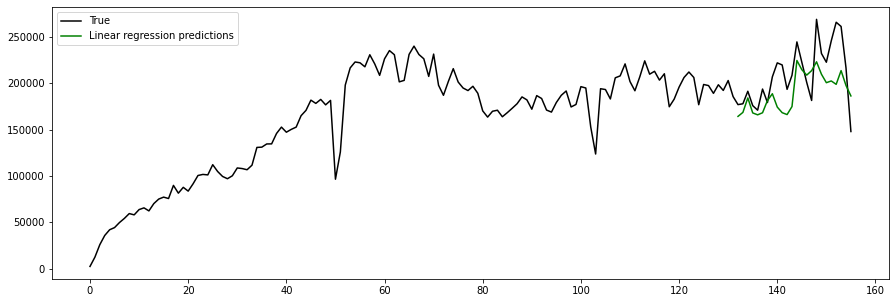

In [251]:
# Treinando novamente a regressão linear

best_index = 107

# model definition
model = LinearRegression()

# model fit
model.fit(X_train.loc[best_index:X_train.index[-1],:], y_train.loc[best_index:X_train.index[-1]])

# predictions
y_pred = model.predict(X_test)

plt.figure(figsize=(15,5))
plt.plot(df_grouped['net_revenue'], color='black', label='True')
plt.legend()
plt.plot(pd.DataFrame(y_pred, index=X_test.index), color='green', label='Linear regression predictions')
plt.legend();

# 9.0 Error interpretation

In [252]:
# Treinando novamente a regressão linear

best_index = 107

# model definition
model = LinearRegression()

# model fit
model.fit(X_train.loc[best_index:X_train.index[-1],:], y_train.loc[best_index:X_train.index[-1]])

# predictions
y_pred = model.predict(X_test)


# storing true values and forecasted values
df_true_x_predictions = pd.DataFrame({'true':y_test, 'predictions':y_pred.astype('int')})

#calculating residuals
df_true_x_predictions['residuals'] = df_true_x_predictions['true'] - df_true_x_predictions['predictions']

#calculating 'upper_limit' and 'lower_limit' based o MAPE
df_true_x_predictions['upper_limit'] = (df_true_x_predictions['predictions'] + df_true_x_predictions['predictions']*mean_absolute_percentage_error(y_test, y_pred)).astype('int')

df_true_x_predictions['lower_limit'] = (df_true_x_predictions['predictions'] - df_true_x_predictions['predictions']*mean_absolute_percentage_error(y_test, y_pred)).astype('int')

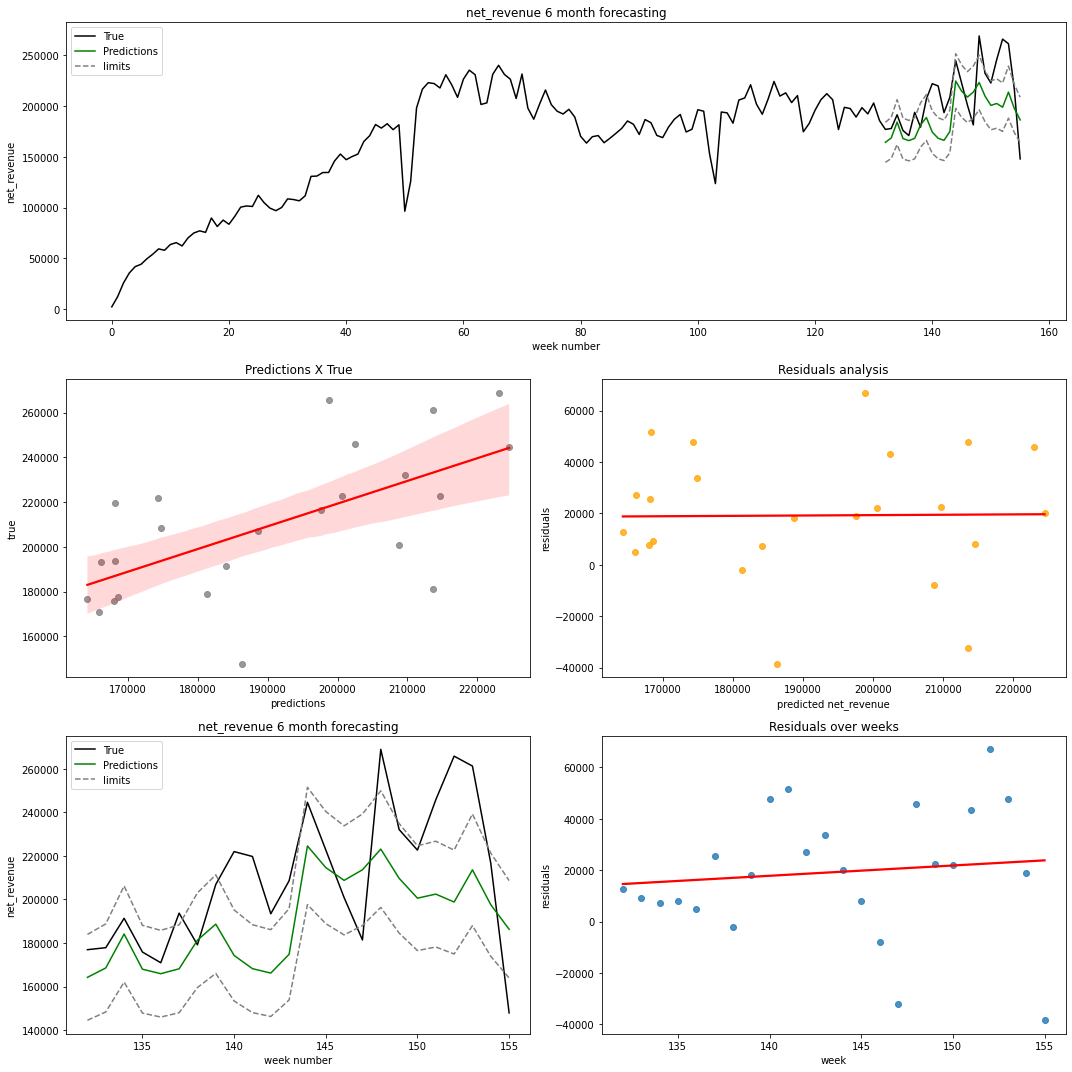

In [254]:
plt.figure(figsize=(15,15))


plt.subplot(3,1,1)
plt.plot(df_grouped['net_revenue'], color='black', label='True')
plt.legend()
plt.plot(df_true_x_predictions['predictions'], color='green', label='Predictions')
plt.legend()
plt.plot(df_true_x_predictions['upper_limit'], color='gray', linestyle='--', label='limits')
plt.legend()
plt.plot(df_true_x_predictions['lower_limit'], color='gray', linestyle='--')
plt.title('net_revenue 6 month forecasting')
plt.xlabel('week number')
plt.ylabel('net_revenue')

plt.subplot(3,2,3)
sns.regplot(x='predictions', y='true', data=df_true_x_predictions,
            scatter_kws={"color": "grey"}, line_kws={"color": "red"})
plt.title('Predictions X True')


plt.subplot(3,2,4)
sns.regplot(x='predictions',y='residuals',data=df_true_x_predictions, ci=False,
            scatter_kws={"color": "orange"}, line_kws={"color": "red"})
plt.xlabel('predicted net_revenue')
plt.title('Residuals analysis')


plt.subplot(3,2,5)
plt.plot(df_true_x_predictions['true'], color='black', label='True')
plt.legend()
plt.plot(df_true_x_predictions['predictions'], color='green', label='Predictions')
plt.legend()
plt.plot(df_true_x_predictions['upper_limit'], color='gray', linestyle='--', label='limits')
plt.legend()
plt.plot(df_true_x_predictions['lower_limit'], color='gray', linestyle='--')
plt.title('net_revenue 6 month forecasting')
plt.xlabel('week number')
plt.ylabel('net_revenue')

plt.subplot(3,2,6)
sns.regplot(x='index',y='residuals',data=df_true_x_predictions.reset_index(), ci=False, line_kws={"color": "red"})
plt.title('Residuals over weeks')
plt.xlabel('week')

plt.tight_layout();

## <font color="gray"> 9.1 Main </font>

# 10.0 Deploy

In [ ]:
# organizar de volta a ordem das colunas para ['customer_id', 'customer_acquisition_channel', 'year', 'week_of_year', 'net_revenue', 'gross_revenue', 'boxes'],

## <font color="gray"> 10.1 Class data_prep.py </font>

## <font color="gray"> 10.2 API_handler.py </font>

## <font color="gray"> 10.3 API tester local </font>

## <font color="gray"> 10.4 API tester remote/cloud </font>

# <font color="green"> Conclusões e pontos de melhora </font>

In [ ]:
# transformar a variável alvo

# criar novas features (estação do ano, feriados, dias até o próximo feriado)



In [ ]:
# não testei o slicing no ARIMA pq dei preferência para a regressão por ser um modelo que alia simplicidade com poder
## adicionar outras varaáveis no futuro, criando "alavancas" para o negócio.

# outra sugestão de melhoria seria testar a rede neural LSTM que é mais adequada para time series, entretanto
## o dataset é pequeno e é bem provável que não retorne bons resultados.

# melhoraria o código substituindo trechos repetidos por funções